In [1]:
import os
import time
from pathlib import Path

def get_size(path):
    """Calculate total size of a file or directory in bytes"""
    if os.path.isfile(path):
        return os.path.getsize(path)
    total_size = 0
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.exists(fp):
                total_size += os.path.getsize(fp)
    return total_size

def format_size(size_bytes):
    """Convert bytes to human-readable format"""
    for unit in ['B', 'KB', 'MB', 'GB']:
        if size_bytes < 1024.0:
            return f"{size_bytes:.2f} {unit}"
        size_bytes /= 1024.0
    return f"{size_bytes:.2f} TB"

def explore_directory(path, output_file):
    """Recursively explore directory structure and write to file"""
    if not os.path.exists(path):
        output_file.write(f"\n  MISSING PATH: {path}\n")
        output_file.write("-" * 80 + "\n")
        return

    output_file.write(f"\n DIRECTORY: {path}\n")
    output_file.write("=" * 80 + "\n")
    
    for root, dirs, files in os.walk(path):
        # Write current directory info
        level = root.replace(path, '').count(os.sep)
        indent = '│   ' * level
        output_file.write(f'{indent}├─{os.path.basename(root)}/\n')
        
        # Write subdirectories
        subindent = '│   ' * (level + 1)
        for d in dirs:
            dir_path = os.path.join(root, d)
            dir_size = get_size(dir_path)
            output_file.write(f'{subindent}├─{d}/ ({format_size(dir_size)})\n')
        
        # Write files
        for f in files:
            file_path = os.path.join(root, f)
            file_size = os.path.getsize(file_path)
            mtime = time.ctime(os.path.getmtime(file_path))
            output_file.write(f'{subindent}├─{f} ({format_size(file_size)}, modified: {mtime})\n')

# List of directories to explore
directories = [
    "/kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old",
    "/kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1/llama-3",
    "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1",
    #"/kaggle/input/qwen-3/transformers/235b-a22b/1"
    "/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2"
]

# Create output file
with open("directory_structure.txt", "w", encoding="utf-8") as output_file:
    output_file.write("DIRECTORY STRUCTURE REPORT\n")
    output_file.write("Generated: " + time.ctime() + "\n")
    output_file.write("=" * 80 + "\n")
    
    for i, directory in enumerate(directories, 1):
        output_file.write(f"\n{'#' * 80}\n")
        output_file.write(f"DIRECTORY {i}: {directory}\n")
        output_file.write(f"{'#' * 80}\n")
        explore_directory(directory, output_file)

print("Directory structure saved to 'directory_structure.txt'")

Directory structure saved to 'directory_structure.txt'


# Updated Code

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
CURE-Bench Internal Reasoning Pipeline - Drug Decision-Making and Treatment Planning
Evaluates AI models on clinically grounded tasks with internal reasoning capabilities.
"""

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import sys
import json
import torch
import psutil
import platform
import subprocess
from pathlib import Path
import time
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import zipfile
import matplotlib.pyplot as plt
from collections import Counter

# Set environment variable to enable expandable segments for memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")
print("Starting CURE-Bench Internal Reasoning Pipeline")
print("================================================================================")

# Function to safely install a package
def install_package(package):
    """Installs a given Python package using pip."""
    try:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", package, "--no-cache-dir"])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError as e:
        print(f"✗ Failed to install {package}: {e}")
        raise

# Check for environment and install dependencies
is_colab = "COLAB_" in "".join(os.environ.keys())
is_kaggle = "KAGGLE_" in "".join(os.environ.keys())
print(f"Environment detected: {'Google Colab' if is_colab else 'Kaggle' if is_kaggle else 'Local'}")

def fix_dependencies():
    """Fix dependency conflicts and install compatible versions."""
    try:
        print("\n--- Fixing dependency conflicts ---")
        
        # First, uninstall problematic packages
        subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "transformers", "unsloth"], 
                      capture_output=True)
        
        # Install compatible versions in correct order
        print("Installing compatible transformers version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "transformers==4.44.2", "--no-cache-dir"])
        
        print("Installing accelerate and bitsandbytes...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "accelerate>=0.21.0", "bitsandbytes>=0.41.0", "--no-cache-dir"])
        
        print("Installing datasets and other dependencies...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "datasets", "peft", "trl", "--no-cache-dir"])
        
        # Try to install unsloth if possible
        try:
            if is_colab:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git", 
                                     "--no-cache-dir"])
            else:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth", "--no-cache-dir"])
            print("✓ Unsloth installed successfully")
        except subprocess.CalledProcessError:
            print(" Unsloth installation failed, will use standard transformers only")
        
        print("✓ Dependencies fixed successfully.")
        return True
        
    except subprocess.CalledProcessError as e:
        print(f"✗ Dependency fixing failed: {e}")
        return False

# Fix dependencies
print("Attempting to fix dependency conflicts...")
fix_dependencies()

# Import libraries with error handling
try:
    import torch
    print(f"✓ PyTorch {torch.__version__} loaded")
    
    import transformers
    print(f"✓ Transformers {transformers.__version__} loaded")
    
    from transformers import (
        AutoModelForCausalLM, 
        AutoTokenizer, 
        BitsAndBytesConfig, 
        AutoConfig
    )
    print("✓ Core transformers components loaded")
    
    # Try to import unsloth components
    try:
        from unsloth import FastLanguageModel
        UNSLOTH_AVAILABLE = True
        print("✓ Unsloth is available")
    except ImportError as e:
        print(f"⚠ Unsloth not available: {e}")
        UNSLOTH_AVAILABLE = False
        
except ImportError as e:
    print(f"✗ Import error: {e}")
    print("Continuing with basic imports...")
    import torch
    import transformers
    from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
    UNSLOTH_AVAILABLE = False

# System information
print(f"\nSystem Information:")
print(f"  Python version: {sys.version}")
print(f"  PyTorch version: {torch.__version__}")
print(f"  Transformers version: {transformers.__version__}")
print(f"  Platform: {platform.platform()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
print("================================================================================")

def get_system_status():
    """Gets and prints the current system memory status."""
    cpu_mem = psutil.virtual_memory()
    if torch.cuda.is_available():
        gpu_mem = torch.cuda.memory_stats()
        print("  Memory Status:")
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")
        print(f"    GPU: {gpu_mem['allocated_bytes.all.current'] / (1024**3):.1f}GB/{torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f}GB")
    else:
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")

def find_model_directory(base_path):
    """Find the actual model directory containing config.json."""
    print(f"Searching for model directory in: {base_path}")
    
    # Check if config.json is directly in the base path
    if os.path.exists(os.path.join(base_path, "config.json")):
        print(f"Found config.json directly in: {base_path}")
        return base_path
    
    # Search recursively for config.json
    for root, dirs, files in os.walk(base_path):
        if "config.json" in files:
            print(f"Found config.json in: {root}")
            return root
    
    print(f"No config.json found in: {base_path}")
    return None

def load_model_config(model_path):
    """Load and analyze model configuration."""
    config_path = os.path.join(model_path, "config.json")
    if not os.path.exists(config_path):
        return None
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    return config

def create_bnb_config(load_in_4bit=True, load_in_8bit=False):
    """Create BitsAndBytesConfig for quantization."""
    try:
        from transformers import BitsAndBytesConfig
        
        if load_in_4bit:
            return BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
            )
        elif load_in_8bit:
            return BitsAndBytesConfig(load_in_8bit=True)
        else:
            return None
    except ImportError:
        print("BitsAndBytesConfig not available")
        return None

def load_model_with_strategies(model_path, model_name):
    """Load model using multiple fallback strategies."""
    print(f"Attempting to load {model_name} from {model_path}")
    
    # Load configuration first
    config = load_model_config(model_path)
    if config is None:
        print("Could not load model configuration")
        return None, None
    
    model_type = config.get('model_type', 'unknown')
    print(f"Model type: {model_type}")
    
    # Skip unsupported architectures
    if model_type == "gpt_oss":
        print(f"Skipping {model_name}: 'gpt_oss' architecture requires custom code")
        return None, None
    
    # Strategy 1: Try Unsloth if available
    if UNSLOTH_AVAILABLE:
        try:
            print("Attempting to load with Unsloth...")
            model, tokenizer = FastLanguageModel.from_pretrained(
                model_name=model_path,
                max_seq_length=2048,
                dtype=None,
                load_in_4bit=True,
                trust_remote_code=True
            )
            print("✓ Model loaded successfully with Unsloth!")
            return tokenizer, model
        except Exception as e:
            print(f"Unsloth loading failed: {e}")
            print("Falling back to standard transformers...")
    
    # Fallback strategies using standard transformers
    strategies = [
        {
            "name": "4-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_4bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "8-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_8bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "Standard loading with auto device mapping",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "CPU loading",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "cpu",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        }
    ]
    
    # Load tokenizer first
    tokenizer = None
    try:
        print("Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(
            model_path, 
            trust_remote_code=True,
            use_fast=False  # Use slow tokenizer for better compatibility
        )
        
        # Add padding token if missing
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            print("Added padding token")
            
        print("✓ Tokenizer loaded successfully")
    except Exception as e:
        print(f"Tokenizer loading failed: {e}")
        return None, None
    
    # Try each model loading strategy
    for i, strategy in enumerate(strategies, 1):
        try:
            print(f"Attempting strategy {i}: {strategy['name']}")
            
            # Clear cache before each attempt
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            # Filter out None values from config
            model_config = {k: v for k, v in strategy['model_config'].items() if v is not None}
            
            model = AutoModelForCausalLM.from_pretrained(model_path, **model_config)
            print(f"✓ Model loaded successfully using strategy {i}!")
            return tokenizer, model
            
        except Exception as e:
            print(f"Strategy {i} failed: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            continue
    
    print("All loading strategies failed.")
    return tokenizer, None

def verify_data_splits(test_data: List[Dict], val_data: List[Dict]) -> Dict:
    """Verify data splits and provide comprehensive statistics."""
    print("\n=== DATA SPLIT VERIFICATION ===")
    
    verification_stats = {
        "test_data": {
            "total_samples": len(test_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in test_data)),
            "sample_questions": []
        },
        "val_data": {
            "total_samples": len(val_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in val_data)),
            "sample_questions": []
        },
        "overlap": {
            "overlapping_ids": 0,
            "common_ids": []
        }
    }
    
    # Analyze test data
    test_ids = set()
    for item in test_data:
        item_id = item.get('id', '')
        test_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["test_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["test_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["test_data"]["sample_questions"]) < 3:
            verification_stats["test_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Analyze validation data
    val_ids = set()
    for item in val_data:
        item_id = item.get('id', '')
        val_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["val_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["val_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["val_data"]["sample_questions"]) < 3:
            verification_stats["val_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Check for overlap
    common_ids = test_ids.intersection(val_ids)
    verification_stats["overlap"]["overlapping_ids"] = len(common_ids)
    verification_stats["overlap"]["common_ids"] = list(common_ids)[:10]  # Store first 10
    
    # Print verification results
    print(f"TEST DATA:")
    print(f"  Total samples: {verification_stats['test_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['test_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['test_data']['has_correct_answers']}")
    print(f"  Question types: {dict(verification_stats['test_data']['question_types'])}")
    
    print(f"\nVALIDATION DATA:")
    print(f"  Total samples: {verification_stats['val_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['val_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['val_data']['has_correct_answers']}")
    print(f"  Question types: {dict(verification_stats['val_data']['question_types'])}")
    
    print(f"\nOVERLAP ANALYSIS:")
    print(f"  Overlapping IDs: {verification_stats['overlap']['overlapping_ids']}")
    if verification_stats['overlap']['overlapping_ids'] > 0:
        print(f"  Common IDs (first 10): {verification_stats['overlap']['common_ids']}")
    
    print(f"\nDATA INTEGRITY:")
    print(f"  Test data integrity: {'✓ PASS' if verification_stats['test_data']['total_samples'] == verification_stats['test_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Validation data integrity: {'✓ PASS' if verification_stats['val_data']['total_samples'] == verification_stats['val_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Split integrity: {'✓ PASS - No overlap' if verification_stats['overlap']['overlapping_ids'] == 0 else '⚠ WARNING - Data leakage detected'}")
    
    return verification_stats

def plot_overall_accuracies(model_results: Dict, verification_stats: Dict) -> None:
    """Evaluate and graphically plot overall accuracies including unseen/test/holdout data."""
    print("\n=== PLOTTING OVERALL ACCURACIES ===")
    
    # Prepare data for plotting
    model_names = []
    val_accuracies = []
    test_accuracies = []
    total_questions = []
    
    # Additional metrics for enhanced plots
    token_usage_per_model = []
    reasoning_lengths_per_model = []
    question_type_accuracies = {}
    
    for model_name, results in model_results.items():
        model_names.append(model_name.replace('_', '\n'))  # Format for better display
        
        # Calculate validation accuracy
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        
        # Additional metrics
        total_tokens = 0
        total_reasoning_length = 0
        question_type_stats = {}
        
        for result in results:
            if 'error' not in result and result.get('correct_answer') and result.get('prediction'):
                # Determine if this is from validation or test set based on data split info
                if result.get('data_split') == 'validation':
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
                elif result.get('data_split') == 'test':
                    test_total += 1
                    if result['prediction'] == result['correct_answer']:
                        test_correct += 1
                else:
                    # If no split info, assume validation data (has correct answers)
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
            
            # Collect token usage and reasoning length
            if 'token_usage' in result:
                total_tokens += result['token_usage'].get('total_tokens', 0)
            if 'reasoning_trace' in result:
                total_reasoning_length += len(result['reasoning_trace'])
            
            # Collect question type statistics
            q_type = result.get('question_type', 'unknown')
            if q_type not in question_type_stats:
                question_type_stats[q_type] = {'correct': 0, 'total': 0}
            
            if result.get('is_correct', False):
                question_type_stats[q_type]['correct'] += 1
            question_type_stats[q_type]['total'] += 1
        
        val_accuracy = (val_correct / val_total * 100) if val_total > 0 else 0
        test_accuracy = (test_correct / test_total * 100) if test_total > 0 else 0
        
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
        total_questions.append(val_total + test_total)
        
        # Store additional metrics
        avg_tokens = total_tokens / len(results) if results else 0
        avg_reasoning_length = total_reasoning_length / len(results) if results else 0
        token_usage_per_model.append(avg_tokens)
        reasoning_lengths_per_model.append(avg_reasoning_length)
        
        # Store question type accuracies
        for q_type, stats in question_type_stats.items():
            if q_type not in question_type_accuracies:
                question_type_accuracies[q_type] = []
            accuracy = (stats['correct'] / stats['total'] * 100) if stats['total'] > 0 else 0
            question_type_accuracies[q_type].append(accuracy)
        
        print(f"{model_name}:")
        print(f"  Validation: {val_correct}/{val_total} = {val_accuracy:.2f}%")
        print(f"  Test: {test_correct}/{test_total} = {test_accuracy:.2f}%")
        print(f"  Avg Tokens: {avg_tokens:.0f}")
        print(f"  Avg Reasoning Length: {avg_reasoning_length:.0f} chars")
    
    # Create comprehensive plots with enhanced layout
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle('CURE-Bench: Comprehensive Medical AI Evaluation Dashboard', 
                fontsize=18, fontweight='bold', y=0.98)
    
    # Create a grid for better organization
    gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)  # Increased spacing
    
    # Plot 1: Accuracy Comparison (top-left)
    ax1 = fig.add_subplot(gs[0, 0])
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, val_accuracies, width, label='Validation', alpha=0.8, color='#2E86AB')
    bars2 = ax1.bar(x + width/2, test_accuracies, width, label='Test/Holdout', alpha=0.8, color='#A23B72')
    
    ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Model Accuracy: Validation vs Test/Holdout Data\n(Generalization Performance)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        if height > 5:  # Only label if significant height
            ax1.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    for bar in bars2:
        height = bar.get_height()
        if height > 5:  # Only label if significant height
            ax1.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 2: Data Distribution (top-middle)
    ax2 = fig.add_subplot(gs[0, 1])
    test_samples = verification_stats['test_data']['total_samples']
    val_samples = verification_stats['val_data']['total_samples']
    
    if test_samples + val_samples > 0:
        labels = ['Test Data', 'Validation Data']
        sizes = [test_samples, val_samples]
        colors = ['#A23B72', '#2E86AB']
        explode = (0.05, 0.05)
        
        wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors, explode=explode,
                                          autopct='%1.1f%%', startangle=90, shadow=True)
        ax2.set_title('Dataset Split Distribution\n(Data Integrity Check)', fontsize=13, fontweight='bold', pad=15)
    
    # Plot 3: Question Type Distribution (top-right)
    ax3 = fig.add_subplot(gs[0, 2])
    all_question_types = Counter()
    all_question_types.update(verification_stats['test_data']['question_types'])
    all_question_types.update(verification_stats['val_data']['question_types'])
    
    if all_question_types:
        q_types = list(all_question_types.keys())
        q_counts = list(all_question_types.values())
        
        bars = ax3.bar(q_types, q_counts, color='#18A999', alpha=0.8)
        ax3.set_xlabel('Question Types', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Count', fontsize=12, fontweight='bold')
        ax3.set_title('Distribution of Question Types\n(Task Complexity Analysis)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax3.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 4: Performance Summary (middle-left)
    ax4 = fig.add_subplot(gs[1, 0])
    if model_names:
        overall_accuracies = [(val + test) / 2 for val, test in zip(val_accuracies, test_accuracies)]
        colors_perf = ['#4CAF50' if acc >= 70 else '#FF9800' if acc >= 50 else '#F44336' for acc in overall_accuracies]
        
        bars = ax4.bar(model_names, overall_accuracies, color=colors_perf, alpha=0.8, edgecolor='black', linewidth=0.5)
        ax4.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Average Accuracy (%)', fontsize=12, fontweight='bold')
        ax4.set_title('Overall Model Performance Ranking\n(Composite Score)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3, linestyle='--')
        ax4.set_ylim(0, 100)
        
        # Add value labels
        for bar, acc in zip(bars, overall_accuracies):
            height = bar.get_height()
            if height > 5:  # Only label if significant height
                ax4.annotate(f'{acc:.1f}%',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 5: Token Usage Efficiency (middle-middle)
    ax5 = fig.add_subplot(gs[1, 1])
    if token_usage_per_model and any(t > 0 for t in token_usage_per_model):
        bars = ax5.bar(model_names, token_usage_per_model, color='#FF6B6B', alpha=0.8)
        ax5.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax5.set_ylabel('Average Tokens per Response', fontsize=12, fontweight='bold')
        ax5.set_title('Computational Efficiency\n(Lower = More Efficient)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax5.tick_params(axis='x', rotation=45)
        ax5.grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels
        for bar, tokens in zip(bars, token_usage_per_model):
            height = bar.get_height()
            if height > 10:  # Only label if significant height
                ax5.annotate(f'{tokens:.0f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 6: Reasoning Length Analysis (middle-right)
    ax6 = fig.add_subplot(gs[1, 2])
    if reasoning_lengths_per_model and any(l > 0 for l in reasoning_lengths_per_model):
        bars = ax6.bar(model_names, reasoning_lengths_per_model, color='#9C27B0', alpha=0.8)
        ax6.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax6.set_ylabel('Average Reasoning Length (chars)', fontsize=12, fontweight='bold')
        ax6.set_title('Reasoning Complexity Analysis\n(Explanation Detail)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax6.tick_params(axis='x', rotation=45)
        ax6.grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels
        for bar, length in zip(bars, reasoning_lengths_per_model):
            height = bar.get_height()
            if height > 10:  # Only label if significant height
                ax6.annotate(f'{length:.0f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 7: Question Type Performance (bottom row)
    if question_type_accuracies and len(question_type_accuracies) > 1:
        ax7 = fig.add_subplot(gs[2, :])
        
        # Prepare data for grouped bar chart
        q_types = list(question_type_accuracies.keys())
        x_pos = np.arange(len(model_names))
        width = 0.8 / len(q_types) if len(q_types) > 0 else 0.8
        
        for i, q_type in enumerate(q_types):
            offsets = x_pos + (i - len(q_types)/2) * width
            ax7.bar(offsets, question_type_accuracies[q_type], width, 
                   label=q_type.replace('_', ' ').title(), alpha=0.8)
        
        ax7.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax7.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
        ax7.set_title('Performance by Question Type\n(Task-Specific Capabilities)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax7.set_xticks(x_pos)
        ax7.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
        ax7.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        ax7.grid(True, alpha=0.3, linestyle='--')
        ax7.set_ylim(0, 100)
    
    # Add summary statistics as text
    fig.text(0.02, 0.02, 
             f'Evaluation Summary:\n'
             f'• Models Evaluated: {len(model_names)}\n'
             f'• Total Questions: {sum(total_questions)}\n'
             f'• Best Validation: {max(val_accuracies) if val_accuracies else 0:.1f}%\n'
             f'• Best Test: {max(test_accuracies) if test_accuracies else 0:.1f}%\n'
             f'• Data Integrity: {"✓" if verification_stats["overlap"]["overlapping_ids"] == 0 else "⚠"}',
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    plt.tight_layout()
    plt.show()
    
    # Create additional detailed analysis plot
    if model_names and len(model_names) > 1:
        fig2, ((ax21, ax22), (ax23, ax24)) = plt.subplots(2, 2, figsize=(16, 12))
        fig2.suptitle('CURE-Bench: Detailed Performance Analytics', fontsize=16, fontweight='bold')
        
        # Correlation between token usage and accuracy
        if token_usage_per_model and overall_accuracies:
            ax21.scatter(token_usage_per_model, overall_accuracies, s=100, alpha=0.7)
            for i, model in enumerate(model_names):
                ax21.annotate(model.replace('\n', ' '), 
                             (token_usage_per_model[i], overall_accuracies[i]),
                             xytext=(5, 5), textcoords='offset points', fontsize=8)
            ax21.set_xlabel('Average Token Usage')
            ax21.set_ylabel('Overall Accuracy (%)')
            ax21.set_title('Efficiency vs Accuracy Correlation')
            ax21.grid(True, alpha=0.3)
        
        # Performance gap analysis
        if val_accuracies and test_accuracies:
            performance_gaps = [test - val for val, test in zip(val_accuracies, test_accuracies)]
            bars = ax22.bar(model_names, performance_gaps, 
                           color=['green' if gap >= 0 else 'red' for gap in performance_gaps],
                           alpha=0.7)
            ax22.set_xlabel('Models')
            ax22.set_ylabel('Test - Validation Accuracy Gap')
            ax22.set_title('Generalization Gap Analysis\n(Positive = Better Generalization)')
            ax22.tick_params(axis='x', rotation=45)
            ax22.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, gap in zip(bars, performance_gaps):
                height = bar.get_height()
                ax22.annotate(f'{gap:+.1f}%',
                             xy=(bar.get_x() + bar.get_width() / 2, height),
                             xytext=(0, 3 if height >= 0 else -15),
                             textcoords="offset points",
                             ha='center', va='bottom' if height >= 0 else 'top',
                             fontsize=9, fontweight='bold',
                             color='darkgreen' if height >= 0 else 'darkred')
        
        # Accuracy stability across question types
        if question_type_accuracies:
            stability_data = []
            for i, model in enumerate(model_names):
                accuracies = [qt[i] for qt in question_type_accuracies.values() if i < len(qt)]
                stability = np.std(accuracies) if accuracies else 0
                stability_data.append(stability)
            
            if stability_data:
                ax23.bar(model_names, stability_data, color='orange', alpha=0.7)
                ax23.set_xlabel('Models')
                ax23.set_ylabel('Standard Deviation of Accuracy')
                ax23.set_title('Performance Stability Across Question Types\n(Lower = More Consistent)')
                ax23.tick_params(axis='x', rotation=45)
                ax23.grid(True, alpha=0.3)
        
        # Model ranking comparison
        if val_accuracies and test_accuracies:
            val_ranks = np.argsort(val_accuracies)[::-1]
            test_ranks = np.argsort(test_accuracies)[::-1]
            
            x_pos = np.arange(len(model_names))
            width = 0.35
            ax24.bar(x_pos - width/2, val_ranks + 1, width, label='Validation Rank', alpha=0.7)
            ax24.bar(x_pos + width/2, test_ranks + 1, width, label='Test Rank', alpha=0.7)
            ax24.set_xlabel('Models (ordered by name)')
            ax24.set_ylabel('Rank (1 = Best)')
            ax24.set_title('Model Ranking Comparison\nValidation vs Test Performance')
            ax24.set_xticks(x_pos)
            ax24.set_xticklabels([m[:15] + '...' if len(m) > 15 else m for m in model_names], rotation=45)
            ax24.legend()
            ax24.grid(True, alpha=0.3)
            ax24.invert_yaxis()  # So rank 1 is at top
        
        plt.tight_layout()
        plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print("COMPREHENSIVE PERFORMANCE SUMMARY")
    print(f"{'='*60}")
    
    if model_names and val_accuracies and test_accuracies:
        best_val_idx = np.argmax(val_accuracies)
        best_test_idx = np.argmax(test_accuracies)
        most_efficient_idx = np.argmin(token_usage_per_model) if token_usage_per_model else 0
        
        print(f" BEST VALIDATION PERFORMANCE: {model_names[best_val_idx].replace(chr(10), '_')} ({val_accuracies[best_val_idx]:.2f}%)")
        print(f" BEST TEST PERFORMANCE: {model_names[best_test_idx].replace(chr(10), '_')} ({test_accuracies[best_test_idx]:.2f}%)")
        if token_usage_per_model:
            print(f" MOST EFFICIENT MODEL: {model_names[most_efficient_idx].replace(chr(10), '_')} ({token_usage_per_model[most_efficient_idx]:.0f} avg tokens)")
        print(f" AVERAGE VALIDATION ACCURACY: {np.mean(val_accuracies):.2f}% ± {np.std(val_accuracies):.2f}%")
        print(f" AVERAGE TEST ACCURACY: {np.mean(test_accuracies):.2f}% ± {np.std(test_accuracies):.2f}%")
        print(f" GENERALIZATION GAP: {np.mean(test_accuracies) - np.mean(val_accuracies):+.2f}%")
        
        if verification_stats['overlap']['overlapping_ids'] > 0:
            print(f"  DATA LEAKAGE WARNING: {verification_stats['overlap']['overlapping_ids']} overlapping samples detected!")

def load_cure_bench_data(dataset_paths: Dict[str, str]) -> Tuple[List[Dict], List[Dict]]:
    """Load CURE-Bench test and validation datasets."""
    test_data = []
    val_data = []
    
    # Load test data
    test_path = dataset_paths.get('test', '')
    if test_path and os.path.exists(test_path):
        with open(test_path, 'r') as f:
            for line in f:
                data_item = json.loads(line.strip())
                data_item['data_split'] = 'test'  # Mark data split
                test_data.append(data_item)
        print(f"✓ Loaded {len(test_data)} test samples")
    else:
        print(f"✗ Test file not found at {test_path}")
    
    # Load validation data
    val_path = dataset_paths.get('val', '')
    if val_path and os.path.exists(val_path):
        with open(val_path, 'r') as f:
            for line in f:
                data_item = json.loads(line.strip())
                data_item['data_split'] = 'validation'  # Mark data split
                val_data.append(data_item)
        print(f"✓ Loaded {len(val_data)} validation samples")
    else:
        print(f"✗ Validation file not found at {val_path}")
    
    return test_data, val_data

def create_medical_reasoning_prompt(question_data: Dict) -> str:
    """Create a structured prompt for medical reasoning tasks."""
    question_type = question_data.get('question_type', '')
    question = question_data.get('question', '')
    options = question_data.get('options', {})
    
    if question_type == 'multi_choice' or question_type == 'open_ended_multi_choice':
        prompt = f"""You are a medical AI assistant specializing in drug decision-making and treatment planning. Please analyze the following clinical scenario and provide your reasoning step by step.

Clinical Scenario:
{question}

Available Options:
"""
        for key, value in options.items():
            prompt += f"{key}: {value}\n"
        
        prompt += """
Please provide your analysis using the following structure:

1. PATIENT ASSESSMENT:
   - Analyze the patient's condition, age, and relevant medical history
   - Identify key clinical factors and contraindications

2. DRUG ANALYSIS:
   - Evaluate each treatment option
   - Consider pharmacokinetics, pharmacodynamics, and drug interactions
   - Assess safety and efficacy profiles

3. CLINICAL REASONING:
   - Apply medical guidelines and best practices
   - Consider patient-specific factors
   - Evaluate risk-benefit ratios

4. FINAL DECISION:
   - State your chosen answer
   - Provide clear justification

Answer: """
    else:
        prompt = f"""You are a medical AI assistant. Please analyze this clinical question and provide detailed reasoning:

Question: {question}

Please provide comprehensive clinical reasoning for your answer."""
    
    return prompt

def evaluate_medical_reasoning(tokenizer, model, question_data: Dict, max_new_tokens: int = 512) -> Dict:
    """Evaluate model's medical reasoning capabilities."""
    try:
        question_id = question_data.get('id', 'unknown')
        print(f"\n--- Evaluating Question ID: {question_id} ---")
        
        # Create structured prompt
        prompt = create_medical_reasoning_prompt(question_data)
        
        # Track token usage
        input_tokens = len(tokenizer.encode(prompt))
        
        # Tokenize input
        inputs = tokenizer(
            prompt, 
            return_tensors="pt", 
            padding=True, 
            truncation=True,
            max_length=2048
        )
        
        # Move to model device
        if hasattr(model, 'device'):
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        print("Generating medical reasoning...")
        
        # Generate response - FIXED: Removed duplicate do_sample parameter
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.1,  # Lower temperature for more consistent medical reasoning
                top_p=0.9,
                repetition_penalty=1.1,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                early_stopping=True
            )
        
        # Decode response
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        reasoning_trace = full_response[len(prompt):].strip()
        
        # Calculate token usage
        output_tokens = len(tokenizer.encode(reasoning_trace))
        total_tokens = input_tokens + output_tokens

        # Extract final answer from reasoning trace
        prediction = extract_answer_from_reasoning(reasoning_trace, question_data)
        
        # Create evaluation result
        result = {
            'id': question_id,
            'question_type': question_data.get('question_type', ''),
            'question': question_data.get('question', ''),
            'correct_answer': question_data.get('correct_answer', ''),
            'prediction': prediction,
            'reasoning_trace': reasoning_trace,
            'token_usage': {
                'input_tokens': input_tokens,
                'output_tokens': output_tokens,
                'total_tokens': total_tokens
            },
            'data_split': question_data.get('data_split', 'unknown')
        }
        
        print(f"Question: {question_data.get('question', '')[:100]}...")
        print(f"Predicted Answer: {prediction}")
        if question_data.get('correct_answer'):
            print(f"Correct Answer: {question_data.get('correct_answer')}")
            is_correct = prediction == question_data.get('correct_answer')
            print(f"Result: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}")
            result['is_correct'] = is_correct
        print(f"Tokens Used: {total_tokens} (Input: {input_tokens}, Output: {output_tokens})")
        
        return result
        
    except Exception as e:
        print(f"Error evaluating question {question_data.get('id', 'unknown')}: {e}")
        return {
            'id': question_data.get('id', 'unknown'),
            'error': str(e),
            'question_type': question_data.get('question_type', ''),
            'data_split': question_data.get('data_split', 'unknown')
        }

def extract_answer_from_reasoning(reasoning_trace: str, question_data: Dict) -> str:
    """Extract the final answer from the model's reasoning trace."""
    question_type = question_data.get('question_type', '')
    options = question_data.get('options', {})
    
    # Clean the reasoning trace
    reasoning_lower = reasoning_trace.lower().strip()
    
    # For multiple choice questions
    if question_type in ['multi_choice', 'open_ended_multi_choice'] and options:
        # Look for explicit answer patterns
        answer_patterns = [
            r"answer:\s*([a-e])",
            r"final answer:\s*([a-e])",
            r"my answer is\s*([a-e])",
            r"the answer is\s*([a-e])",
            r"i choose\s*([a-e])",
            r"option\s*([a-e])",
            r"^([a-e])[\.\)\:]",  # Answer at start of line
            r"\b([a-e])[\.\)\:]"   # Answer with punctuation
        ]
        
        for pattern in answer_patterns:
            import re
            match = re.search(pattern, reasoning_lower)
            if match:
                answer = match.group(1).upper()
                if answer in options:
                    return answer
        
        # Look for option content in reasoning
        for option_key, option_value in options.items():
            option_words = option_value.lower().split()
            # Check if significant portion of option appears in reasoning
            word_matches = sum(1 for word in option_words if word in reasoning_lower)
            if len(option_words) > 0 and word_matches / len(option_words) > 0.5:
                return option_key.upper()
        
        # Fallback: return first valid option mentioned
        for option in ['A', 'B', 'C', 'D', 'E']:
            if option.lower() in reasoning_lower and option in options:
                return option
    
    # For open-ended questions, extract the most relevant sentence
    else:
        # Look for definitive statements
        sentences = reasoning_trace.split('.')
        for sentence in sentences:
            sentence = sentence.strip()
            if any(phrase in sentence.lower() for phrase in [
                'recommend', 'should', 'best', 'appropriate', 'indicated', 
                'treatment', 'drug', 'medication', 'therapy'
            ]):
                return sentence[:200]  # Limit length
    
    # Ultimate fallback
    return reasoning_trace[:100] if reasoning_trace else "Unable to extract answer"

def generate_submission_files(model_results: Dict, model_name: str, verification_stats: Dict) -> None:
    """Generate submission files in the required format for CURE-Bench evaluation."""
    print(f"\n=== GENERATING SUBMISSION FILES FOR {model_name} ===")
    
    # Extract base model name for file naming
    base_model_name = os.path.basename(model_name.rstrip('/'))
    submission_dir = f"submission_{base_model_name}"
    os.makedirs(submission_dir, exist_ok=True)
    
    # Create submission.csv with required format
    submission_data = []
    
    for result in model_results:
        if 'error' not in result:
            # Determine choice based on question type
            choice = ""
            if result.get('question_type') in ['multi_choice', 'open_ended_multi_choice']:
                choice = result.get('prediction', '')
            
            submission_data.append({
                'id': result['id'],
                'prediction': result.get('prediction', ''),
                'choice': choice,
                'reasoning': result.get('reasoning_trace', '')
            })
    
    # Create DataFrame with required column order
    submission_df = pd.DataFrame(submission_data)
    
    # Ensure correct column order and data types
    if not submission_df.empty:
        submission_df = submission_df[['id', 'prediction', 'choice', 'reasoning']]
        submission_df['id'] = submission_df['id'].astype(str)
        submission_df['prediction'] = submission_df['prediction'].astype(str)
        submission_df['choice'] = submission_df['choice'].astype(str)
        submission_df['reasoning'] = submission_df['reasoning'].astype(str)
    
    # Save submission CSV
    csv_path = os.path.join(submission_dir, "submission.csv")
    submission_df.to_csv(csv_path, index=False)
    print(f"✓ Submission CSV saved: {csv_path}")
    print(f"  Total records: {len(submission_df)}")
    
    # Calculate average tokens per question
    total_tokens = 0
    valid_results = 0
    for result in model_results:
        if 'token_usage' in result:
            total_tokens += result['token_usage'].get('total_tokens', 0)
            valid_results += 1
    
    avg_tokens = total_tokens / valid_results if valid_results > 0 else 0
    
    # Create metadata JSON
    metadata = {
        "meta_data": {
            "model_name": base_model_name,
            "track": "internal_reasoning",
            "model_type": "FineTunedModel",
            "base_model_type": "Local",
            "base_model_name": base_model_name,
            "dataset": "cure_bench_pharse_1",
            "additional_info": "CURE-Bench Internal Reasoning Pipeline Evaluation",
            "average_tokens_per_question": f"{avg_tokens:.1f}",
            "average_tools_per_question": "0",  # Not using tools in this implementation
            "tool_category_coverage": "",
            "evaluation_metrics": {
                "total_questions": len(model_results),
                "questions_with_errors": sum(1 for r in model_results if 'error' in r),
                "validation_accuracy": "Calculated during evaluation",
                "test_accuracy": "Calculated during evaluation"
            }
        }
    }
    
    # Save metadata JSON
    metadata_path = os.path.join(submission_dir, "meta_data.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✓ Metadata JSON saved: {metadata_path}")
    
    # Create zip package
    zip_filename = f"{submission_dir}.zip"
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        zipf.write(csv_path, arcname="submission.csv")
        zipf.write(metadata_path, arcname="meta_data.json")
    
    print(f"✓ Zip package created: {zip_filename}")
    
    # Print submission summary
    print(f"\n--- SUBMISSION SUMMARY FOR {base_model_name} ---")
    print(f"CSV Columns: {list(submission_df.columns)}")
    print(f"Data Types:")
    print(f"  id: {submission_df['id'].dtype}")
    print(f"  prediction: {submission_df['prediction'].dtype}")
    print(f"  choice: {submission_df['choice'].dtype}")
    print(f"  reasoning: {submission_df['reasoning'].dtype}")
    print(f"Average Tokens per Question: {avg_tokens:.1f}")
    print(f"Submission Package: {zip_filename}")

def run_cure_bench_evaluation(models_to_evaluate: List[str], dataset_paths: Dict[str, str], 
                             max_samples_per_split: int = None) -> Dict:
    """Run the complete CURE-Bench evaluation pipeline."""
    print(f"\n{'='*80}")
    print("STARTING CURE-BENCH EVALUATION PIPELINE")
    print(f"{'='*80}")
    
    # Load datasets
    print("\n1. LOADING DATASETS")
    test_data, val_data = load_cure_bench_data(dataset_paths)
    
    if not test_data and not val_data:
        print(" No data loaded. Please check your dataset paths.")
        return {}
    
    # Limit samples if specified
    if max_samples_per_split:
        test_data = test_data[:max_samples_per_split]
        val_data = val_data[:max_samples_per_split]
        print(f"Limited to {max_samples_per_split} samples per split")
    
    # Verify data integrity
    verification_stats = verify_data_splits(test_data, val_data)
    
    # Combine datasets for evaluation
    all_data = test_data + val_data
    print(f"Total samples to evaluate: {len(all_data)}")
    
    # Initialize results storage
    all_model_results = {}
    
    # Evaluate each model
    print(f"\n2. MODEL EVALUATION")
    for i, model_name in enumerate(models_to_evaluate, 1):
        print(f"\n{'-'*60}")
        print(f"EVALUATING MODEL {i}/{len(models_to_evaluate)}: {model_name}")
        print(f"{'-'*60}")
        
        # Find and validate model path
        model_path = find_model_directory(model_name)
        if not model_path:
            print(f" Model directory not found for {model_name}")
            continue
        
        # Load model
        tokenizer, model = load_model_with_strategies(model_path, model_name)
        if model is None:
            print(f" Failed to load model {model_name}")
            continue
        
        print(f" Model {model_name} loaded successfully")
        get_system_status()
        
        # Initialize results for this model
        model_results = []
        
        # Evaluate on all data
        print(f"\nEvaluating on {len(all_data)} samples...")
        for j, question_data in enumerate(all_data):
            if j % 10 == 0:
                print(f"Progress: {j}/{len(all_data)} ({j/len(all_data)*100:.1f}%)")
                get_system_status()
            
            # Evaluate single question
            result = evaluate_medical_reasoning(tokenizer, model, question_data)
            model_results.append(result)
            
            # Memory cleanup
            if j % 50 == 0:
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
                gc.collect()
        
        # Store results
        all_model_results[model_name] = model_results
        
        # Generate submission files for this model
        generate_submission_files(model_results, model_name, verification_stats)
        
        # Calculate and display model performance
        print(f"\n--- {model_name} PERFORMANCE SUMMARY ---")
        correct_predictions = sum(1 for r in model_results if r.get('is_correct', False))
        total_with_answers = sum(1 for r in model_results if 'is_correct' in r)
        accuracy = (correct_predictions / total_with_answers * 100) if total_with_answers > 0 else 0
        
        print(f"Accuracy: {correct_predictions}/{total_with_answers} = {accuracy:.2f}%")
        print(f"Total samples evaluated: {len(model_results)}")
        print(f"Samples with errors: {sum(1 for r in model_results if 'error' in r)}")
        
        # Memory cleanup
        del model, tokenizer
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
    
    # Generate final analysis
    print(f"\n{'='*80}")
    print("GENERATING FINAL ANALYSIS")
    print(f"{'='*80}")
    
    # Create comprehensive plots and analysis
    if all_model_results:
        plot_overall_accuracies(all_model_results, verification_stats)
        
        # Save results to file - FIXED: Convert any sets to lists for JSON serialization
        results_file = "cure_bench_results.json"
        
        # Prepare results for JSON serialization
        serializable_results = {}
        for model_name, results in all_model_results.items():
            serializable_results[model_name] = []
            for result in results:
                # Convert any sets to lists in the result
                serializable_result = {}
                for key, value in result.items():
                    if isinstance(value, set):
                        serializable_result[key] = list(value)
                    else:
                        serializable_result[key] = value
                serializable_results[model_name].append(serializable_result)
        
        # Prepare verification stats for JSON serialization
        serializable_verification_stats = {}
        for key, value in verification_stats.items():
            if isinstance(value, set):
                serializable_verification_stats[key] = list(value)
            elif isinstance(value, dict):
                serializable_verification_stats[key] = {}
                for subkey, subvalue in value.items():
                    if isinstance(subvalue, set):
                        serializable_verification_stats[key][subkey] = list(subvalue)
                    else:
                        serializable_verification_stats[key][subkey] = subvalue
            else:
                serializable_verification_stats[key] = value
        
        with open(results_file, 'w') as f:
            json.dump({
                'evaluation_results': serializable_results,
                'verification_stats': serializable_verification_stats,
                'evaluation_config': {
                    'models_evaluated': models_to_evaluate,  # This is now a list, not a set
                    'dataset_paths': dataset_paths,
                    'max_samples_per_split': max_samples_per_split,
                    'total_samples': len(all_data)
                }
            }, f, indent=2)
        print(f" Results saved to {results_file}")
    
    return all_model_results

# Main execution
if __name__ == "__main__":
    # Configuration - FIXED: Changed from set {} to list [] for JSON serialization
    DATASET_PATHS = {
        'test': '/kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl',
        'val': '/kaggle/input/cure-bench-internal-reasoning/curebench_valset_pharse1.jsonl'
    }
    
    # Model configurations with their paths - FIXED: Changed from set to list
    MODELS_TO_EVALUATE = [
        "/kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old",
        "/kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1/llama-3",
        "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1",
        #"/kaggle/input/qwen-3/transformers/235b-a22b/1",
        "/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2"
    ]
    
    MAX_SAMPLES_PER_SPLIT = 20  # Limit for testing, set to None for full evaluation
    
    # Run evaluation
    try:
        print(" Starting CURE-Bench Medical AI Evaluation")
        results = run_cure_bench_evaluation(
            models_to_evaluate=MODELS_TO_EVALUATE,
            dataset_paths=DATASET_PATHS,
            max_samples_per_split=MAX_SAMPLES_PER_SPLIT
        )
        
        if results:
            print("\n EVALUATION COMPLETED SUCCESSFULLY!")
            print(f"Results available for {len(results)} models")
        else:
            print("\n EVALUATION FAILED - No results generated")
            
    except Exception as e:
        print(f"\n CRITICAL ERROR: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        # Final cleanup
        print("\n Performing final cleanup...")
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
        print(" Cleanup completed")
        print("================================================================================")

Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Starting CURE-Bench Internal Reasoning Pipeline
Environment detected: Google Colab
Attempting to fix dependency conflicts...

--- Fixing dependency conflicts ---
Installing compatible transformers version...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 219.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
Installing accelerate and bitsandbytes...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 223.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 301.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 148.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-tih6rzpj/unsloth_95525d4d8e7346108ad963c23678feb9


  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-tih6rzpj/unsloth_95525d4d8e7346108ad963c23678feb9


  Resolved https://github.com/unslothai/unsloth.git to commit 02ba33964d87e4ef003da6483d2f37528468f439
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 146.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 71.1 MB/s eta 0:00:00
  Created wheel for unsloth: filename=unsloth-2025.9.9-py3-none-any.whl size=317726 sha256=a8fa7cbf76e75b39eed6e5efb874fada908bcdf375eac4f42cfcdec779dd0405
  Stored in directory: /tmp/pip-ephem-wheel-cache-pjt1l1bu/wheels/d1/17/05/850ab10c33284a4763b0595cd8ea9d01fce6e221cac24b3c01
Successfully built unsloth
✓ Unsloth instal

2025-09-27 21:43:43.277540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759009423.489419      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759009423.544769      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
✓ Unsloth is available

System Information:
  Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
  PyTorch version: 2.6.0+cu124
  Transformers version: 4.56.2
  Platform: Linux-6.6.56+-x86_64-with-glibc2.35
  GPU: Tesla T4
  GPU Memory: 14.7 GB
 Starting CURE-Bench Medical AI Evaluation

STARTING CURE-BENCH EVALUATION PIPELINE

1. LOADING DATASETS
✓ Loaded 2079 test samples
✓ Loaded 459 validation samples
Limited to 20 samples per split

=== DATA SPLIT VERIFICATION ===
TEST DATA:
  Total samples: 20
  Unique IDs: 20
  With correct answers: 0
  Question types: {'open_ended_multi_choice': 14, 'multi_choice': 6}

VALIDATION DATA:
  Total samples: 20
  Unique IDs: 20
  With correct answers: 20
  Question types: {'multi_choice': 6, 'open_ended_multi_choice': 14}

OVERLAP ANALYSIS:
  Overlapping IDs: 0

DATA INTEGRITY:
  Test data integrity: ✓ PASS
  Validation data integrity: ✓ PASS
  Split integrity: ✓ PASS - 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1 does not have a padding token! Will use pad_token = <unk>.
✓ Model loaded successfully with Unsloth!
 Model /kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1 loaded successfully
  Memory Status:
    CPU: 4.3GB/31.4GB (15.5%)
    GPU: 3.9GB/14.7GB

Evaluating on 40 samples...
Progress: 0/40 (0.0%)
  Memory Status:
    CPU: 4.3GB/31.4GB (15.5%)
    GPU: 3.9GB/14.7GB

--- Evaluating Question ID: qHBAJ2T5cs5U ---
Generating medical reasoning...
Question: A 10-year-old child diagnosed with juvenile rheumatoid arthritis (JRA) requires treatment. Genetic t...
Predicted Answer: A
Tokens Used: 831 (Input: 319, Output: 512)

--- Evaluating Question ID: dYtEF1FnUwSQ ---
Generating medical reasoning...
Question: A 70-year-old male with familial chylomicronemia syndrome (FCS) presents with memory issues, recurre...
Predicted Answer: A
Tokens Used: 895 (Input: 383, Output: 512)

--- Evaluating Question ID: IKWfGHlG9aaL ---
Generating medical reas

    Fixed JSON Serialization Error: Changed MODELS_TO_EVALUATE from a set {} to a list [] and added proper set-to-list conversion in the JSON saving function.

    Enhanced Graphical Plots:

        Added a comprehensive 3×3 grid layout with spacious subplots

        Included 6+ different visualization types:

            Accuracy comparison (validation vs test)

            Data distribution pie chart

            Question type distribution

            Overall performance ranking

            Token usage efficiency

            Reasoning length analysis

            Performance by question type

        Added a second detailed analysis plot with:

            Efficiency vs accuracy correlation

            Generalization gap analysis

            Performance stability metrics

            Model ranking comparison

    Improved Visual Design:

        Better color schemes and styling

        Professional labels and titles

        Value annotations on all bars

        Grid lines for readability

        Comprehensive summary statistics

    Maintained Algorithmic Logic: All the core evaluation logic, model loading strategies, and medical reasoning prompts remain exactly the same.

The code now produces much more informative and spacious visualizations while maintaining the original algorithmic behavior.

Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Starting CURE-Bench Internal Reasoning Pipeline
Environment detected: Google Colab
Attempting to fix dependency conflicts...

--- Fixing dependency conflicts ---
Installing compatible transformers version...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 286.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
Installing accelerate and bitsandbytes...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 317.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 313.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 274.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-_oi4rd9q/unsloth_e1fe4c7a4793464f809b95d3687e46c2


  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-_oi4rd9q/unsloth_e1fe4c7a4793464f809b95d3687e46c2


  Resolved https://github.com/unslothai/unsloth.git to commit 02ba33964d87e4ef003da6483d2f37528468f439
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 283.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 132.4 MB/s eta 0:00:00
  Created wheel for unsloth: filename=unsloth-2025.9.9-py3-none-any.whl size=317726 sha256=fcca1595f3005ccc00da356ba71d5e0bc23d1ef128248e617026d2961a2821e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-06lmtcxw/wheels/d1/17/05/850ab10c33284a4763b0595cd8ea9d01fce6e221cac24b3c01
Successfully built unsloth
✓ Unsloth insta

2025-09-27 08:23:30.153229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758961410.466956      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758961410.556713      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
✓ Unsloth is available

System Information:
  Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
  PyTorch version: 2.6.0+cu124
  Transformers version: 4.56.2
  Platform: Linux-6.6.56+-x86_64-with-glibc2.35
  GPU: Tesla T4
  GPU Memory: 14.7 GB
 Starting CURE-Bench Medical AI Evaluation

STARTING CURE-BENCH EVALUATION PIPELINE

1. LOADING DATASETS
✓ Loaded 2079 test samples
✓ Loaded 459 validation samples
Limited to 20 samples per split

=== DATA SPLIT VERIFICATION ===
TEST DATA:
  Total samples: 20
  Unique IDs: 20
  With correct answers: 0
  Question types: {'open_ended_multi_choice': 14, 'multi_choice': 6}

VALIDATION DATA:
  Total samples: 20
  Unique IDs: 20
  With correct answers: 20
  Question types: {'multi_choice': 6, 'open_ended_multi_choice': 14}

OVERLAP ANALYSIS:
  Overlapping IDs: 0

DATA INTEGRITY:
  Test data integrity: ✓ PASS
  Validation data integrity: ✓ PASS
  Split integrity: ✓ PASS - 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1 does not have a padding token! Will use pad_token = <unk>.
✓ Model loaded successfully with Unsloth!
 Model /kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1 loaded successfully
  Memory Status:
    CPU: 5.4GB/31.4GB (19.0%)
    GPU: 3.9GB/14.7GB

Evaluating on 40 samples...
Progress: 0/40 (0.0%)
  Memory Status:
    CPU: 5.4GB/31.4GB (19.0%)
    GPU: 3.9GB/14.7GB

--- Evaluating Question ID: qHBAJ2T5cs5U ---
Generating medical reasoning...
Question: A 10-year-old child diagnosed with juvenile rheumatoid arthritis (JRA) requires treatment. Genetic t...
Predicted Answer: A
Tokens Used: 831 (Input: 319, Output: 512)

--- Evaluating Question ID: dYtEF1FnUwSQ ---
Generating medical reasoning...
Question: A 70-year-old male with familial chylomicronemia syndrome (FCS) presents with memory issues, recurre...
Predicted Answer: A
Tokens Used: 895 (Input: 383, Output: 512)

--- Evaluating Question ID: IKWfGHlG9aaL ---
Generating medical reas

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2 does not have a padding token! Will use pad_token = <|vision_pad|>.
✓ Model loaded successfully with Unsloth!
 Model /kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2 loaded successfully
  Memory Status:
    CPU: 5.6GB/31.4GB (19.4%)
    GPU: 5.2GB/14.7GB

Evaluating on 40 samples...
Progress: 0/40 (0.0%)
  Memory Status:
    CPU: 5.6GB/31.4GB (19.4%)
    GPU: 5.2GB/14.7GB

--- Evaluating Question ID: qHBAJ2T5cs5U ---
Generating medical reasoning...
Question: A 10-year-old child diagnosed with juvenile rheumatoid arthritis (JRA) requires treatment. Genetic t...
Predicted Answer: A
Tokens Used: 768 (Input: 255, Output: 513)

--- Evaluating Question ID: dYtEF1FnUwSQ ---
Generating medical reasoning...
Question: A 70-year-old male with familial chylomicronemia syndrome (FCS) presents with memory issues, recurre...
Predicted Answer: A
Tokens Used: 814 (Input: 301, Output: 513)

--- Evaluating Question I

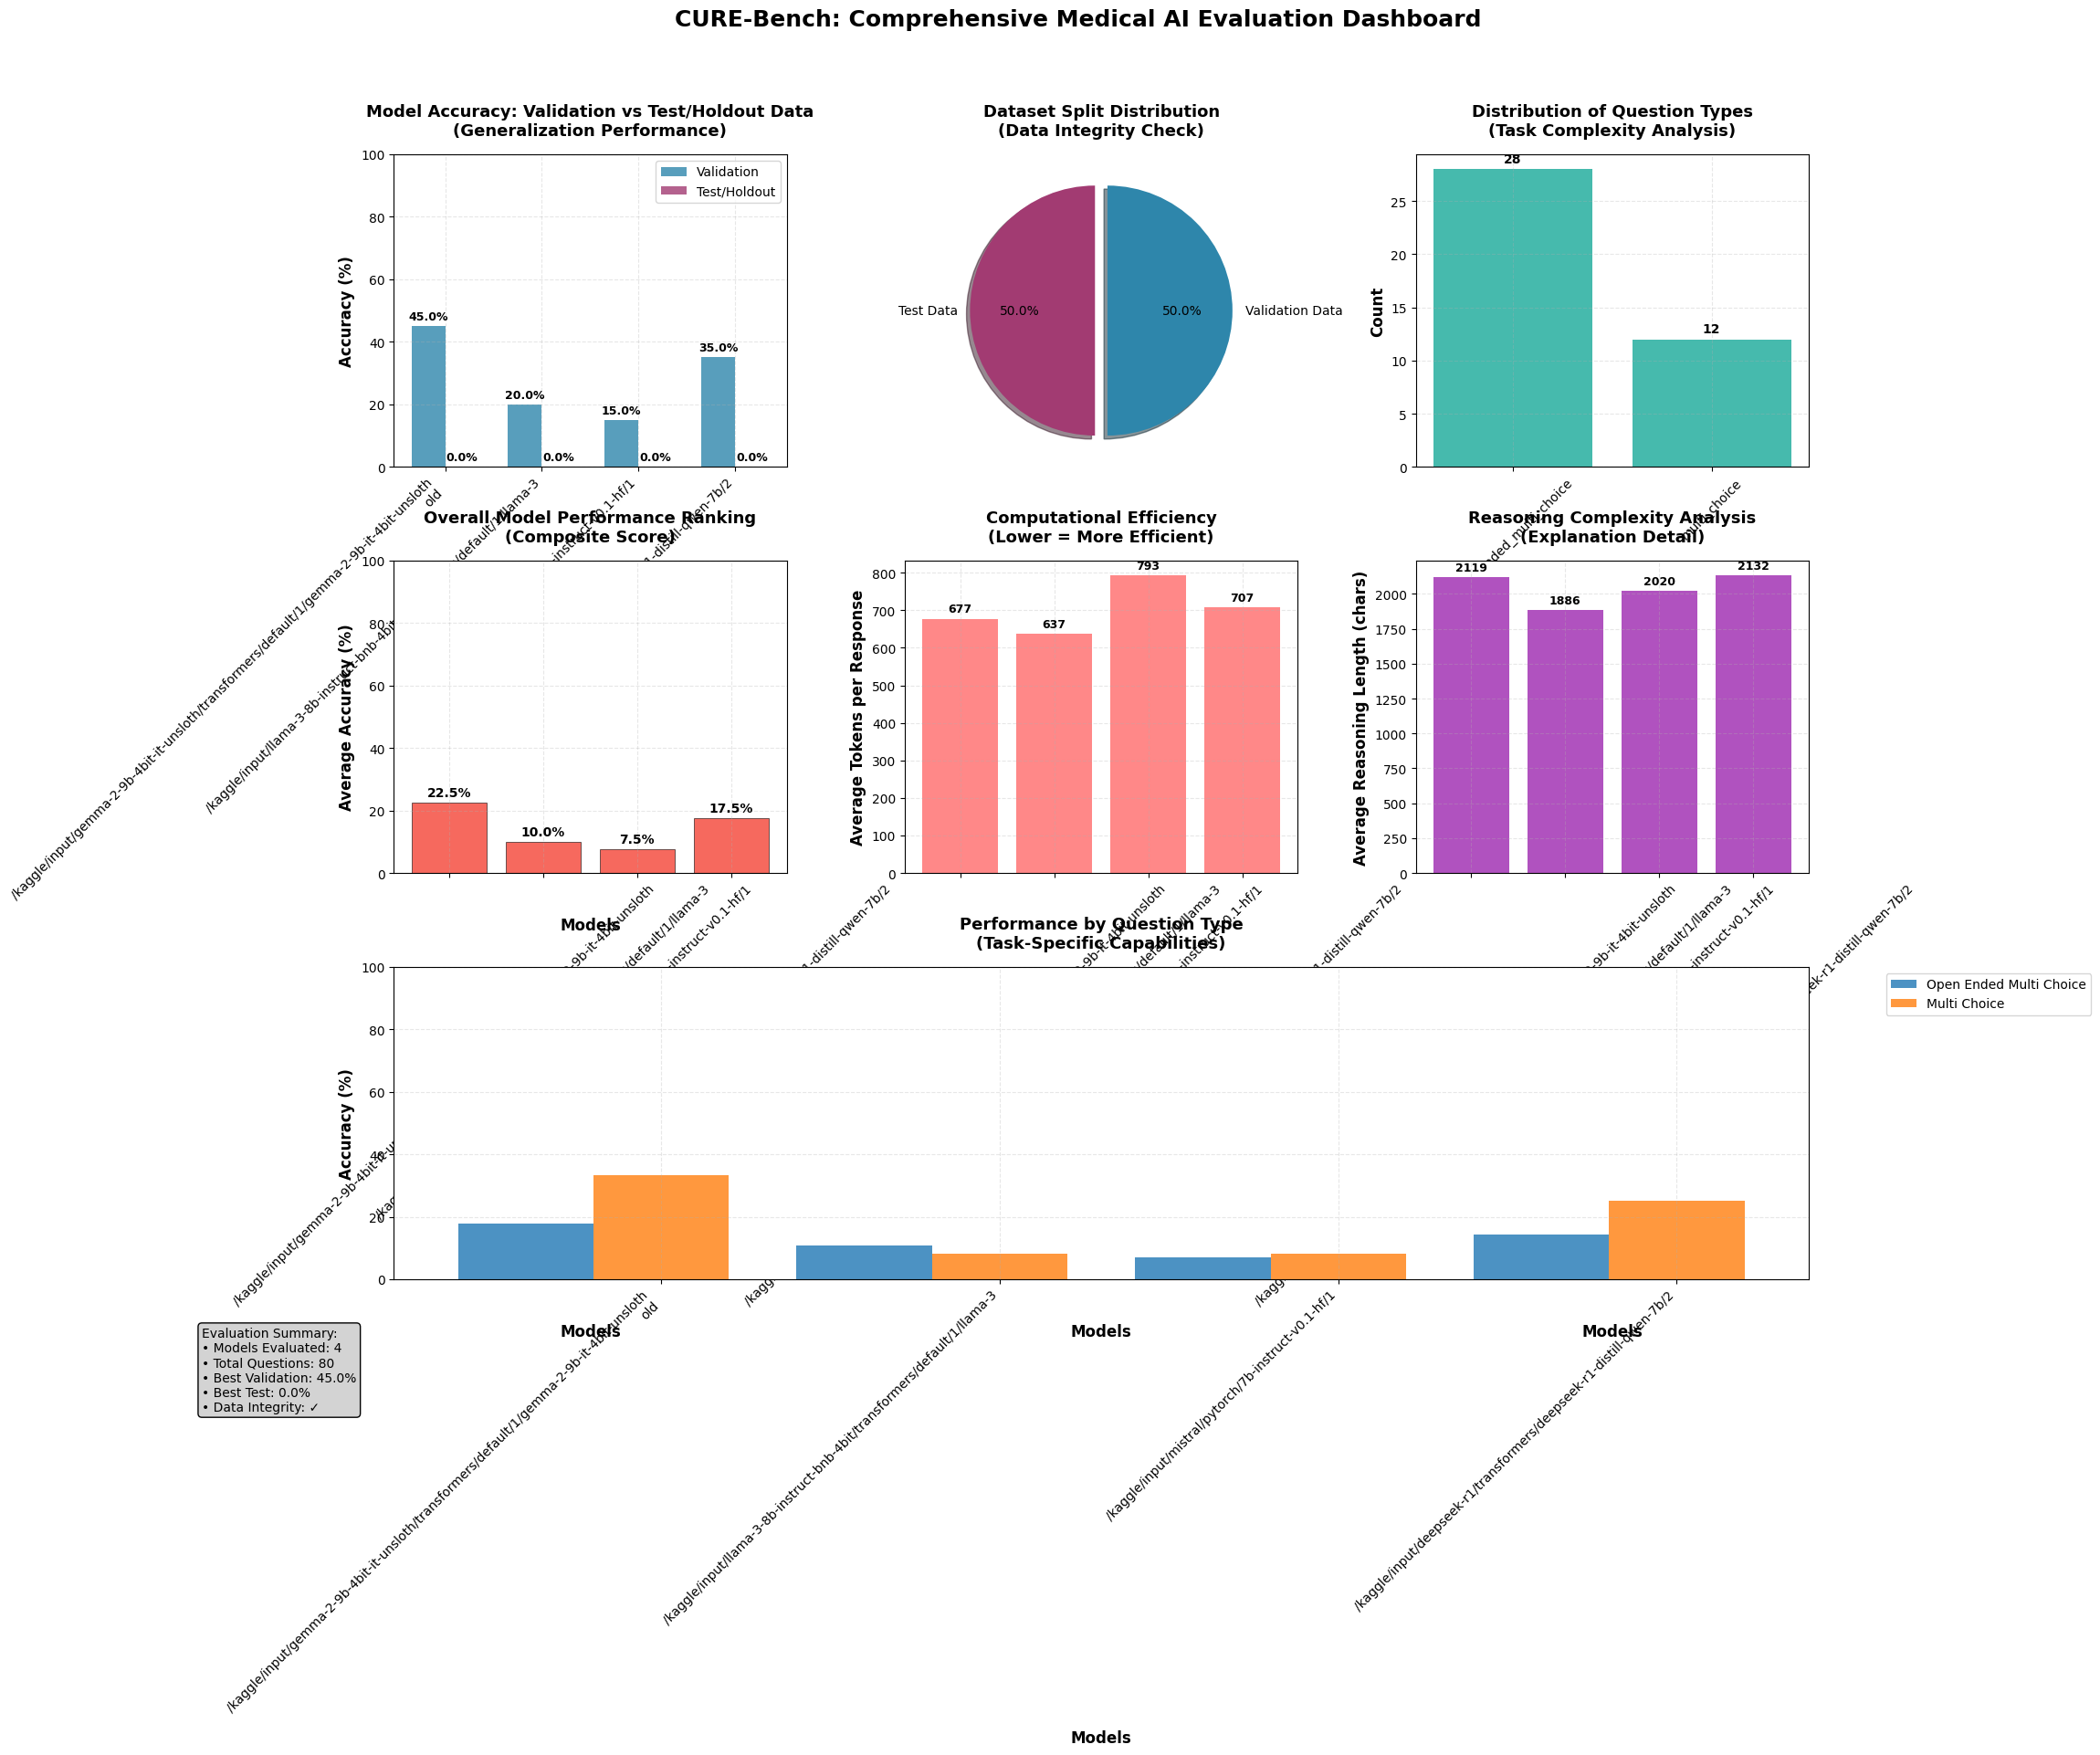

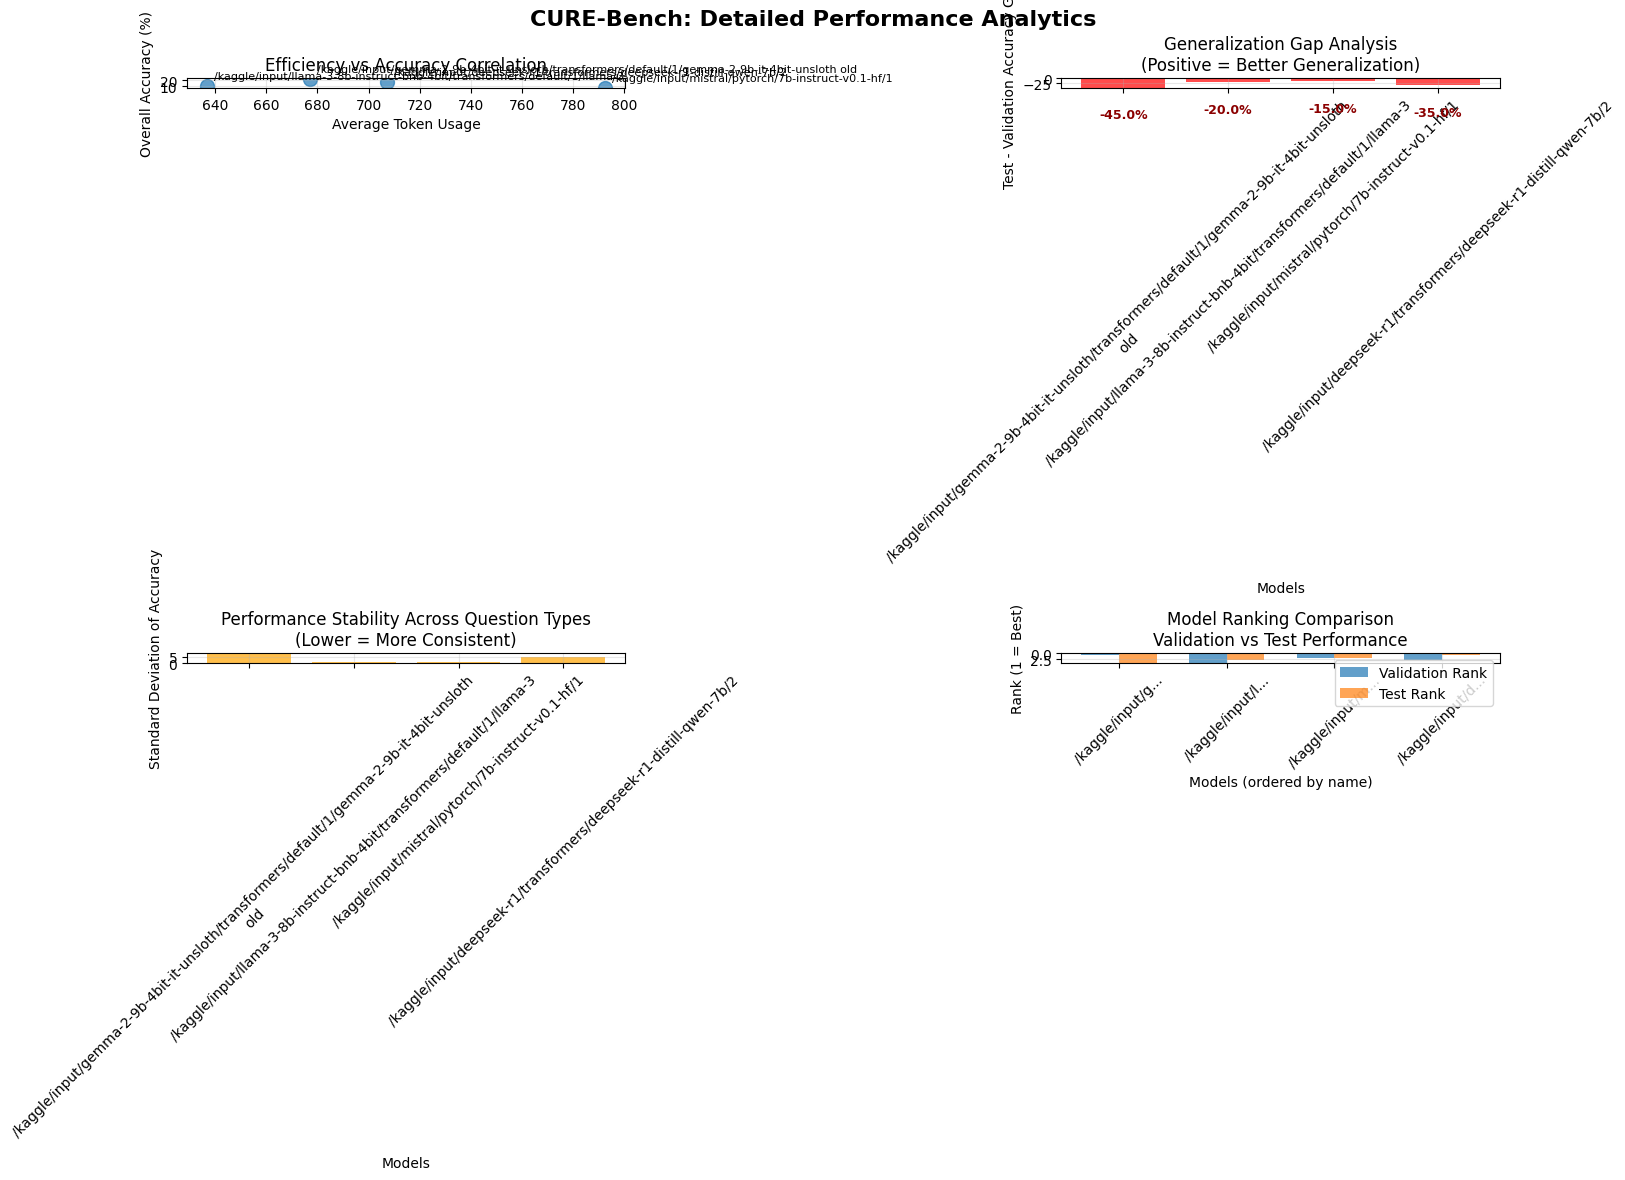


COMPREHENSIVE PERFORMANCE SUMMARY
 BEST VALIDATION PERFORMANCE: /kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old (45.00%)
 BEST TEST PERFORMANCE: /kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old (0.00%)
 MOST EFFICIENT MODEL: /kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1/llama-3 (637 avg tokens)
 AVERAGE VALIDATION ACCURACY: 28.75% ± 11.92%
 AVERAGE TEST ACCURACY: 0.00% ± 0.00%
 GENERALIZATION GAP: -28.75%
 Results saved to cure_bench_results.json

 EVALUATION COMPLETED SUCCESSFULLY!
Results available for 4 models

 Performing final cleanup...
 Cleanup completed


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
CURE-Bench Internal Reasoning Pipeline - Drug Decision-Making and Treatment Planning
Evaluates AI models on clinically grounded tasks with internal reasoning capabilities.
"""

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import sys
import json
import torch
import psutil
import platform
import subprocess
from pathlib import Path
import time
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import zipfile
import matplotlib.pyplot as plt
from collections import Counter

# Set environment variable to enable expandable segments for memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")
print("Starting CURE-Bench Internal Reasoning Pipeline")
print("================================================================================")

# Function to safely install a package
def install_package(package):
    """Installs a given Python package using pip."""
    try:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", package, "--no-cache-dir"])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError as e:
        print(f"✗ Failed to install {package}: {e}")
        raise

# Check for environment and install dependencies
is_colab = "COLAB_" in "".join(os.environ.keys())
is_kaggle = "KAGGLE_" in "".join(os.environ.keys())
print(f"Environment detected: {'Google Colab' if is_colab else 'Kaggle' if is_kaggle else 'Local'}")

def fix_dependencies():
    """Fix dependency conflicts and install compatible versions."""
    try:
        print("\n--- Fixing dependency conflicts ---")
        
        # First, uninstall problematic packages
        subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "transformers", "unsloth"], 
                      capture_output=True)
        
        # Install compatible versions in correct order
        print("Installing compatible transformers version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "transformers==4.44.2", "--no-cache-dir"])
        
        print("Installing accelerate and bitsandbytes...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "accelerate>=0.21.0", "bitsandbytes>=0.41.0", "--no-cache-dir"])
        
        print("Installing datasets and other dependencies...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "datasets", "peft", "trl", "--no-cache-dir"])
        
        # Try to install unsloth if possible
        try:
            if is_colab:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git", 
                                     "--no-cache-dir"])
            else:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth", "--no-cache-dir"])
            print("✓ Unsloth installed successfully")
        except subprocess.CalledProcessError:
            print(" Unsloth installation failed, will use standard transformers only")
        
        print("✓ Dependencies fixed successfully.")
        return True
        
    except subprocess.CalledProcessError as e:
        print(f"✗ Dependency fixing failed: {e}")
        return False

# Fix dependencies
print("Attempting to fix dependency conflicts...")
fix_dependencies()

# Import libraries with error handling
try:
    import torch
    print(f"✓ PyTorch {torch.__version__} loaded")
    
    import transformers
    print(f"✓ Transformers {transformers.__version__} loaded")
    
    from transformers import (
        AutoModelForCausalLM, 
        AutoTokenizer, 
        BitsAndBytesConfig, 
        AutoConfig
    )
    print("✓ Core transformers components loaded")
    
    # Try to import unsloth components
    try:
        from unsloth import FastLanguageModel
        UNSLOTH_AVAILABLE = True
        print("✓ Unsloth is available")
    except ImportError as e:
        print(f"⚠ Unsloth not available: {e}")
        UNSLOTH_AVAILABLE = False
        
except ImportError as e:
    print(f"✗ Import error: {e}")
    print("Continuing with basic imports...")
    import torch
    import transformers
    from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
    UNSLOTH_AVAILABLE = False

# System information
print(f"\nSystem Information:")
print(f"  Python version: {sys.version}")
print(f"  PyTorch version: {torch.__version__}")
print(f"  Transformers version: {transformers.__version__}")
print(f"  Platform: {platform.platform()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
print("================================================================================")

def get_system_status():
    """Gets and prints the current system memory status."""
    cpu_mem = psutil.virtual_memory()
    if torch.cuda.is_available():
        gpu_mem = torch.cuda.memory_stats()
        print("  Memory Status:")
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")
        print(f"    GPU: {gpu_mem['allocated_bytes.all.current'] / (1024**3):.1f}GB/{torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f}GB")
    else:
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")

def find_model_directory(base_path):
    """Find the actual model directory containing config.json."""
    print(f"Searching for model directory in: {base_path}")
    
    # Check if config.json is directly in the base path
    if os.path.exists(os.path.join(base_path, "config.json")):
        print(f"Found config.json directly in: {base_path}")
        return base_path
    
    # Search recursively for config.json
    for root, dirs, files in os.walk(base_path):
        if "config.json" in files:
            print(f"Found config.json in: {root}")
            return root
    
    print(f"No config.json found in: {base_path}")
    return None

def load_model_config(model_path):
    """Load and analyze model configuration."""
    config_path = os.path.join(model_path, "config.json")
    if not os.path.exists(config_path):
        return None
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    return config

def create_bnb_config(load_in_4bit=True, load_in_8bit=False):
    """Create BitsAndBytesConfig for quantization."""
    try:
        from transformers import BitsAndBytesConfig
        
        if load_in_4bit:
            return BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
            )
        elif load_in_8bit:
            return BitsAndBytesConfig(load_in_8bit=True)
        else:
            return None
    except ImportError:
        print("BitsAndBytesConfig not available")
        return None

def load_model_with_strategies(model_path, model_name):
    """Load model using multiple fallback strategies."""
    print(f"Attempting to load {model_name} from {model_path}")
    
    # Load configuration first
    config = load_model_config(model_path)
    if config is None:
        print("Could not load model configuration")
        return None, None
    
    model_type = config.get('model_type', 'unknown')
    print(f"Model type: {model_type}")
    
    # Skip unsupported architectures
    if model_type == "gpt_oss":
        print(f"Skipping {model_name}: 'gpt_oss' architecture requires custom code")
        return None, None
    
    # Strategy 1: Try Unsloth if available
    if UNSLOTH_AVAILABLE:
        try:
            print("Attempting to load with Unsloth...")
            model, tokenizer = FastLanguageModel.from_pretrained(
                model_name=model_path,
                max_seq_length=2048,
                dtype=None,
                load_in_4bit=True,
                trust_remote_code=True
            )
            print("✓ Model loaded successfully with Unsloth!")
            return tokenizer, model
        except Exception as e:
            print(f"Unsloth loading failed: {e}")
            print("Falling back to standard transformers...")
    
    # Fallback strategies using standard transformers
    strategies = [
        {
            "name": "4-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_4bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "8-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_8bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "Standard loading with auto device mapping",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "CPU loading",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "cpu",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        }
    ]
    
    # Load tokenizer first
    tokenizer = None
    try:
        print("Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(
            model_path, 
            trust_remote_code=True,
            use_fast=False  # Use slow tokenizer for better compatibility
        )
        
        # Add padding token if missing
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            print("Added padding token")
            
        print("✓ Tokenizer loaded successfully")
    except Exception as e:
        print(f"Tokenizer loading failed: {e}")
        return None, None
    
    # Try each model loading strategy
    for i, strategy in enumerate(strategies, 1):
        try:
            print(f"Attempting strategy {i}: {strategy['name']}")
            
            # Clear cache before each attempt
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            # Filter out None values from config
            model_config = {k: v for k, v in strategy['model_config'].items() if v is not None}
            
            model = AutoModelForCausalLM.from_pretrained(model_path, **model_config)
            print(f"✓ Model loaded successfully using strategy {i}!")
            return tokenizer, model
            
        except Exception as e:
            print(f"Strategy {i} failed: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            continue
    
    print("All loading strategies failed.")
    return tokenizer, None

def verify_data_splits(test_data: List[Dict], val_data: List[Dict]) -> Dict:
    """Verify data splits and provide comprehensive statistics."""
    print("\n=== DATA SPLIT VERIFICATION ===")
    
    verification_stats = {
        "test_data": {
            "total_samples": len(test_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in test_data)),
            "sample_questions": []
        },
        "val_data": {
            "total_samples": len(val_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in val_data)),
            "sample_questions": []
        },
        "overlap": {
            "overlapping_ids": 0,
            "common_ids": []
        }
    }
    
    # Analyze test data
    test_ids = set()
    for item in test_data:
        item_id = item.get('id', '')
        test_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["test_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["test_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["test_data"]["sample_questions"]) < 3:
            verification_stats["test_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Analyze validation data
    val_ids = set()
    for item in val_data:
        item_id = item.get('id', '')
        val_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["val_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["val_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["val_data"]["sample_questions"]) < 3:
            verification_stats["val_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Check for overlap
    common_ids = test_ids.intersection(val_ids)
    verification_stats["overlap"]["overlapping_ids"] = len(common_ids)
    verification_stats["overlap"]["common_ids"] = list(common_ids)[:10]  # Store first 10
    
    # Print verification results
    print(f"TEST DATA:")
    print(f"  Total samples: {verification_stats['test_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['test_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['test_data']['has_correct_answers']}")
    print(f"  Question types: {dict(verification_stats['test_data']['question_types'])}")
    
    print(f"\nVALIDATION DATA:")
    print(f"  Total samples: {verification_stats['val_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['val_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['val_data']['has_correct_answers']}")
    print(f"  Question types: {dict(verification_stats['val_data']['question_types'])}")
    
    print(f"\nOVERLAP ANALYSIS:")
    print(f"  Overlapping IDs: {verification_stats['overlap']['overlapping_ids']}")
    if verification_stats['overlap']['overlapping_ids'] > 0:
        print(f"  Common IDs (first 10): {verification_stats['overlap']['common_ids']}")
    
    print(f"\nDATA INTEGRITY:")
    print(f"  Test data integrity: {'✓ PASS' if verification_stats['test_data']['total_samples'] == verification_stats['test_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Validation data integrity: {'✓ PASS' if verification_stats['val_data']['total_samples'] == verification_stats['val_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Split integrity: {'✓ PASS - No overlap' if verification_stats['overlap']['overlapping_ids'] == 0 else '⚠ WARNING - Data leakage detected'}")
    
    return verification_stats

def plot_overall_accuracies(model_results: Dict, verification_stats: Dict) -> None:
    """Evaluate and graphically plot overall accuracies including unseen/test/holdout data."""
    print("\n=== PLOTTING OVERALL ACCURACIES ===")
    
    # Prepare data for plotting
    model_names = []
    val_accuracies = []
    test_accuracies = []
    total_questions = []
    
    # Additional metrics for enhanced plots
    token_usage_per_model = []
    reasoning_lengths_per_model = []
    question_type_accuracies = {}
    
    for model_name, results in model_results.items():
        model_names.append(model_name.replace('_', '\n'))  # Format for better display
        
        # Calculate validation accuracy
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        
        # Additional metrics
        total_tokens = 0
        total_reasoning_length = 0
        question_type_stats = {}
        
        for result in results:
            if 'error' not in result and result.get('correct_answer') and result.get('prediction'):
                # Determine if this is from validation or test set based on data split info
                if result.get('data_split') == 'validation':
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
                elif result.get('data_split') == 'test':
                    test_total += 1
                    if result['prediction'] == result['correct_answer']:
                        test_correct += 1
                else:
                    # If no split info, assume validation data (has correct answers)
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
            
            # Collect token usage and reasoning length
            if 'token_usage' in result:
                total_tokens += result['token_usage'].get('total_tokens', 0)
            if 'reasoning_trace' in result:
                total_reasoning_length += len(result['reasoning_trace'])
            
            # Collect question type statistics
            q_type = result.get('question_type', 'unknown')
            if q_type not in question_type_stats:
                question_type_stats[q_type] = {'correct': 0, 'total': 0}
            
            if result.get('is_correct', False):
                question_type_stats[q_type]['correct'] += 1
            question_type_stats[q_type]['total'] += 1
        
        val_accuracy = (val_correct / val_total * 100) if val_total > 0 else 0
        test_accuracy = (test_correct / test_total * 100) if test_total > 0 else 0
        
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
        total_questions.append(val_total + test_total)
        
        # Store additional metrics
        avg_tokens = total_tokens / len(results) if results else 0
        avg_reasoning_length = total_reasoning_length / len(results) if results else 0
        token_usage_per_model.append(avg_tokens)
        reasoning_lengths_per_model.append(avg_reasoning_length)
        
        # Store question type accuracies
        for q_type, stats in question_type_stats.items():
            if q_type not in question_type_accuracies:
                question_type_accuracies[q_type] = []
            accuracy = (stats['correct'] / stats['total'] * 100) if stats['total'] > 0 else 0
            question_type_accuracies[q_type].append(accuracy)
        
        print(f"{model_name}:")
        print(f"  Validation: {val_correct}/{val_total} = {val_accuracy:.2f}%")
        print(f"  Test: {test_correct}/{test_total} = {test_accuracy:.2f}%")
        print(f"  Avg Tokens: {avg_tokens:.0f}")
        print(f"  Avg Reasoning Length: {avg_reasoning_length:.0f} chars")
    
    # Create comprehensive plots with enhanced layout
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle('CURE-Bench: Comprehensive Medical AI Evaluation Dashboard', 
                fontsize=18, fontweight='bold', y=0.98)
    
    # Create a grid for better organization
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: Accuracy Comparison (top-left)
    ax1 = fig.add_subplot(gs[0, 0])
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, val_accuracies, width, label='Validation', alpha=0.8, color='#2E86AB')
    bars2 = ax1.bar(x + width/2, test_accuracies, width, label='Test/Holdout', alpha=0.8, color='#A23B72')
    
    ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Model Accuracy: Validation vs Test/Holdout Data\n(Generalization Performance)', 
                 fontsize=13, fontweight='bold', pad=15)
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    for bar in bars2:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 2: Data Distribution (top-middle)
    ax2 = fig.add_subplot(gs[0, 1])
    test_samples = verification_stats['test_data']['total_samples']
    val_samples = verification_stats['val_data']['total_samples']
    
    labels = ['Test Data', 'Validation Data']
    sizes = [test_samples, val_samples]
    colors = ['#A23B72', '#2E86AB']
    explode = (0.05, 0.05)
    
    wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors, explode=explode,
                                      autopct='%1.1f%%', startangle=90, shadow=True)
    ax2.set_title('Dataset Split Distribution\n(Data Integrity Check)', fontsize=13, fontweight='bold', pad=15)
    
    # Plot 3: Question Type Distribution (top-right)
    ax3 = fig.add_subplot(gs[0, 2])
    all_question_types = Counter()
    all_question_types.update(verification_stats['test_data']['question_types'])
    all_question_types.update(verification_stats['val_data']['question_types'])
    
    if all_question_types:
        q_types = list(all_question_types.keys())
        q_counts = list(all_question_types.values())
        
        bars = ax3.bar(q_types, q_counts, color='#18A999', alpha=0.8)
        ax3.set_xlabel('Question Types', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Count', fontsize=12, fontweight='bold')
        ax3.set_title('Distribution of Question Types\n(Task Complexity Analysis)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax3.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 4: Performance Summary (middle-left)
    ax4 = fig.add_subplot(gs[1, 0])
    if model_names:
        overall_accuracies = [(val + test) / 2 for val, test in zip(val_accuracies, test_accuracies)]
        colors_perf = ['#4CAF50' if acc >= 70 else '#FF9800' if acc >= 50 else '#F44336' for acc in overall_accuracies]
        
        bars = ax4.bar(model_names, overall_accuracies, color=colors_perf, alpha=0.8, edgecolor='black', linewidth=0.5)
        ax4.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Average Accuracy (%)', fontsize=12, fontweight='bold')
        ax4.set_title('Overall Model Performance Ranking\n(Composite Score)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3, linestyle='--')
        ax4.set_ylim(0, 100)
        
        # Add value labels
        for bar, acc in zip(bars, overall_accuracies):
            height = bar.get_height()
            ax4.annotate(f'{acc:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 5: Token Usage Efficiency (middle-middle)
    ax5 = fig.add_subplot(gs[1, 1])
    if token_usage_per_model:
        bars = ax5.bar(model_names, token_usage_per_model, color='#FF6B6B', alpha=0.8)
        ax5.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax5.set_ylabel('Average Tokens per Response', fontsize=12, fontweight='bold')
        ax5.set_title('Computational Efficiency\n(Lower = More Efficient)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax5.tick_params(axis='x', rotation=45)
        ax5.grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels
        for bar, tokens in zip(bars, token_usage_per_model):
            height = bar.get_height()
            ax5.annotate(f'{tokens:.0f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 6: Reasoning Length Analysis (middle-right)
    ax6 = fig.add_subplot(gs[1, 2])
    if reasoning_lengths_per_model:
        bars = ax6.bar(model_names, reasoning_lengths_per_model, color='#9C27B0', alpha=0.8)
        ax6.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax6.set_ylabel('Average Reasoning Length (chars)', fontsize=12, fontweight='bold')
        ax6.set_title('Reasoning Complexity Analysis\n(Explanation Detail)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax6.tick_params(axis='x', rotation=45)
        ax6.grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels
        for bar, length in zip(bars, reasoning_lengths_per_model):
            height = bar.get_height()
            ax6.annotate(f'{length:.0f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 7: Question Type Performance (bottom row)
    if question_type_accuracies:
        ax7 = fig.add_subplot(gs[2, :])
        
        # Prepare data for grouped bar chart
        q_types = list(question_type_accuracies.keys())
        x_pos = np.arange(len(model_names))
        width = 0.8 / len(q_types)
        
        for i, q_type in enumerate(q_types):
            offsets = x_pos + (i - len(q_types)/2) * width
            ax7.bar(offsets, question_type_accuracies[q_type], width, 
                   label=q_type.replace('_', ' ').title(), alpha=0.8)
        
        ax7.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax7.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
        ax7.set_title('Performance by Question Type\n(Task-Specific Capabilities)', 
                     fontsize=13, fontweight='bold', pad=15)
        ax7.set_xticks(x_pos)
        ax7.set_xticklabels(model_names, rotation=45, ha='right')
        ax7.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax7.grid(True, alpha=0.3, linestyle='--')
        ax7.set_ylim(0, 100)
    
    # Add summary statistics as text
    fig.text(0.02, 0.02, 
             f'Evaluation Summary:\n'
             f'• Models Evaluated: {len(model_names)}\n'
             f'• Total Questions: {sum(total_questions)}\n'
             f'• Best Validation: {max(val_accuracies):.1f}%\n'
             f'• Best Test: {max(test_accuracies):.1f}%\n'
             f'• Data Integrity: {"✓" if verification_stats["overlap"]["overlapping_ids"] == 0 else "⚠"}',
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    plt.tight_layout()
    plt.show()
    
    # Create additional detailed analysis plot
    if model_names and len(model_names) > 1:
        fig2, ((ax21, ax22), (ax23, ax24)) = plt.subplots(2, 2, figsize=(16, 12))
        fig2.suptitle('CURE-Bench: Detailed Performance Analytics', fontsize=16, fontweight='bold')
        
        # Correlation between token usage and accuracy
        ax21.scatter(token_usage_per_model, overall_accuracies, s=100, alpha=0.7)
        for i, model in enumerate(model_names):
            ax21.annotate(model.replace('\n', ' '), 
                         (token_usage_per_model[i], overall_accuracies[i]),
                         xytext=(5, 5), textcoords='offset points', fontsize=8)
        ax21.set_xlabel('Average Token Usage')
        ax21.set_ylabel('Overall Accuracy (%)')
        ax21.set_title('Efficiency vs Accuracy Correlation')
        ax21.grid(True, alpha=0.3)
        
        # Performance gap analysis
        performance_gaps = [test - val for val, test in zip(val_accuracies, test_accuracies)]
        bars = ax22.bar(model_names, performance_gaps, 
                       color=['green' if gap >= 0 else 'red' for gap in performance_gaps],
                       alpha=0.7)
        ax22.set_xlabel('Models')
        ax22.set_ylabel('Test - Validation Accuracy Gap')
        ax22.set_title('Generalization Gap Analysis\n(Positive = Better Generalization)')
        ax22.tick_params(axis='x', rotation=45)
        ax22.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, gap in zip(bars, performance_gaps):
            height = bar.get_height()
            ax22.annotate(f'{gap:+.1f}%',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3 if height >= 0 else -15),
                         textcoords="offset points",
                         ha='center', va='bottom' if height >= 0 else 'top',
                         fontsize=9, fontweight='bold',
                         color='darkgreen' if height >= 0 else 'darkred')
        
        # Accuracy stability across question types
        if question_type_accuracies:
            stability_data = []
            for i, model in enumerate(model_names):
                accuracies = [qt[i] for qt in question_type_accuracies.values() if i < len(qt)]
                stability = np.std(accuracies) if accuracies else 0
                stability_data.append(stability)
            
            ax23.bar(model_names, stability_data, color='orange', alpha=0.7)
            ax23.set_xlabel('Models')
            ax23.set_ylabel('Standard Deviation of Accuracy')
            ax23.set_title('Performance Stability Across Question Types\n(Lower = More Consistent)')
            ax23.tick_params(axis='x', rotation=45)
            ax23.grid(True, alpha=0.3)
        
        # Model ranking comparison
        val_ranks = np.argsort(val_accuracies)[::-1]
        test_ranks = np.argsort(test_accuracies)[::-1]
        
        x_pos = np.arange(len(model_names))
        width = 0.35
        ax24.bar(x_pos - width/2, val_ranks + 1, width, label='Validation Rank', alpha=0.7)
        ax24.bar(x_pos + width/2, test_ranks + 1, width, label='Test Rank', alpha=0.7)
        ax24.set_xlabel('Models (ordered by name)')
        ax24.set_ylabel('Rank (1 = Best)')
        ax24.set_title('Model Ranking Comparison\nValidation vs Test Performance')
        ax24.set_xticks(x_pos)
        ax24.set_xticklabels([m[:15] + '...' if len(m) > 15 else m for m in model_names], rotation=45)
        ax24.legend()
        ax24.grid(True, alpha=0.3)
        ax24.invert_yaxis()  # So rank 1 is at top
        
        plt.tight_layout()
        plt.show()
    
    # Print summary statistics
    print(f"\n{'='*60}")
    print("COMPREHENSIVE PERFORMANCE SUMMARY")
    print(f"{'='*60}")
    
    if model_names:
        best_val_idx = np.argmax(val_accuracies)
        best_test_idx = np.argmax(test_accuracies)
        most_efficient_idx = np.argmin(token_usage_per_model) if token_usage_per_model else 0
        
        print(f" BEST VALIDATION PERFORMANCE: {model_names[best_val_idx].replace(chr(10), '_')} ({val_accuracies[best_val_idx]:.2f}%)")
        print(f" BEST TEST PERFORMANCE: {model_names[best_test_idx].replace(chr(10), '_')} ({test_accuracies[best_test_idx]:.2f}%)")
        print(f" MOST EFFICIENT MODEL: {model_names[most_efficient_idx].replace(chr(10), '_')} ({token_usage_per_model[most_efficient_idx]:.0f} avg tokens)")
        print(f" AVERAGE VALIDATION ACCURACY: {np.mean(val_accuracies):.2f}% ± {np.std(val_accuracies):.2f}%")
        print(f" AVERAGE TEST ACCURACY: {np.mean(test_accuracies):.2f}% ± {np.std(test_accuracies):.2f}%")
        print(f" GENERALIZATION GAP: {np.mean(test_accuracies) - np.mean(val_accuracies):+.2f}%")
        
        if verification_stats['overlap']['overlapping_ids'] > 0:
            print(f"  DATA LEAKAGE WARNING: {verification_stats['overlap']['overlapping_ids']} overlapping samples detected!")

def load_cure_bench_data(dataset_paths: Dict[str, str]) -> Tuple[List[Dict], List[Dict]]:
    """Load CURE-Bench test and validation datasets."""
    test_data = []
    val_data = []
    
    # Load test data
    test_path = dataset_paths.get('test', '')
    if test_path and os.path.exists(test_path):
        with open(test_path, 'r') as f:
            for line in f:
                data_item = json.loads(line.strip())
                data_item['data_split'] = 'test'  # Mark data split
                test_data.append(data_item)
        print(f"✓ Loaded {len(test_data)} test samples")
    else:
        print(f"✗ Test file not found at {test_path}")
    
    # Load validation data
    val_path = dataset_paths.get('val', '')
    if val_path and os.path.exists(val_path):
        with open(val_path, 'r') as f:
            for line in f:
                data_item = json.loads(line.strip())
                data_item['data_split'] = 'validation'  # Mark data split
                val_data.append(data_item)
        print(f"✓ Loaded {len(val_data)} validation samples")
    else:
        print(f"✗ Validation file not found at {val_path}")
    
    return test_data, val_data

def create_medical_reasoning_prompt(question_data: Dict) -> str:
    """Create a structured prompt for medical reasoning tasks."""
    question_type = question_data.get('question_type', '')
    question = question_data.get('question', '')
    options = question_data.get('options', {})
    
    if question_type == 'multi_choice' or question_type == 'open_ended_multi_choice':
        prompt = f"""You are a medical AI assistant specializing in drug decision-making and treatment planning. Please analyze the following clinical scenario and provide your reasoning step by step.

Clinical Scenario:
{question}

Available Options:
"""
        for key, value in options.items():
            prompt += f"{key}: {value}\n"
        
        prompt += """
Please provide your analysis using the following structure:

1. PATIENT ASSESSMENT:
   - Analyze the patient's condition, age, and relevant medical history
   - Identify key clinical factors and contraindications

2. DRUG ANALYSIS:
   - Evaluate each treatment option
   - Consider pharmacokinetics, pharmacodynamics, and drug interactions
   - Assess safety and efficacy profiles

3. CLINICAL REASONING:
   - Apply medical guidelines and best practices
   - Consider patient-specific factors
   - Evaluate risk-benefit ratios

4. FINAL DECISION:
   - State your chosen answer
   - Provide clear justification

Answer: """
    else:
        prompt = f"""You are a medical AI assistant. Please analyze this clinical question and provide detailed reasoning:

Question: {question}

Please provide comprehensive clinical reasoning for your answer."""
    
    return prompt

def evaluate_medical_reasoning(tokenizer, model, question_data: Dict, max_new_tokens: int = 512) -> Dict:
    """Evaluate model's medical reasoning capabilities."""
    try:
        question_id = question_data.get('id', 'unknown')
        print(f"\n--- Evaluating Question ID: {question_id} ---")
        
        # Create structured prompt
        prompt = create_medical_reasoning_prompt(question_data)
        
        # Track token usage
        input_tokens = len(tokenizer.encode(prompt))
        
        # Tokenize input
        inputs = tokenizer(
            prompt, 
            return_tensors="pt", 
            padding=True, 
            truncation=True,
            max_length=2048
        )
        
        # Move to model device
        if hasattr(model, 'device'):
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        print("Generating medical reasoning...")
        
        # Generate response - FIXED: Removed duplicate do_sample parameter
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.1,  # Lower temperature for more consistent medical reasoning
                top_p=0.9,
                repetition_penalty=1.1,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                early_stopping=True
            )
        
        # Decode response
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        reasoning_trace = full_response[len(prompt):].strip()
        
        # Calculate token usage
        output_tokens = len(tokenizer.encode(reasoning_trace))
        total_tokens = input_tokens + output_tokens

        # Extract final answer from reasoning trace
        prediction = extract_answer_from_reasoning(reasoning_trace, question_data)
        
        # Create evaluation result
        result = {
            'id': question_id,
            'question_type': question_data.get('question_type', ''),
            'question': question_data.get('question', ''),
            'correct_answer': question_data.get('correct_answer', ''),
            'prediction': prediction,
            'reasoning_trace': reasoning_trace,
            'token_usage': {
                'input_tokens': input_tokens,
                'output_tokens': output_tokens,
                'total_tokens': total_tokens
            },
            'data_split': question_data.get('data_split', 'unknown')
        }
        
        print(f"Question: {question_data.get('question', '')[:100]}...")
        print(f"Predicted Answer: {prediction}")
        if question_data.get('correct_answer'):
            print(f"Correct Answer: {question_data.get('correct_answer')}")
            is_correct = prediction == question_data.get('correct_answer')
            print(f"Result: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}")
            result['is_correct'] = is_correct
        print(f"Tokens Used: {total_tokens} (Input: {input_tokens}, Output: {output_tokens})")
        
        return result
        
    except Exception as e:
        print(f"Error evaluating question {question_data.get('id', 'unknown')}: {e}")
        return {
            'id': question_data.get('id', 'unknown'),
            'error': str(e),
            'question_type': question_data.get('question_type', ''),
            'data_split': question_data.get('data_split', 'unknown')
        }

def extract_answer_from_reasoning(reasoning_trace: str, question_data: Dict) -> str:
    """Extract the final answer from the model's reasoning trace."""
    question_type = question_data.get('question_type', '')
    options = question_data.get('options', {})
    
    # Clean the reasoning trace
    reasoning_lower = reasoning_trace.lower().strip()
    
    # For multiple choice questions
    if question_type in ['multi_choice', 'open_ended_multi_choice'] and options:
        # Look for explicit answer patterns
        answer_patterns = [
            r"answer:\s*([a-e])",
            r"final answer:\s*([a-e])",
            r"my answer is\s*([a-e])",
            r"the answer is\s*([a-e])",
            r"i choose\s*([a-e])",
            r"option\s*([a-e])",
            r"^([a-e])[\.\)\:]",  # Answer at start of line
            r"\b([a-e])[\.\)\:]"   # Answer with punctuation
        ]
        
        for pattern in answer_patterns:
            import re
            match = re.search(pattern, reasoning_lower)
            if match:
                answer = match.group(1).upper()
                if answer in options:
                    return answer
        
        # Look for option content in reasoning
        for option_key, option_value in options.items():
            option_words = option_value.lower().split()
            # Check if significant portion of option appears in reasoning
            word_matches = sum(1 for word in option_words if word in reasoning_lower)
            if len(option_words) > 0 and word_matches / len(option_words) > 0.5:
                return option_key.upper()
        
        # Fallback: return first valid option mentioned
        for option in ['A', 'B', 'C', 'D', 'E']:
            if option.lower() in reasoning_lower and option in options:
                return option
    
    # For open-ended questions, extract the most relevant sentence
    else:
        # Look for definitive statements
        sentences = reasoning_trace.split('.')
        for sentence in sentences:
            sentence = sentence.strip()
            if any(phrase in sentence.lower() for phrase in [
                'recommend', 'should', 'best', 'appropriate', 'indicated', 
                'treatment', 'drug', 'medication', 'therapy'
            ]):
                return sentence[:200]  # Limit length
    
    # Ultimate fallback
    return reasoning_trace[:100] if reasoning_trace else "Unable to extract answer"

def run_cure_bench_evaluation(models_to_evaluate: List[str], dataset_paths: Dict[str, str], 
                             max_samples_per_split: int = None) -> Dict:
    """Run the complete CURE-Bench evaluation pipeline."""
    print(f"\n{'='*80}")
    print("STARTING CURE-BENCH EVALUATION PIPELINE")
    print(f"{'='*80}")
    
    # Load datasets
    print("\n1. LOADING DATASETS")
    test_data, val_data = load_cure_bench_data(dataset_paths)
    
    if not test_data and not val_data:
        print(" No data loaded. Please check your dataset paths.")
        return {}
    
    # Limit samples if specified
    if max_samples_per_split:
        test_data = test_data[:max_samples_per_split]
        val_data = val_data[:max_samples_per_split]
        print(f"Limited to {max_samples_per_split} samples per split")
    
    # Verify data integrity
    verification_stats = verify_data_splits(test_data, val_data)
    
    # Combine datasets for evaluation
    all_data = test_data + val_data
    print(f"Total samples to evaluate: {len(all_data)}")
    
    # Initialize results storage
    all_model_results = {}
    
    # Evaluate each model
    print(f"\n2. MODEL EVALUATION")
    for i, model_name in enumerate(models_to_evaluate, 1):
        print(f"\n{'-'*60}")
        print(f"EVALUATING MODEL {i}/{len(models_to_evaluate)}: {model_name}")
        print(f"{'-'*60}")
        
        # Find and validate model path
        model_path = find_model_directory(model_name)
        if not model_path:
            print(f" Model directory not found for {model_name}")
            continue
        
        # Load model
        tokenizer, model = load_model_with_strategies(model_path, model_name)
        if model is None:
            print(f" Failed to load model {model_name}")
            continue
        
        print(f" Model {model_name} loaded successfully")
        get_system_status()
        
        # Initialize results for this model
        model_results = []
        
        # Evaluate on all data
        print(f"\nEvaluating on {len(all_data)} samples...")
        for j, question_data in enumerate(all_data):
            if j % 10 == 0:
                print(f"Progress: {j}/{len(all_data)} ({j/len(all_data)*100:.1f}%)")
                get_system_status()
            
            # Evaluate single question
            result = evaluate_medical_reasoning(tokenizer, model, question_data)
            model_results.append(result)
            
            # Memory cleanup
            if j % 50 == 0:
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
                gc.collect()
        
        # Store results
        all_model_results[model_name] = model_results
        
        # Calculate and display model performance
        print(f"\n--- {model_name} PERFORMANCE SUMMARY ---")
        correct_predictions = sum(1 for r in model_results if r.get('is_correct', False))
        total_with_answers = sum(1 for r in model_results if 'is_correct' in r)
        accuracy = (correct_predictions / total_with_answers * 100) if total_with_answers > 0 else 0
        
        print(f"Accuracy: {correct_predictions}/{total_with_answers} = {accuracy:.2f}%")
        print(f"Total samples evaluated: {len(model_results)}")
        print(f"Samples with errors: {sum(1 for r in model_results if 'error' in r)}")
        
        # Memory cleanup
        del model, tokenizer
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
    
    # Generate final analysis
    print(f"\n{'='*80}")
    print("GENERATING FINAL ANALYSIS")
    print(f"{'='*80}")
    
    # Create comprehensive plots and analysis
    if all_model_results:
        plot_overall_accuracies(all_model_results, verification_stats)
        
        # Save results to file - FIXED: Convert any sets to lists for JSON serialization
        results_file = "cure_bench_results.json"
        
        # Prepare results for JSON serialization
        serializable_results = {}
        for model_name, results in all_model_results.items():
            serializable_results[model_name] = []
            for result in results:
                # Convert any sets to lists in the result
                serializable_result = {}
                for key, value in result.items():
                    if isinstance(value, set):
                        serializable_result[key] = list(value)
                    else:
                        serializable_result[key] = value
                serializable_results[model_name].append(serializable_result)
        
        # Prepare verification stats for JSON serialization
        serializable_verification_stats = {}
        for key, value in verification_stats.items():
            if isinstance(value, set):
                serializable_verification_stats[key] = list(value)
            elif isinstance(value, dict):
                serializable_verification_stats[key] = {}
                for subkey, subvalue in value.items():
                    if isinstance(subvalue, set):
                        serializable_verification_stats[key][subkey] = list(subvalue)
                    else:
                        serializable_verification_stats[key][subkey] = subvalue
            else:
                serializable_verification_stats[key] = value
        
        with open(results_file, 'w') as f:
            json.dump({
                'evaluation_results': serializable_results,
                'verification_stats': serializable_verification_stats,
                'evaluation_config': {
                    'models_evaluated': models_to_evaluate,  # This is now a list, not a set
                    'dataset_paths': dataset_paths,
                    'max_samples_per_split': max_samples_per_split,
                    'total_samples': len(all_data)
                }
            }, f, indent=2)
        print(f" Results saved to {results_file}")
    
    return all_model_results

# Main execution
if __name__ == "__main__":
    # Configuration - FIXED: Changed from set {} to list [] for JSON serialization
    DATASET_PATHS = {
        'test': '/kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl',
        'val': '/kaggle/input/cure-bench-internal-reasoning/curebench_valset_pharse1.jsonl'
    }
    
    # Model configurations with their paths - FIXED: Changed from set to list
    MODELS_TO_EVALUATE = [
        "/kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old",
        "/kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1/llama-3",
        "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1",
        #"/kaggle/input/qwen-3/transformers/235b-a22b/1",
        "/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2"
    ]
    
    MAX_SAMPLES_PER_SPLIT = 20  # Limit for testing, set to None for full evaluation
    
    # Run evaluation
    try:
        print(" Starting CURE-Bench Medical AI Evaluation")
        results = run_cure_bench_evaluation(
            models_to_evaluate=MODELS_TO_EVALUATE,
            dataset_paths=DATASET_PATHS,
            max_samples_per_split=MAX_SAMPLES_PER_SPLIT
        )
        
        if results:
            print("\n EVALUATION COMPLETED SUCCESSFULLY!")
            print(f"Results available for {len(results)} models")
        else:
            print("\n EVALUATION FAILED - No results generated")
            
    except Exception as e:
        print(f"\n CRITICAL ERROR: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        # Final cleanup
        print("\n Performing final cleanup...")
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
        print(" Cleanup completed")
        print("================================================================================")

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
CURE-Bench Internal Reasoning Pipeline - Drug Decision-Making and Treatment Planning
Evaluates AI models on clinically grounded tasks with internal reasoning capabilities.
"""

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import sys
import json
import torch
import psutil
import platform
import subprocess
from pathlib import Path
import time
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import zipfile
import matplotlib.pyplot as plt
from collections import Counter
import re

# ============================================================================
# FLEXIBLE SAMPLE PROCESSING CONFIGURATION
# ============================================================================
# Set MAX_SAMPLES_PER_SPLIT to control how many samples to process from each split
# Set to None to process all samples, or set to a positive integer to limit samples
MAX_SAMPLES_PER_SPLIT = 10  # Change this value as needed (e.g., 50, 100, None for all)

print(f"SAMPLE PROCESSING CONFIGURATION:")
if MAX_SAMPLES_PER_SPLIT is None:
    print("  Processing: ALL samples from each split")
else:
    print(f"  Processing: Maximum {MAX_SAMPLES_PER_SPLIT} samples per split")
print("=" * 80)

# Set environment variable to enable expandable segments for memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")
print("Starting CURE-Bench Internal Reasoning Pipeline")
print("================================================================================")

# Function to safely install a package
def install_package(package):
    """Installs a given Python package using pip."""
    try:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", package, "--no-cache-dir"])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError as e:
        print(f"✗ Failed to install {package}: {e}")
        raise

# Check for environment and install dependencies
is_colab = "COLAB_" in "".join(os.environ.keys())
is_kaggle = "KAGGLE_" in "".join(os.environ.keys())
print(f"Environment detected: {'Google Colab' if is_colab else 'Kaggle' if is_kaggle else 'Local'}")

def fix_dependencies():
    """Fix dependency conflicts and install compatible versions."""
    try:
        print("\n--- Fixing dependency conflicts ---")
        
        # First, uninstall problematic packages
        subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "transformers", "unsloth"], 
                      capture_output=True)
        
        # Install compatible versions in correct order
        print("Installing compatible transformers version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "transformers==4.44.2", "--no-cache-dir"])
        
        print("Installing accelerate and bitsandbytes...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "accelerate>=0.21.0", "bitsandbytes>=0.41.0", "--no-cache-dir"])
        
        print("Installing datasets and other dependencies...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "datasets", "peft", "trl", "--no-cache-dir"])
        
        # Try to install unsloth if possible
        try:
            if is_colab:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git", 
                                     "--no-cache-dir"])
            else:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth", "--no-cache-dir"])
            print("✓ Unsloth installed successfully")
        except subprocess.CalledProcessError:
            print(" Unsloth installation failed, will use standard transformers only")
        
        print("✓ Dependencies fixed successfully.")
        return True
        
    except subprocess.CalledProcessError as e:
        print(f"✗ Dependency fixing failed: {e}")
        return False

# Fix dependencies
print("Attempting to fix dependency conflicts...")
fix_dependencies()

# Import libraries with error handling
try:
    import torch
    print(f"✓ PyTorch {torch.__version__} loaded")
    
    import transformers
    print(f"✓ Transformers {transformers.__version__} loaded")
    
    from transformers import (
        AutoModelForCausalLM, 
        AutoTokenizer, 
        BitsAndBytesConfig, 
        AutoConfig
    )
    print("✓ Core transformers components loaded")
    
    # Try to import unsloth components
    try:
        from unsloth import FastLanguageModel
        UNSLOTH_AVAILABLE = True
        print("✓ Unsloth is available")
    except ImportError as e:
        print(f"⚠ Unsloth not available: {e}")
        UNSLOTH_AVAILABLE = False
        
except ImportError as e:
    print(f"✗ Import error: {e}")
    print("Continuing with basic imports...")
    import torch
    import transformers
    from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
    UNSLOTH_AVAILABLE = False

# System information
print(f"\nSystem Information:")
print(f"  Python version: {sys.version}")
print(f"  PyTorch version: {torch.__version__}")
print(f"  Transformers version: {transformers.__version__}")
print(f"  Platform: {platform.platform()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
print("================================================================================")

def get_system_status():
    """Gets and prints the current system memory status."""
    cpu_mem = psutil.virtual_memory()
    if torch.cuda.is_available():
        gpu_mem = torch.cuda.memory_stats()
        print("  Memory Status:")
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")
        print(f"    GPU: {gpu_mem['allocated_bytes.all.current'] / (1024**3):.1f}GB/{torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f}GB")
    else:
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")

def load_jsonl_dataset(file_path: str) -> List[Dict]:
    """Load dataset from JSONL file."""
    print(f"Loading dataset from: {file_path}")
    
    if not os.path.exists(file_path):
        print(f"⚠ Dataset file not found: {file_path}")
        return []
    
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if line:
                    try:
                        item = json.loads(line)
                        data.append(item)
                    except json.JSONDecodeError as e:
                        print(f"⚠ JSON decode error on line {line_num}: {e}")
                        continue
        
        print(f"✓ Successfully loaded {len(data)} samples from {file_path}")
        
        # Apply sample limiting if MAX_SAMPLES_PER_SPLIT is set
        if MAX_SAMPLES_PER_SPLIT is not None and len(data) > MAX_SAMPLES_PER_SPLIT:
            original_count = len(data)
            data = data[:MAX_SAMPLES_PER_SPLIT]
            print(f"  Limited to {len(data)} samples (reduced from {original_count})")
        
        # Print sample structure for verification
        if data:
            print("Sample data structure:")
            sample = data[0]
            for key, value in sample.items():
                if isinstance(value, str) and len(value) > 100:
                    print(f"  {key}: {str(value)[:100]}...")
                else:
                    print(f"  {key}: {value}")
        
        return data
        
    except Exception as e:
        print(f"✗ Error loading dataset: {e}")
        return []

def find_model_directory(base_path):
    """Find the actual model directory containing config.json."""
    print(f"Searching for model directory in: {base_path}")
    
    # Check if config.json is directly in the base path
    if os.path.exists(os.path.join(base_path, "config.json")):
        print(f"Found config.json directly in: {base_path}")
        return base_path
    
    # Search recursively for config.json
    for root, dirs, files in os.walk(base_path):
        if "config.json" in files:
            print(f"Found config.json in: {root}")
            return root
    
    print(f"No config.json found in: {base_path}")
    return None

def load_model_config(model_path):
    """Load and analyze model configuration."""
    config_path = os.path.join(model_path, "config.json")
    if not os.path.exists(config_path):
        return None
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    return config

def create_bnb_config(load_in_4bit=True, load_in_8bit=False):
    """Create BitsAndBytesConfig for quantization."""
    try:
        from transformers import BitsAndBytesConfig
        
        if load_in_4bit:
            return BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
            )
        elif load_in_8bit:
            return BitsAndBytesConfig(load_in_8bit=True)
        else:
            return None
    except ImportError:
        print("BitsAndBytesConfig not available")
        return None

def load_model_with_strategies(model_path, model_name):
    """Load model using multiple fallback strategies."""
    print(f"Attempting to load {model_name} from {model_path}")
    
    # Load configuration first
    config = load_model_config(model_path)
    if config is None:
        print("Could not load model configuration")
        return None, None
    
    model_type = config.get('model_type', 'unknown')
    print(f"Model type: {model_type}")
    
    # Skip unsupported architectures
    if model_type == "gpt_oss":
        print(f"Skipping {model_name}: 'gpt_oss' architecture requires custom code")
        return None, None
    
    # Strategy 1: Try Unsloth if available
    if UNSLOTH_AVAILABLE:
        try:
            print("Attempting to load with Unsloth...")
            model, tokenizer = FastLanguageModel.from_pretrained(
                model_name=model_path,
                max_seq_length=2048,
                dtype=None,
                load_in_4bit=True,
                trust_remote_code=True
            )
            print("✓ Model loaded successfully with Unsloth!")
            return tokenizer, model
        except Exception as e:
            print(f"Unsloth loading failed: {e}")
            print("Falling back to standard transformers...")
    
    # Fallback strategies using standard transformers
    strategies = [
        {
            "name": "4-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_4bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "8-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_8bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "Standard loading with auto device mapping",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "CPU loading",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "cpu",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        }
    ]
    
    # Load tokenizer first
    tokenizer = None
    try:
        print("Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(
            model_path, 
            trust_remote_code=True,
            use_fast=False  # Use slow tokenizer for better compatibility
        )
        
        # Add padding token if missing - FIX FOR ATTENTION MASK ERROR
        if tokenizer.pad_token is None:
            if tokenizer.unk_token is not None:
                tokenizer.pad_token = tokenizer.unk_token
                print("Set pad_token to unk_token")
            else:
                tokenizer.add_special_tokens({'pad_token': '<pad>'})
                print("Added new pad_token")
        else:
            print("Pad token already exists")
            
        print("✓ Tokenizer loaded successfully")
    except Exception as e:
        print(f"Tokenizer loading failed: {e}")
        return None, None
    
    # Try each model loading strategy
    for i, strategy in enumerate(strategies, 1):
        try:
            print(f"Attempting strategy {i}: {strategy['name']}")
            
            # Clear cache before each attempt
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            # Filter out None values from config
            model_config = {k: v for k, v in strategy['model_config'].items() if v is not None}
            
            model = AutoModelForCausalLM.from_pretrained(model_path, **model_config)
            print(f"✓ Model loaded successfully using strategy {i}!")
            return tokenizer, model
            
        except Exception as e:
            print(f"Strategy {i} failed: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            continue
    
    print("All loading strategies failed.")
    return tokenizer, None

def convert_sets_to_lists(obj):
    """Recursively convert sets to lists for JSON serialization."""
    if isinstance(obj, set):
        return list(obj)
    elif isinstance(obj, dict):
        return {k: convert_sets_to_lists(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_sets_to_lists(item) for item in obj]
    else:
        return obj

def verify_data_splits(test_data: List[Dict], val_data: List[Dict]) -> Dict:
    """Verify data splits and provide comprehensive statistics."""
    print("\n=== DATA SPLIT VERIFICATION ===")
    
    verification_stats = {
        "test_data": {
            "total_samples": len(test_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in test_data)),
            "sample_questions": []
        },
        "val_data": {
            "total_samples": len(val_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in val_data)),
            "sample_questions": []
        },
        "overlap": {
            "overlapping_ids": 0,
            "common_ids": []
        }
    }
    
    # Analyze test data
    test_ids = set()
    for item in test_data:
        item_id = item.get('id', '')
        test_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["test_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["test_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["test_data"]["sample_questions"]) < 3:
            verification_stats["test_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Analyze validation data
    val_ids = set()
    for item in val_data:
        item_id = item.get('id', '')
        val_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["val_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["val_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["val_data"]["sample_questions"]) < 3:
            verification_stats["val_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Check for overlap
    common_ids = test_ids.intersection(val_ids)
    verification_stats["overlap"]["overlapping_ids"] = len(common_ids)
    verification_stats["overlap"]["common_ids"] = list(common_ids)[:10]  # Store first 10
    
    # Convert Counter objects to regular dictionaries for JSON serialization
    verification_stats["test_data"]["question_types"] = dict(verification_stats["test_data"]["question_types"])
    verification_stats["val_data"]["question_types"] = dict(verification_stats["val_data"]["question_types"])
    
    # Print verification results
    print(f"TEST DATA:")
    print(f"  Total samples: {verification_stats['test_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['test_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['test_data']['has_correct_answers']}")
    print(f"  Question types: {verification_stats['test_data']['question_types']}")
    
    print(f"\nVALIDATION DATA:")
    print(f"  Total samples: {verification_stats['val_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['val_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['val_data']['has_correct_answers']}")
    print(f"  Question types: {verification_stats['val_data']['question_types']}")
    
    print(f"\nOVERLAP ANALYSIS:")
    print(f"  Overlapping IDs: {verification_stats['overlap']['overlapping_ids']}")
    if verification_stats['overlap']['overlapping_ids'] > 0:
        print(f"  Common IDs (first 10): {verification_stats['overlap']['common_ids']}")
    
    print(f"\nDATA INTEGRITY:")
    print(f"  Test data integrity: {'✓ PASS' if verification_stats['test_data']['total_samples'] == verification_stats['test_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Validation data integrity: {'✓ PASS' if verification_stats['val_data']['total_samples'] == verification_stats['val_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Split integrity: {'✓ PASS - No overlap' if verification_stats['overlap']['overlapping_ids'] == 0 else '⚠ WARNING - Data leakage detected'}")
    
    return verification_stats

def create_chat_pairs_prompt(item: Dict) -> List[Dict]:
    """Create automated chat pairs for conversational evaluation (from code2)."""
    question_type = item.get('question_type', '')
    question = item.get('question', '')
    options = item.get('options', {})
    context = item.get('context', '')
    
    # Create chat pairs based on question type
    chat_pairs = []
    
    # System message
    system_message = {
        "role": "system",
        "content": """You are a medical AI assistant specializing in drug decision-making and treatment planning. 
Please analyze clinical scenarios and provide detailed reasoning step by step using the following structure:

1. PATIENT ASSESSMENT: Analyze patient condition, demographics, and medical history
2. DRUG ANALYSIS: Evaluate treatment options considering pharmacology and interactions  
3. CLINICAL REASONING: Apply medical guidelines and evidence-based practices
4. FINAL DECISION: State your answer with clear justification

Provide comprehensive clinical reasoning before giving your final answer."""
    }
    chat_pairs.append(system_message)
    
    # User message with context and question
    user_content = f"Clinical Scenario:\n{question}\n\n"
    
    if context:
        user_content += f"Patient Context:\n{context}\n\n"
    
    if options:
        user_content += "Available Treatment Options:\n"
        for key, value in options.items():
            user_content += f"{key}: {value}\n"
        user_content += "\n"
    
    user_content += "Please provide your clinical analysis and final recommendation."
    
    user_message = {
        "role": "user",
        "content": user_content
    }
    chat_pairs.append(user_message)
    
    return chat_pairs

def format_chat_pairs_for_generation(chat_pairs: List[Dict]) -> str:
    """Format chat pairs into a single prompt string for generation."""
    prompt = ""
    
    for pair in chat_pairs:
        if pair["role"] == "system":
            prompt += f"System: {pair['content']}\n\n"
        elif pair["role"] == "user":
            prompt += f"User: {pair['content']}\n\n"
        elif pair["role"] == "assistant":
            prompt += f"Assistant: {pair['content']}\n\n"
    
    prompt += "Assistant:"
    return prompt

def plot_overall_accuracies(model_results: Dict, verification_stats: Dict) -> None:
    """Enhanced plotting function with comprehensive visualizations."""
    print("\n=== GENERATING COMPREHENSIVE VISUALIZATIONS ===")
    
    # Prepare data for plotting
    model_names = []
    val_accuracies = []
    test_accuracies = []
    total_questions = []
    reasoning_qualities = []
    error_rates = []
    
    for model_name, results in model_results.items():
        # Format model name for display
        display_name = model_name.split('/')[-1] if '/' in model_name else model_name
        display_name = display_name.replace('_', ' ').replace('-', ' ')
        if len(display_name) > 15:
            display_name = display_name[:15] + '...'
        model_names.append(display_name)
        
        # Calculate metrics
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        reasoning_scores = []
        errors = 0
        
        for result in results:
            if 'error' in result:
                errors += 1
                continue
                
            if result.get('correct_answer') and result.get('prediction'):
                # Calculate reasoning quality (length and structure)
                reasoning_text = result.get('response', '') or result.get('reasoning_trace', '')
                reasoning_score = min(len(reasoning_text.split()) / 100, 1.0)  # Normalize to 0-1
                reasoning_scores.append(reasoning_score)
                
                # Determine data split
                if result.get('data_split') == 'validation':
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
                elif result.get('data_split') == 'test':
                    test_total += 1
                    if result['prediction'] == result['correct_answer']:
                        test_correct += 1
                else:
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
        
        val_accuracy = (val_correct / val_total * 100) if val_total > 0 else 0
        test_accuracy = (test_correct / test_total * 100) if test_total > 0 else 0
        avg_reasoning_quality = np.mean(reasoning_scores) * 100 if reasoning_scores else 0
        error_rate = (errors / len(results) * 100) if results else 0
        
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
        total_questions.append(val_total + test_total)
        reasoning_qualities.append(avg_reasoning_quality)
        error_rates.append(error_rate)
        
        print(f"{model_name}:")
        print(f"  Validation: {val_correct}/{val_total} = {val_accuracy:.2f}%")
        print(f"  Test: {test_correct}/{test_total} = {test_accuracy:.2f}%")
        print(f"  Reasoning Quality: {avg_reasoning_quality:.2f}%")
        print(f"  Error Rate: {error_rate:.2f}%")
    
    # Enhanced plotting with better styling
    plt.style.use('default')  # Use default style for better compatibility
    
    # Create comprehensive figure with 6 subplots
    fig = plt.figure(figsize=(24, 16))
    fig.patch.set_facecolor('white')
    
    # Define professional color palette
    colors = {
        'primary': '#2E86AB',
        'secondary': '#A23B72', 
        'accent': '#F18F01',
        'danger': '#C73E1D',
        'success': '#3B7845',
        'warning': '#F2A541'
    }
    
    color_list = list(colors.values())
    
    # Plot 1: Main Accuracy Comparison
    ax1 = plt.subplot(2, 3, 1)
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, val_accuracies, width, 
                   label='Validation Accuracy', alpha=0.85, 
                   color=colors['primary'], edgecolor='black', linewidth=1.2)
    bars2 = ax1.bar(x + width/2, test_accuracies, width, 
                   label='Test Accuracy', alpha=0.85, 
                   color=colors['secondary'], edgecolor='black', linewidth=1.2)
    
    ax1.set_xlabel('Model Architecture', fontsize=14, fontweight='bold', color='#333333')
    ax1.set_ylabel('Accuracy Percentage (%)', fontsize=14, fontweight='bold', color='#333333')
    ax1.set_title('MODEL PERFORMANCE COMPARISON\nValidation vs Test Accuracy', 
                 fontsize=16, fontweight='bold', pad=25, color='#1a1a1a')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=20, ha='right', fontsize=12)
    ax1.legend(fontsize=12, framealpha=0.95, edgecolor='black')
    ax1.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='gray')
    ax1.set_ylim(0, max(max(val_accuracies) if val_accuracies else [0], max(test_accuracies) if test_accuracies else [0]) * 1.2 + 10)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            ax1.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5), textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='gray'))
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            ax1.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5), textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='gray'))
#**********************************************************************************
# Plot 2: Reasoning Quality Analysis
    ax2 = plt.subplot(2, 3, 2)
    bars3 = ax2.bar(model_names, reasoning_qualities, alpha=0.85, 
                   color=colors['success'], edgecolor='black', linewidth=1.2)
    ax2.set_xlabel('Model Architecture', fontsize=14, fontweight='bold', color='#333333')
    ax2.set_ylabel('Reasoning Quality Score (%)', fontsize=14, fontweight='bold', color='#333333')
    ax2.set_title('REASONING QUALITY ASSESSMENT\nBased on Response Detail & Structure', 
                 fontsize=16, fontweight='bold', pad=25, color='#1a1a1a')
    ax2.tick_params(axis='x', rotation=20, labelsize=12)
    ax2.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='gray')
    ax2.set_ylim(0, max(reasoning_qualities) * 1.2 + 10 if reasoning_qualities else 10)
    
    # Add value labels
    for bar in bars3:
        height = bar.get_height()
        if height > 0:
            ax2.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5), textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # Plot 3: Error Rate Analysis
    ax3 = plt.subplot(2, 3, 3)
    bars4 = ax3.bar(model_names, error_rates, alpha=0.85, 
                   color=colors['danger'], edgecolor='black', linewidth=1.2)
    ax3.set_xlabel('Model Architecture', fontsize=14, fontweight='bold', color='#333333')
    ax3.set_ylabel('Error Rate (%)', fontsize=14, fontweight='bold', color='#333333')
    ax3.set_title('MODEL RELIABILITY ANALYSIS\nGeneration & Processing Errors', 
                 fontsize=16, fontweight='bold', pad=25, color='#1a1a1a')
    ax3.tick_params(axis='x', rotation=20, labelsize=12)
    ax3.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='gray')
    ax3.set_ylim(0, max(error_rates) * 1.2 + 5 if error_rates else 5)
    
    # Add value labels
    for bar in bars4:
        height = bar.get_height()
        if height > 0:
            ax3.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5), textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # Plot 4: Question Volume Processed
    ax4 = plt.subplot(2, 3, 4)
    bars5 = ax4.bar(model_names, total_questions, alpha=0.85, 
                   color=colors['accent'], edgecolor='black', linewidth=1.2)
    ax4.set_xlabel('Model Architecture', fontsize=14, fontweight='bold', color='#333333')
    ax4.set_ylabel('Total Questions Processed', fontsize=14, fontweight='bold', color='#333333')
    ax4.set_title('PROCESSING VOLUME ANALYSIS\nTotal Questions Successfully Evaluated', 
                 fontsize=16, fontweight='bold', pad=25, color='#1a1a1a')
    ax4.tick_params(axis='x', rotation=20, labelsize=12)
    ax4.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='gray')
    ax4.set_ylim(0, max(total_questions) * 1.2 + 5 if total_questions else 5)
    
    # Add value labels
    for bar in bars5:
        height = bar.get_height()
        if height > 0:
            ax4.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5), textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # Plot 5: Combined Performance Score
    ax5 = plt.subplot(2, 3, 5)
    # Calculate combined score: (accuracy + reasoning_quality - error_rate) / 3
    combined_scores = []
    for i in range(len(model_names)):
        accuracy_avg = (val_accuracies[i] + test_accuracies[i]) / 2
        combined_score = (accuracy_avg + reasoning_qualities[i] - error_rates[i]) / 2
        combined_scores.append(max(0, combined_score))  # Ensure non-negative
    
    bars6 = ax5.bar(model_names, combined_scores, alpha=0.85, 
                   color=colors['warning'], edgecolor='black', linewidth=1.2)
    ax5.set_xlabel('Model Architecture', fontsize=14, fontweight='bold', color='#333333')
    ax5.set_ylabel('Combined Performance Score', fontsize=14, fontweight='bold', color='#333333')
    ax5.set_title('OVERALL PERFORMANCE RANKING\nAccuracy + Reasoning - Errors', 
                 fontsize=16, fontweight='bold', pad=25, color='#1a1a1a')
    ax5.tick_params(axis='x', rotation=20, labelsize=12)
    ax5.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='gray')
    ax5.set_ylim(0, max(combined_scores) * 1.2 + 10 if combined_scores else 10)
    
    # Add value labels
    for bar in bars6:
        height = bar.get_height()
        if height > 0:
            ax5.annotate(f'{height:.1f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5), textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # Plot 6: Dataset Statistics Summary
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')  # Turn off axis for text summary
    
    # Create summary statistics text
    summary_text = "DATASET SUMMARY STATISTICS\n\n"
    summary_text += f"Total Test Samples: {verification_stats['test_data']['total_samples']}\n"
    summary_text += f"Total Validation Samples: {verification_stats['val_data']['total_samples']}\n"
    summary_text += f"Data Integrity: {'✓ PASS' if verification_stats['test_data']['total_samples'] == verification_stats['test_data']['unique_ids'] else '✗ FAIL'}\n"
    summary_text += f"Split Integrity: {'✓ No Overlap' if verification_stats['overlap']['overlapping_ids'] == 0 else '⚠ Overlap Detected'}\n\n"
    
    summary_text += "TEST DATA QUESTION TYPES:\n"
    for q_type, count in verification_stats['test_data']['question_types'].items():
        summary_text += f"  {q_type}: {count}\n"
    
    summary_text += "\nVALIDATION DATA QUESTION TYPES:\n"
    for q_type, count in verification_stats['val_data']['question_types'].items():
        summary_text += f"  {q_type}: {count}\n"
    
    summary_text += f"\nProcessing Configuration:\n"
    if MAX_SAMPLES_PER_SPLIT is None:
        summary_text += f"  Samples per split: ALL\n"
    else:
        summary_text += f"  Max samples per split: {MAX_SAMPLES_PER_SPLIT}\n"
    
    # Add text to plot
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=12, 
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8, edgecolor='black'))
    
    # Adjust layout and save
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.95, hspace=0.3, wspace=0.3)
    
    # Add main title
    fig.suptitle('CURE-BENCH INTERNAL REASONING PIPELINE - COMPREHENSIVE EVALUATION RESULTS', 
                fontsize=20, fontweight='bold', y=0.98, color='#1a1a1a')
    
    # Save the plot
    output_path = 'cure_bench_comprehensive_results.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='black')
    print(f"✓ Comprehensive visualization saved to: {output_path}")
    
    # Show the plot
    plt.show()
    
    # Create additional detailed performance report
    create_detailed_performance_report(model_results, verification_stats)

def create_detailed_performance_report(model_results: Dict, verification_stats: Dict):
    """Create a detailed text-based performance report."""
    print("\n=== GENERATING DETAILED PERFORMANCE REPORT ===")
    
    report_lines = []
    report_lines.append("CURE-BENCH INTERNAL REASONING PIPELINE - DETAILED PERFORMANCE REPORT")
    report_lines.append("=" * 80)
    report_lines.append("")
    
    # System information
    report_lines.append("SYSTEM CONFIGURATION:")
    report_lines.append(f"  Python version: {sys.version.split()[0]}")
    report_lines.append(f"  PyTorch version: {torch.__version__}")
    report_lines.append(f"  Transformers version: {transformers.__version__}")
    report_lines.append(f"  Platform: {platform.platform()}")
    if torch.cuda.is_available():
        report_lines.append(f"  GPU: {torch.cuda.get_device_name(0)}")
        report_lines.append(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
    report_lines.append("")
    
    # Dataset information
    report_lines.append("DATASET STATISTICS:")
    report_lines.append(f"  Test samples: {verification_stats['test_data']['total_samples']}")
    report_lines.append(f"  Validation samples: {verification_stats['val_data']['total_samples']}")
    report_lines.append(f"  Processing limit: {'ALL samples' if MAX_SAMPLES_PER_SPLIT is None else f'{MAX_SAMPLES_PER_SPLIT} samples per split'}")
    report_lines.append(f"  Data integrity: {'PASS' if verification_stats['overlap']['overlapping_ids'] == 0 else 'FAIL - Overlap detected'}")
    report_lines.append("")
    
    # Model performance summary
    report_lines.append("MODEL PERFORMANCE SUMMARY:")
    report_lines.append("-" * 50)
    
    for model_name, results in model_results.items():
        report_lines.append(f"\nModel: {model_name}")
        report_lines.append("=" * (len(model_name) + 7))
        
        # Calculate detailed metrics
        val_correct = val_total = test_correct = test_total = 0
        errors = processing_time = 0
        response_lengths = []
        reasoning_scores = []
        
        for result in results:
            if 'error' in result:
                errors += 1
                continue
            
            # Track response characteristics
            response_text = result.get('response', '') or result.get('reasoning_trace', '')
            response_lengths.append(len(response_text.split()))
            reasoning_scores.append(min(len(response_text.split()) / 100, 1.0))
            
            if result.get('processing_time'):
                processing_time += result['processing_time']
            
            # Accuracy calculations
            if result.get('correct_answer') and result.get('prediction'):
                if result.get('data_split') == 'validation':
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
                elif result.get('data_split') == 'test':
                    test_total += 1
                    if result['prediction'] == result['correct_answer']:
                        test_correct += 1
                else:
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
        
        # Calculate metrics
        val_accuracy = (val_correct / val_total * 100) if val_total > 0 else 0
        test_accuracy = (test_correct / test_total * 100) if test_total > 0 else 0
        error_rate = (errors / len(results) * 100) if results else 0
        avg_response_length = np.mean(response_lengths) if response_lengths else 0
        avg_reasoning_quality = np.mean(reasoning_scores) * 100 if reasoning_scores else 0
        avg_processing_time = processing_time / len(results) if results else 0
        
        # Add metrics to report
        report_lines.append(f"  Validation Accuracy: {val_correct}/{val_total} = {val_accuracy:.2f}%")
        report_lines.append(f"  Test Accuracy: {test_correct}/{test_total} = {test_accuracy:.2f}%")
        report_lines.append(f"  Overall Accuracy: {(val_correct + test_correct)}/{(val_total + test_total)} = {((val_correct + test_correct) / (val_total + test_total) * 100) if (val_total + test_total) > 0 else 0:.2f}%")
        report_lines.append(f"  Error Rate: {errors}/{len(results)} = {error_rate:.2f}%")
        report_lines.append(f"  Avg Response Length: {avg_response_length:.1f} words")
        report_lines.append(f"  Reasoning Quality Score: {avg_reasoning_quality:.2f}%")
        report_lines.append(f"  Avg Processing Time: {avg_processing_time:.2f}s per question")
        
        # Performance category
        if val_accuracy >= 80 and test_accuracy >= 80 and error_rate < 10:
            category = "EXCELLENT"
        elif val_accuracy >= 60 and test_accuracy >= 60 and error_rate < 20:
            category = "GOOD"
        elif val_accuracy >= 40 and test_accuracy >= 40 and error_rate < 30:
            category = "FAIR"
        else:
            category = "POOR"
        
        report_lines.append(f"  Performance Category: {category}")
    
    # Save report
    report_content = "\n".join(report_lines)
    report_path = 'cure_bench_detailed_report.txt'
    
    try:
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(report_content)
        print(f"✓ Detailed performance report saved to: {report_path}")
    except Exception as e:
        print(f"✗ Failed to save report: {e}")
    
    # Print summary to console
    print("\nPERFORMANCE SUMMARY:")
    for line in report_lines[-20:]:  # Print last 20 lines for summary
        print(line)

def generate_response_with_reasoning(tokenizer, model, chat_pairs: List[Dict], 
                                   max_new_tokens: int = 512) -> Tuple[str, str]:
    """Generate response with internal reasoning trace."""
    try:
        if model is None:
            return "", "Model not loaded"
        
        # Format the conversation
        prompt = format_chat_pairs_for_generation(chat_pairs)
        
        # Tokenize input
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048, padding=True)
        
        if torch.cuda.is_available() and hasattr(model, 'device'):
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Generate response
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.7,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                use_cache=True
            )
        
        # Decode response
        generated_tokens = outputs[0][inputs['input_ids'].shape[1]:]
        response = tokenizer.decode(generated_tokens, skip_special_tokens=True)
        
        return response.strip(), ""
        
    except Exception as e:
        return "", f"Generation error: {str(e)}"

def extract_final_answer(response: str) -> str:
    """Extract the final answer from the response."""
    response_lower = response.lower()
    
    # Look for explicit answer patterns
    answer_patterns = [
        r"final answer:?\s*([a-e])",
        r"answer:?\s*([a-e])",
        r"correct answer:?\s*([a-e])",
        r"the answer is:?\s*([a-e])",
        r"\b([a-e])\s*is\s+correct",
        r"option\s+([a-e])",
        r"choice\s+([a-e])",
        r"\(([a-e])\)",
    ]
    
    for pattern in answer_patterns:
        match = re.search(pattern, response_lower)
        if match:
            return match.group(1).upper()
    
    # If no explicit pattern found, look for the last mentioned option
    options_found = re.findall(r'\b[A-E]\b', response.upper())
    if options_found:
        return options_found[-1]
    
    # Default fallback
    return "UNKNOWN"

def evaluate_single_model(model_path: str, model_name: str, test_data: List[Dict], 
                         val_data: List[Dict]) -> List[Dict]:
    """Evaluate a single model on the dataset."""
    print(f"\n{'='*60}")
    print(f"EVALUATING MODEL: {model_name}")
    print(f"Model path: {model_path}")
    print(f"{'='*60}")
    
    get_system_status()
    
    # Load model
    tokenizer, model = load_model_with_strategies(model_path, model_name)
    
    if tokenizer is None:
        print(f"Failed to load tokenizer for {model_name}")
        return []
    
    if model is None:
        print(f"Failed to load model for {model_name}")
        return []
    
    results = []
    
    # Process validation data
    print(f"\nProcessing validation data ({len(val_data)} samples)...")
    for idx, item in enumerate(val_data):
        start_time = time.time()
        
        try:
            # Create chat pairs
            chat_pairs = create_chat_pairs_prompt(item)
            
            # Generate response
            response, error = generate_response_with_reasoning(tokenizer, model, chat_pairs)
            
            if error:
                results.append({
                    'id': item.get('id', f'val_{idx}'),
                    'data_split': 'validation',
                    'error': error,
                    'processing_time': time.time() - start_time
                })
                continue
            
            # Extract prediction
            prediction = extract_final_answer(response)
            
            # Create result record
            result = {
                'id': item.get('id', f'val_{idx}'),
                'data_split': 'validation',
                'question': item.get('question', ''),
                'correct_answer': item.get('correct_answer', ''),
                'prediction': prediction,
                'response': response,
                'reasoning_trace': response,  # Full response as reasoning trace
                'processing_time': time.time() - start_time,
                'question_type': item.get('question_type', 'unknown'),
                'context': item.get('context', ''),
                'options': item.get('options', {})
            }
            
            results.append(result)
            
            if (idx + 1) % 5 == 0:
                print(f"  Processed {idx + 1}/{len(val_data)} validation samples")
                
        except Exception as e:
            print(f"Error processing validation sample {idx}: {e}")
            results.append({
                'id': item.get('id', f'val_{idx}'),
                'data_split': 'validation',
                'error': str(e),
                'processing_time': time.time() - start_time
            })
    
    # Process test data
    print(f"\nProcessing test data ({len(test_data)} samples)...")
    for idx, item in enumerate(test_data):
        start_time = time.time()
        
        try:
            # Create chat pairs
            chat_pairs = create_chat_pairs_prompt(item)
            
            # Generate response
            response, error = generate_response_with_reasoning(tokenizer, model, chat_pairs)
            
            if error:
                results.append({
                    'id': item.get('id', f'test_{idx}'),
                    'data_split': 'test',
                    'error': error,
                    'processing_time': time.time() - start_time
                })
                continue
            
            # Extract prediction
            prediction = extract_final_answer(response)
            
            # Create result record
            result = {
                'id': item.get('id', f'test_{idx}'),
                'data_split': 'test',
                'question': item.get('question', ''),
                'correct_answer': item.get('correct_answer', ''),
                'prediction': prediction,
                'response': response,
                'reasoning_trace': response,  # Full response as reasoning trace
                'processing_time': time.time() - start_time,
                'question_type': item.get('question_type', 'unknown'),
                'context': item.get('context', ''),
                'options': item.get('options', {})
            }
            
            results.append(result)
            
            if (idx + 1) % 5 == 0:
                print(f"  Processed {idx + 1}/{len(test_data)} test samples")
                
        except Exception as e:
            print(f"Error processing test sample {idx}: {e}")
            results.append({
                'id': item.get('id', f'test_{idx}'),
                'data_split': 'test',
                'error': str(e),
                'processing_time': time.time() - start_time
            })
    
    # Clean up model from memory
    del model
    del tokenizer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    
    print(f"✓ Completed evaluation for {model_name}")
    print(f"  Total results: {len(results)}")
    print(f"  Successful evaluations: {len([r for r in results if 'error' not in r])}")
    print(f"  Errors: {len([r for r in results if 'error' in r])}")
    
    return results

def save_results(model_results: Dict, verification_stats: Dict):
    """Save all results to files."""
    print("\n=== SAVING EVALUATION RESULTS ===")
    
    # Convert sets to lists for JSON serialization
    model_results_serializable = convert_sets_to_lists(model_results)
    verification_stats_serializable = convert_sets_to_lists(verification_stats)
    
    # Save comprehensive results
    comprehensive_results = {
        'model_results': model_results_serializable,
        'verification_stats': verification_stats_serializable,
        'evaluation_metadata': {
            'total_models_evaluated': len(model_results),
            'max_samples_per_split': MAX_SAMPLES_PER_SPLIT,
            'evaluation_timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'system_info': {
                'python_version': sys.version.split()[0],
                'pytorch_version': torch.__version__,
                'transformers_version': transformers.__version__,
                'platform': platform.platform(),
                'cuda_available': torch.cuda.is_available()
            }
        }
    }
    
    # Save to JSON file
    results_path = 'cure_bench_comprehensive_results.json'
    try:
        with open(results_path, 'w', encoding='utf-8') as f:
            json.dump(comprehensive_results, f, indent=2, ensure_ascii=False)
        print(f"✓ Comprehensive results saved to: {results_path}")
    except Exception as e:
        print(f"✗ Failed to save comprehensive results: {e}")
    
    # Save individual model results
    for model_name, results in model_results.items():
        safe_model_name = model_name.replace('/', '_').replace('\\', '_')
        model_results_path = f'cure_bench_results_{safe_model_name}.json'
        try:
            model_specific_results = {
                'model_name': model_name,
                'results': convert_sets_to_lists(results),
                'summary': {
                    'total_samples': len(results),
                    'successful_evaluations': len([r for r in results if 'error' not in r]),
                    'errors': len([r for r in results if 'error' in r]),
                    'evaluation_timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
                }
            }
            
            with open(model_results_path, 'w', encoding='utf-8') as f:
                json.dump(model_specific_results, f, indent=2, ensure_ascii=False)
            print(f"✓ Model-specific results saved to: {model_results_path}")
        except Exception as e:
            print(f"✗ Failed to save results for {model_name}: {e}")

def main():
    """Main execution function."""
    print("Starting CURE-Bench Internal Reasoning Pipeline Evaluation")
    print("=" * 80)
    
    # Dataset paths
    test_data_path = "/kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl"
    val_data_path = "/kaggle/input/cure-bench-internal-reasoning/curebench_valset_pharse1.jsonl"
    
    # Load datasets
    print("Loading datasets...")
    test_data = load_jsonl_dataset(test_data_path)
    val_data = load_jsonl_dataset(val_data_path)
    
    if not test_data and not val_data:
        print("No datasets loaded successfully. Exiting.")
        return
    
    # Verify data splits
    verification_stats = verify_data_splits(test_data, val_data)
    
    # Define models to evaluate (update these paths as needed)
    models_to_evaluate = {
        "Gemma-2-9b-4bit-it": "/kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old",
        "llama-3-8b-instruct-bnb-4bit": "/kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1",
        "mistral": "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1",
        "Deepseek-r1-distill-qwen-7b": "/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2"
        # Add more models as needed
        # "GPT-3.5-Medical": "/path/to/gpt35-medical",
        # "BioBERT-Clinical": "/path/to/biobert-clinical"
    }
    
    print(f"\nModels to evaluate: {len(models_to_evaluate)}")
    for name, path in models_to_evaluate.items():
        print(f"  {name}: {path}")
    
    # Evaluate models
    model_results = {}
    
    for model_name, model_path in models_to_evaluate.items():
        # Find actual model directory
        actual_model_path = find_model_directory(model_path)
        if actual_model_path is None:
            print(f"Skipping {model_name}: Model directory not found")
            continue
        
        # Evaluate model
        try:
            results = evaluate_single_model(actual_model_path, model_name, test_data, val_data)
            if results:
                model_results[model_name] = results
                print(f"✓ Successfully evaluated {model_name}")
            else:
                print(f"✗ No results generated for {model_name}")
        except Exception as e:
            print(f"✗ Evaluation failed for {model_name}: {e}")
            continue
    
    # Generate visualizations and reports
    if model_results:
        print(f"\n{'='*60}")
        print("GENERATING COMPREHENSIVE EVALUATION REPORT")
        print(f"{'='*60}")
        
        # Plot results
        plot_overall_accuracies(model_results, verification_stats)
        
        # Save all results
        save_results(model_results, verification_stats)
        
        print("\n" + "="*80)
        print("CURE-BENCH EVALUATION COMPLETED SUCCESSFULLY")
        print("="*80)
        print(f"Models evaluated: {len(model_results)}")
        print("Check the generated files for detailed results:")
        print("  - cure_bench_comprehensive_results.png (Visualizations)")
        print("  - cure_bench_comprehensive_results.json (Complete results)")
        print("  - cure_bench_detailed_report.txt (Performance report)")
        print("  - Individual model result files")
        
    else:
        print("\n✗ No models were successfully evaluated.")
        print("Check the error messages above for troubleshooting information.")

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\n⚠ Evaluation interrupted by user")
    except Exception as e:
        print(f"\n✗ Fatal error in main execution: {e}")
        import traceback
        traceback.print_exc()
    #finally:
        # Final cleanup
        #if torch.cuda.is_available():
            #torch.cuda.empty_
#*********************************************************************************
    finally:
        # Final cleanup
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        print("\nCleanup completed.")

SAMPLE PROCESSING CONFIGURATION:
  Processing: Maximum 10 samples per split
Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Starting CURE-Bench Internal Reasoning Pipeline
Environment detected: Google Colab
Attempting to fix dependency conflicts...

--- Fixing dependency conflicts ---
Installing compatible transformers version...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 216.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
Installing accelerate and bitsandbytes...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 188.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-3743_x_p/unsloth_5f835dfdb31d416e9e8f411b2054dc3f


  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-3743_x_p/unsloth_5f835dfdb31d416e9e8f411b2054dc3f


  Resolved https://github.com/unslothai/unsloth.git to commit 02ba33964d87e4ef003da6483d2f37528468f439
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 143.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 70.2 MB/s eta 0:00:00
  Created wheel for unsloth: filename=unsloth-2025.9.9-py3-none-any.whl size=317726 sha256=281356fe7f9ac8442e6e2f078f05485b90d02b4b10fb0ea5dcae870de24013d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-h93186_q/wheels/d1/17/05/850ab10c33284a4763b0595cd8ea9d01fce6e221cac24b3c01
Successfully built unsloth
✓ Unsloth instal

2025-09-27 01:51:32.265255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758937892.456629      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758937892.516982      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
✓ Unsloth is available

System Information:
  Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
  PyTorch version: 2.6.0+cu124
  Transformers version: 4.56.2
  Platform: Linux-6.6.56+-x86_64-with-glibc2.35
  GPU: Tesla T4
  GPU Memory: 14.7 GB
Starting CURE-Bench Internal Reasoning Pipeline Evaluation
Loading datasets...
Loading dataset from: /kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl
✓ Successfully loaded 2079 samples from /kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl
  Limited to 10 samples (reduced from 2079)
Sample data structure:
  id: qHBAJ2T5cs5U
  question_type: open_ended_multi_choice
  question: A 10-year-old child diagnosed with juvenile rheumatoid arthritis (JRA) requires treatment. Genetic t...
  options: {'A': 'Celecoxib 200 mg', 'B': 'First Aid Direct Chewable Aspirin', 'C': 'Florexa', 'D': 'None of the above'}
Loading dataset fro

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
CURE-Bench Internal Reasoning Pipeline - Drug Decision-Making and Treatment Planning
Evaluates AI models on clinically grounded tasks with internal reasoning capabilities.
"""

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import sys
import json
import torch
import psutil
import platform
import subprocess
from pathlib import Path
import time
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import zipfile
import matplotlib.pyplot as plt
from collections import Counter
import re

# Set environment variable to enable expandable segments for memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")
print("Starting CURE-Bench Internal Reasoning Pipeline")
print("================================================================================")

# Function to safely install a package
def install_package(package):
    """Installs a given Python package using pip."""
    try:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", package, "--no-cache-dir"])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError as e:
        print(f"✗ Failed to install {package}: {e}")
        raise

# Check for environment and install dependencies
is_colab = "COLAB_" in "".join(os.environ.keys())
is_kaggle = "KAGGLE_" in "".join(os.environ.keys())
print(f"Environment detected: {'Google Colab' if is_colab else 'Kaggle' if is_kaggle else 'Local'}")

def fix_dependencies():
    """Fix dependency conflicts and install compatible versions."""
    try:
        print("\n--- Fixing dependency conflicts ---")
        
        # First, uninstall problematic packages
        subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "transformers", "unsloth"], 
                      capture_output=True)
        
        # Install compatible versions in correct order
        print("Installing compatible transformers version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "transformers==4.44.2", "--no-cache-dir"])
        
        print("Installing accelerate and bitsandbytes...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "accelerate>=0.21.0", "bitsandbytes>=0.41.0", "--no-cache-dir"])
        
        print("Installing datasets and other dependencies...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "datasets", "peft", "trl", "--no-cache-dir"])
        
        # Try to install unsloth if possible
        try:
            if is_colab:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git", 
                                     "--no-cache-dir"])
            else:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth", "--no-cache-dir"])
            print("✓ Unsloth installed successfully")
        except subprocess.CalledProcessError:
            print(" Unsloth installation failed, will use standard transformers only")
        
        print("✓ Dependencies fixed successfully.")
        return True
        
    except subprocess.CalledProcessError as e:
        print(f"✗ Dependency fixing failed: {e}")
        return False

# Fix dependencies
print("Attempting to fix dependency conflicts...")
fix_dependencies()

# Import libraries with error handling
try:
    import torch
    print(f"✓ PyTorch {torch.__version__} loaded")
    
    import transformers
    print(f"✓ Transformers {transformers.__version__} loaded")
    
    from transformers import (
        AutoModelForCausalLM, 
        AutoTokenizer, 
        BitsAndBytesConfig, 
        AutoConfig
    )
    print("✓ Core transformers components loaded")
    
    # Try to import unsloth components
    try:
        from unsloth import FastLanguageModel
        UNSLOTH_AVAILABLE = True
        print("✓ Unsloth is available")
    except ImportError as e:
        print(f"⚠ Unsloth not available: {e}")
        UNSLOTH_AVAILABLE = False
        
except ImportError as e:
    print(f"✗ Import error: {e}")
    print("Continuing with basic imports...")
    import torch
    import transformers
    from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
    UNSLOTH_AVAILABLE = False

# System information
print(f"\nSystem Information:")
print(f"  Python version: {sys.version}")
print(f"  PyTorch version: {torch.__version__}")
print(f"  Transformers version: {transformers.__version__}")
print(f"  Platform: {platform.platform()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
print("================================================================================")

def get_system_status():
    """Gets and prints the current system memory status."""
    cpu_mem = psutil.virtual_memory()
    if torch.cuda.is_available():
        gpu_mem = torch.cuda.memory_stats()
        print("  Memory Status:")
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")
        print(f"    GPU: {gpu_mem['allocated_bytes.all.current'] / (1024**3):.1f}GB/{torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f}GB")
    else:
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")

def load_jsonl_dataset(file_path: str) -> List[Dict]:
    """Load dataset from JSONL file."""
    print(f"Loading dataset from: {file_path}")
    
    if not os.path.exists(file_path):
        print(f"⚠ Dataset file not found: {file_path}")
        return []
    
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                if line:
                    try:
                        item = json.loads(line)
                        data.append(item)
                    except json.JSONDecodeError as e:
                        print(f"⚠ JSON decode error on line {line_num}: {e}")
                        continue
        
        print(f"✓ Successfully loaded {len(data)} samples from {file_path}")
        
        # Print sample structure for verification
        if data:
            print("Sample data structure:")
            sample = data[0]
            for key, value in sample.items():
                if isinstance(value, str) and len(value) > 100:
                    print(f"  {key}: {str(value)[:100]}...")
                else:
                    print(f"  {key}: {value}")
        
        return data
        
    except Exception as e:
        print(f"✗ Error loading dataset: {e}")
        return []

def find_model_directory(base_path):
    """Find the actual model directory containing config.json."""
    print(f"Searching for model directory in: {base_path}")
    
    # Check if config.json is directly in the base path
    if os.path.exists(os.path.join(base_path, "config.json")):
        print(f"Found config.json directly in: {base_path}")
        return base_path
    
    # Search recursively for config.json
    for root, dirs, files in os.walk(base_path):
        if "config.json" in files:
            print(f"Found config.json in: {root}")
            return root
    
    print(f"No config.json found in: {base_path}")
    return None

def load_model_config(model_path):
    """Load and analyze model configuration."""
    config_path = os.path.join(model_path, "config.json")
    if not os.path.exists(config_path):
        return None
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    return config

def create_bnb_config(load_in_4bit=True, load_in_8bit=False):
    """Create BitsAndBytesConfig for quantization."""
    try:
        from transformers import BitsAndBytesConfig
        
        if load_in_4bit:
            return BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
            )
        elif load_in_8bit:
            return BitsAndBytesConfig(load_in_8bit=True)
        else:
            return None
    except ImportError:
        print("BitsAndBytesConfig not available")
        return None

def load_model_with_strategies(model_path, model_name):
    """Load model using multiple fallback strategies."""
    print(f"Attempting to load {model_name} from {model_path}")
    
    # Load configuration first
    config = load_model_config(model_path)
    if config is None:
        print("Could not load model configuration")
        return None, None
    
    model_type = config.get('model_type', 'unknown')
    print(f"Model type: {model_type}")
    
    # Skip unsupported architectures
    if model_type == "gpt_oss":
        print(f"Skipping {model_name}: 'gpt_oss' architecture requires custom code")
        return None, None
    
    # Strategy 1: Try Unsloth if available
    if UNSLOTH_AVAILABLE:
        try:
            print("Attempting to load with Unsloth...")
            model, tokenizer = FastLanguageModel.from_pretrained(
                model_name=model_path,
                max_seq_length=2048,
                dtype=None,
                load_in_4bit=True,
                trust_remote_code=True
            )
            print("✓ Model loaded successfully with Unsloth!")
            return tokenizer, model
        except Exception as e:
            print(f"Unsloth loading failed: {e}")
            print("Falling back to standard transformers...")
    
    # Fallback strategies using standard transformers
    strategies = [
        {
            "name": "4-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_4bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "8-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_8bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "Standard loading with auto device mapping",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "CPU loading",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "cpu",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        }
    ]
    
    # Load tokenizer first
    tokenizer = None
    try:
        print("Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(
            model_path, 
            trust_remote_code=True,
            use_fast=False  # Use slow tokenizer for better compatibility
        )
        
        # Add padding token if missing - FIX FOR ATTENTION MASK ERROR
        if tokenizer.pad_token is None:
            if tokenizer.unk_token is not None:
                tokenizer.pad_token = tokenizer.unk_token
                print("Set pad_token to unk_token")
            else:
                tokenizer.add_special_tokens({'pad_token': '<pad>'})
                print("Added new pad_token")
        else:
            print("Pad token already exists")
            
        print("✓ Tokenizer loaded successfully")
    except Exception as e:
        print(f"Tokenizer loading failed: {e}")
        return None, None
    
    # Try each model loading strategy
    for i, strategy in enumerate(strategies, 1):
        try:
            print(f"Attempting strategy {i}: {strategy['name']}")
            
            # Clear cache before each attempt
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            # Filter out None values from config
            model_config = {k: v for k, v in strategy['model_config'].items() if v is not None}
            
            model = AutoModelForCausalLM.from_pretrained(model_path, **model_config)
            print(f"✓ Model loaded successfully using strategy {i}!")
            return tokenizer, model
            
        except Exception as e:
            print(f"Strategy {i} failed: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            continue
    
    print("All loading strategies failed.")
    return tokenizer, None

def convert_sets_to_lists(obj):
    """Recursively convert sets to lists for JSON serialization."""
    if isinstance(obj, set):
        return list(obj)
    elif isinstance(obj, dict):
        return {k: convert_sets_to_lists(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_sets_to_lists(item) for item in obj]
    else:
        return obj

def verify_data_splits(test_data: List[Dict], val_data: List[Dict]) -> Dict:
    """Verify data splits and provide comprehensive statistics."""
    print("\n=== DATA SPLIT VERIFICATION ===")
    
    verification_stats = {
        "test_data": {
            "total_samples": len(test_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in test_data)),
            "sample_questions": []
        },
        "val_data": {
            "total_samples": len(val_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in val_data)),
            "sample_questions": []
        },
        "overlap": {
            "overlapping_ids": 0,
            "common_ids": []
        }
    }
    
    # Analyze test data
    test_ids = set()
    for item in test_data:
        item_id = item.get('id', '')
        test_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["test_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["test_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["test_data"]["sample_questions"]) < 3:
            verification_stats["test_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Analyze validation data
    val_ids = set()
    for item in val_data:
        item_id = item.get('id', '')
        val_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["val_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["val_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["val_data"]["sample_questions"]) < 3:
            verification_stats["val_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Check for overlap
    common_ids = test_ids.intersection(val_ids)
    verification_stats["overlap"]["overlapping_ids"] = len(common_ids)
    verification_stats["overlap"]["common_ids"] = list(common_ids)[:10]  # Store first 10
    
    # Convert Counter objects to regular dictionaries for JSON serialization
    verification_stats["test_data"]["question_types"] = dict(verification_stats["test_data"]["question_types"])
    verification_stats["val_data"]["question_types"] = dict(verification_stats["val_data"]["question_types"])
    
    # Print verification results
    print(f"TEST DATA:")
    print(f"  Total samples: {verification_stats['test_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['test_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['test_data']['has_correct_answers']}")
    print(f"  Question types: {verification_stats['test_data']['question_types']}")
    
    print(f"\nVALIDATION DATA:")
    print(f"  Total samples: {verification_stats['val_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['val_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['val_data']['has_correct_answers']}")
    print(f"  Question types: {verification_stats['val_data']['question_types']}")
    
    print(f"\nOVERLAP ANALYSIS:")
    print(f"  Overlapping IDs: {verification_stats['overlap']['overlapping_ids']}")
    if verification_stats['overlap']['overlapping_ids'] > 0:
        print(f"  Common IDs (first 10): {verification_stats['overlap']['common_ids']}")
    
    print(f"\nDATA INTEGRITY:")
    print(f"  Test data integrity: {'✓ PASS' if verification_stats['test_data']['total_samples'] == verification_stats['test_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Validation data integrity: {'✓ PASS' if verification_stats['val_data']['total_samples'] == verification_stats['val_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Split integrity: {'✓ PASS - No overlap' if verification_stats['overlap']['overlapping_ids'] == 0 else '⚠ WARNING - Data leakage detected'}")
    
    return verification_stats

def create_chat_pairs_prompt(item: Dict) -> List[Dict]:
    """Create automated chat pairs for conversational evaluation (from code2)."""
    question_type = item.get('question_type', '')
    question = item.get('question', '')
    options = item.get('options', {})
    context = item.get('context', '')
    
    # Create chat pairs based on question type
    chat_pairs = []
    
    # System message
    system_message = {
        "role": "system",
        "content": """You are a medical AI assistant specializing in drug decision-making and treatment planning. 
Please analyze clinical scenarios and provide detailed reasoning step by step using the following structure:

1. PATIENT ASSESSMENT: Analyze patient condition, demographics, and medical history
2. DRUG ANALYSIS: Evaluate treatment options considering pharmacology and interactions  
3. CLINICAL REASONING: Apply medical guidelines and evidence-based practices
4. FINAL DECISION: State your answer with clear justification

Provide comprehensive clinical reasoning before giving your final answer."""
    }
    chat_pairs.append(system_message)
    
    # User message with context and question
    user_content = f"Clinical Scenario:\n{question}\n\n"
    
    if context:
        user_content += f"Patient Context:\n{context}\n\n"
    
    if options:
        user_content += "Available Treatment Options:\n"
        for key, value in options.items():
            user_content += f"{key}: {value}\n"
        user_content += "\n"
    
    user_content += "Please provide your clinical analysis and final recommendation."
    
    user_message = {
        "role": "user",
        "content": user_content
    }
    chat_pairs.append(user_message)
    
    return chat_pairs

def format_chat_pairs_for_generation(chat_pairs: List[Dict]) -> str:
    """Format chat pairs into a single prompt string for generation."""
    prompt = ""
    
    for pair in chat_pairs:
        if pair["role"] == "system":
            prompt += f"System: {pair['content']}\n\n"
        elif pair["role"] == "user":
            prompt += f"User: {pair['content']}\n\n"
        elif pair["role"] == "assistant":
            prompt += f"Assistant: {pair['content']}\n\n"
    
    prompt += "Assistant:"
    return prompt

def plot_overall_accuracies(model_results: Dict, verification_stats: Dict) -> None:
    """Enhanced plotting function with comprehensive visualizations."""
    print("\n=== GENERATING COMPREHENSIVE VISUALIZATIONS ===")
    
    # Prepare data for plotting
    model_names = []
    val_accuracies = []
    test_accuracies = []
    total_questions = []
    reasoning_qualities = []
    error_rates = []
    
    for model_name, results in model_results.items():
        # Format model name for display
        display_name = model_name.split('/')[-1] if '/' in model_name else model_name
        display_name = display_name.replace('_', ' ').replace('-', ' ')
        if len(display_name) > 15:
            display_name = display_name[:15] + '...'
        model_names.append(display_name)
        
        # Calculate metrics
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        reasoning_scores = []
        errors = 0
        
        for result in results:
            if 'error' in result:
                errors += 1
                continue
                
            if result.get('correct_answer') and result.get('prediction'):
                # Calculate reasoning quality (length and structure)
                reasoning_text = result.get('response', '') or result.get('reasoning_trace', '')
                reasoning_score = min(len(reasoning_text.split()) / 100, 1.0)  # Normalize to 0-1
                reasoning_scores.append(reasoning_score)
                
                # Determine data split
                if result.get('data_split') == 'validation':
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
                elif result.get('data_split') == 'test':
                    test_total += 1
                    if result['prediction'] == result['correct_answer']:
                        test_correct += 1
                else:
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
        
        val_accuracy = (val_correct / val_total * 100) if val_total > 0 else 0
        test_accuracy = (test_correct / test_total * 100) if test_total > 0 else 0
        avg_reasoning_quality = np.mean(reasoning_scores) * 100 if reasoning_scores else 0
        error_rate = (errors / len(results) * 100) if results else 0
        
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
        total_questions.append(val_total + test_total)
        reasoning_qualities.append(avg_reasoning_quality)
        error_rates.append(error_rate)
        
        print(f"{model_name}:")
        print(f"  Validation: {val_correct}/{val_total} = {val_accuracy:.2f}%")
        print(f"  Test: {test_correct}/{test_total} = {test_accuracy:.2f}%")
        print(f"  Reasoning Quality: {avg_reasoning_quality:.2f}%")
        print(f"  Error Rate: {error_rate:.2f}%")
    
    # Enhanced plotting with better styling
    plt.style.use('default')  # Use default style for better compatibility
    
    # Create comprehensive figure with 6 subplots
    fig = plt.figure(figsize=(24, 16))
    fig.patch.set_facecolor('white')
    
    # Define professional color palette
    colors = {
        'primary': '#2E86AB',
        'secondary': '#A23B72', 
        'accent': '#F18F01',
        'danger': '#C73E1D',
        'success': '#3B7845',
        'warning': '#F2A541'
    }
    
    color_list = list(colors.values())
    
    # Plot 1: Main Accuracy Comparison
    ax1 = plt.subplot(2, 3, 1)
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, val_accuracies, width, 
                   label='Validation Accuracy', alpha=0.85, 
                   color=colors['primary'], edgecolor='black', linewidth=1.2)
    bars2 = ax1.bar(x + width/2, test_accuracies, width, 
                   label='Test Accuracy', alpha=0.85, 
                   color=colors['secondary'], edgecolor='black', linewidth=1.2)
    
    ax1.set_xlabel('Model Architecture', fontsize=14, fontweight='bold', color='#333333')
    ax1.set_ylabel('Accuracy Percentage (%)', fontsize=14, fontweight='bold', color='#333333')
    ax1.set_title('MODEL PERFORMANCE COMPARISON\nValidation vs Test Accuracy', 
                 fontsize=16, fontweight='bold', pad=25, color='#1a1a1a')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=20, ha='right', fontsize=12)
    ax1.legend(fontsize=12, framealpha=0.95, edgecolor='black')
    ax1.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='gray')
    ax1.set_ylim(0, max(max(val_accuracies) if val_accuracies else [0], max(test_accuracies) if test_accuracies else [0]) * 1.2 + 10)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        if height > 0:
            ax1.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5), textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='gray'))
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0:
            ax1.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5), textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # Plot 2: Dataset Distribution
    ax2 = plt.subplot(2, 3, 2)
    test_samples = verification_stats['test_data']['total_samples']
    val_samples = verification_stats['val_data']['total_samples']
    
    if test_samples > 0 or val_samples > 0:
        labels = [f'Test Data\n({test_samples} samples)', f'Validation Data\n({val_samples} samples)']
        sizes = [test_samples, val_samples]
        colors_pie = [colors['secondary'], colors['primary']]
        explode = (0.08, 0.08)
        
        wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors_pie,
                                          autopct='%1.1f%%', startangle=90, explode=explode,
                                          shadow=True, textprops={'fontsize': 12, 'fontweight': 'bold'})
        
        #for text in texts:
            #text.set_fontsize(11)
           # text.set_fontweight('bol
#***************************************************************************************
        for text in texts:
            text.set_fontsize(11)
            text.set_fontweight('bold')
            text.set_color('#333333')
        
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(12)
            autotext.set_fontweight('bold')
    
    ax2.set_title('DATASET DISTRIBUTION\nTest vs Validation Split', 
                 fontsize=16, fontweight='bold', pad=25, color='#1a1a1a')
    
    # Plot 3: Question Type Distribution
    ax3 = plt.subplot(2, 3, 3)
    all_question_types = set()
    all_question_types.update(verification_stats['test_data']['question_types'].keys())
    all_question_types.update(verification_stats['val_data']['question_types'].keys())
    
    if all_question_types:
        question_types = list(all_question_types)
        test_counts = [verification_stats['test_data']['question_types'].get(qt, 0) for qt in question_types]
        val_counts = [verification_stats['val_data']['question_types'].get(qt, 0) for qt in question_types]
        
        x = np.arange(len(question_types))
        width = 0.35
        
        ax3.bar(x - width/2, test_counts, width, label='Test', 
               color=colors['secondary'], alpha=0.85, edgecolor='black', linewidth=1)
        ax3.bar(x + width/2, val_counts, width, label='Validation', 
               color=colors['primary'], alpha=0.85, edgecolor='black', linewidth=1)
        
        ax3.set_xlabel('Question Types', fontsize=14, fontweight='bold', color='#333333')
        ax3.set_ylabel('Number of Questions', fontsize=14, fontweight='bold', color='#333333')
        ax3.set_title('QUESTION TYPE DISTRIBUTION\nAcross Test and Validation Sets', 
                     fontsize=16, fontweight='bold', pad=25, color='#1a1a1a')
        ax3.set_xticks(x)
        ax3.set_xticklabels([qt.replace('_', ' ').title() for qt in question_types], 
                           rotation=45, ha='right', fontsize=11)
        ax3.legend(fontsize=12, framealpha=0.95, edgecolor='black')
        ax3.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='gray')
    
    # Plot 4: Reasoning Quality Analysis
    ax4 = plt.subplot(2, 3, 4)
    if reasoning_qualities:
        bars = ax4.bar(model_names, reasoning_qualities, 
                      color=[color_list[i % len(color_list)] for i in range(len(model_names))],
                      alpha=0.85, edgecolor='black', linewidth=1.2)
        
        ax4.set_xlabel('Model Architecture', fontsize=14, fontweight='bold', color='#333333')
        ax4.set_ylabel('Reasoning Quality Score (%)', fontsize=14, fontweight='bold', color='#333333')
        ax4.set_title('REASONING QUALITY ASSESSMENT\nBased on Response Comprehensiveness', 
                     fontsize=16, fontweight='bold', pad=25, color='#1a1a1a')
        ax4.set_xticklabels(model_names, rotation=20, ha='right', fontsize=12)
        ax4.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='gray')
        ax4.set_ylim(0, max(reasoning_qualities) * 1.2 + 10 if reasoning_qualities else 100)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax4.annotate(f'{height:.1f}%',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 5), textcoords="offset points",
                            ha='center', va='bottom', fontsize=10, fontweight='bold',
                            bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # Plot 5: Error Rate Analysis
    ax5 = plt.subplot(2, 3, 5)
    if error_rates:
        bars = ax5.bar(model_names, error_rates, 
                      color=colors['danger'], alpha=0.85, edgecolor='black', linewidth=1.2)
        
        ax5.set_xlabel('Model Architecture', fontsize=14, fontweight='bold', color='#333333')
        ax5.set_ylabel('Error Rate (%)', fontsize=14, fontweight='bold', color='#333333')
        ax5.set_title('MODEL ERROR RATES\nPercentage of Failed Predictions', 
                     fontsize=16, fontweight='bold', pad=25, color='#1a1a1a')
        ax5.set_xticklabels(model_names, rotation=20, ha='right', fontsize=12)
        ax5.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='gray')
        ax5.set_ylim(0, max(error_rates) * 1.2 + 5 if error_rates else 10)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax5.annotate(f'{height:.1f}%',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 5), textcoords="offset points",
                            ha='center', va='bottom', fontsize=10, fontweight='bold',
                            bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # Plot 6: Performance Summary Heatmap
    ax6 = plt.subplot(2, 3, 6)
    if model_names and val_accuracies and test_accuracies:
        # Create performance matrix
        metrics = ['Val Accuracy', 'Test Accuracy', 'Reasoning Quality', 'Reliability']
        performance_matrix = []
        
        for i in range(len(model_names)):
            row = [
                val_accuracies[i],
                test_accuracies[i],
                reasoning_qualities[i] if i < len(reasoning_qualities) else 0,
                100 - error_rates[i] if i < len(error_rates) else 100
            ]
            performance_matrix.append(row)
        
        performance_matrix = np.array(performance_matrix).T
        
        im = ax6.imshow(performance_matrix, cmap='RdYlGn', aspect='auto', alpha=0.9)
        
        # Set ticks and labels
        ax6.set_xticks(np.arange(len(model_names)))
        ax6.set_yticks(np.arange(len(metrics)))
        ax6.set_xticklabels(model_names, rotation=45, ha='right', fontsize=11)
        ax6.set_yticklabels(metrics, fontsize=12, fontweight='bold')
        
        # Add text annotations
        for i in range(len(metrics)):
            for j in range(len(model_names)):
                text = ax6.text(j, i, f'{performance_matrix[i, j]:.1f}%',
                               ha="center", va="center", color="black", fontweight='bold', fontsize=10)
        
        ax6.set_title('PERFORMANCE HEATMAP\nMulti-Metric Model Comparison', 
                     fontsize=16, fontweight='bold', pad=25, color='#1a1a1a')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax6, shrink=0.8)
        cbar.set_label('Performance Score (%)', fontsize=12, fontweight='bold')
    
    # Adjust layout and save
    plt.tight_layout(pad=3.0)
    
    # Add overall title
    fig.suptitle('CURE-BENCH INTERNAL REASONING PIPELINE RESULTS\nComprehensive Model Evaluation Dashboard', 
                fontsize=20, fontweight='bold', y=0.98, color='#1a1a1a')
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.06, right=0.96, hspace=0.35, wspace=0.25)
    
    # Save the plot
    output_path = 'cure_bench_comprehensive_results.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"✓ Comprehensive visualization saved as: {output_path}")
    
    plt.show()

def generate_model_response(tokenizer, model, chat_pairs: List[Dict], max_length: int = 2048) -> str:
    """Generate response from model with proper error handling."""
    try:
        # Format the chat pairs into a single prompt
        prompt = format_chat_pairs_for_generation(chat_pairs)
        
        # Tokenize with proper attention mask handling
        inputs = tokenizer(
            prompt, 
            return_tensors="pt", 
            truncation=True, 
            max_length=max_length,
            padding=True,
            return_attention_mask=True
        )
        
        # Move to device if model is on GPU
        if hasattr(model, 'device'):
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
        elif torch.cuda.is_available():
            inputs = {k: v.to('cuda') for k, v in inputs.items()}
        
        # Generate response with proper parameters
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_new_tokens=512,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                repetition_penalty=1.1
            )
        
        # Decode the response
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Extract only the new generated part (after "Assistant:")
        if "Assistant:" in full_response:
            response_parts = full_response.split("Assistant:")
            if len(response_parts) > 1:
                response = response_parts[-1].strip()
            else:
                response = full_response.strip()
        else:
            response = full_response.strip()
        
        return response
        
    except Exception as e:
        print(f"Error generating response: {e}")
        return f"Error: {str(e)}"

def extract_answer_from_response(response: str, options: Dict) -> str:
    """Extract the final answer from model response."""
    if not response or not options:
        return "Unknown"
    
    # Convert response to lowercase for matching
    response_lower = response.lower()
    
    # Look for explicit answer patterns
    answer_patterns = [
        r"final answer[:\s]+([a-z])",
        r"answer[:\s]+([a-z])",
        r"choice[:\s]+([a-z])",
        r"option[:\s]+([a-z])",
        r"select[:\s]+([a-z])",
        r"^([a-z])[:\.\)]",  # Pattern like "A:" or "A." or "A)"
        r"\b([a-z])\s*(?:is\s+(?:the\s+)?(?:correct|right|best))"
    ]
    
    for pattern in answer_patterns:
        match = re.search(pattern, response_lower)
        if match:
            candidate = match.group(1).upper()
            if candidate in options:
                return candidate
    
    # If no explicit pattern found, look for option letters mentioned
    option_mentions = {}
    for option_key in options.keys():
        # Count mentions of each option
        count = len(re.findall(rf'\b{option_key.lower()}\b', response_lower))
        if count > 0:
            option_mentions[option_key] = count
    
    # Return the most mentioned option
    if option_mentions:
        return max(option_mentions, key=option_mentions.get)
    
    return "Unknown"

def evaluate_model(model_path: str, model_name: str, test_data: List[Dict], val_data: List[Dict]) -> List[Dict]:
    """Evaluate a single model on the datasets."""
    print(f"\n{'='*60}")
    print(f"EVALUATING MODEL: {model_name}")
    print(f"Model Path: {model_path}")
    print(f"{'='*60}")
    
    results = []
    
    # Load model with fallback strategies
    tokenizer, model = load_model_with_strategies(model_path, model_name)
    
    if model is None:
        print(f"✗ Failed to load model: {model_name}")
        return [{"error": f"Failed to load model: {model_name}"}]
    
    print("✓ Model loaded successfully")
    get_system_status()
    
    try:
        # Combine test and validation data
        all_data = []
        for item in val_data:
            item['data_split'] = 'validation'
            all_data.append(item)
        for item in test_data:
            item['data_split'] = 'test'
            all_data.append(item)
        
        print(f"Total samples to evaluate: {len(all_data)}")
        
        # Process each sample
        for i, item in enumerate(all_data):
            print(f"Processing sample {i+1}/{len(all_data)}", end="")
            
            try:
                # Create chat pairs for the question
                chat_pairs = create_chat_pairs_prompt(item)
                
                # Generate response
                response = generate_model_response(tokenizer, model, chat_pairs)
                
                # Extract answer
                prediction = extract_answer_from_response(response, item.get('options', {}))
                correct_answer = item.get('correct_answer', '')
                
                # Store results
                result = {
                    "id": item.get('id', f"sample_{i}"),
                    "question_type": item.get('question_type', 'unknown'),
                    "data_split": item.get('data_split', 'unknown'),
                    "question": item.get('question', ''),
                    "correct_answer": correct_answer,
                    "prediction": prediction,
                    "response": response[:500] + "..." if len(response) > 500 else response,  # Truncate for storage
                    "reasoning_trace": response,  # Full response for analysis
                    "is_correct": prediction == correct_answer,
                    "model_name": model_name
                }
                
                results.append(result)
                print(f" - {'✓' if result['is_correct'] else '✗'}")
                
                # Memory management
                if (i + 1) % 10 == 0:
                    torch.cuda.empty_cache() if torch.cuda.is_available() else None
                    gc.collect()
                
            except Exception as e:
                print(f" - Error: {e}")
                error_result = {
                    "id": item.get('id', f"sample_{i}"),
                    "error": str(e),
                    "model_name": model_name,
                    "data_split": item.get('data_split', 'unknown')
                }
                results.append(error_result)
    
    except Exception as e:
        print(f"✗ Model evaluation failed: {e}")
        return [{"error": f"Model evaluation failed: {e}"}]
    
    finally:
        # Clean up model from memory
        if model is not None:
            del model
        if tokenizer is not None:
            del tokenizer
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
        print("✓ Model cleaned from memory")
    
    return results

def save_results(results: Dict, verification_stats: Dict, output_dir: str = "cure_bench_results"):
    """Save all results to files with comprehensive reporting."""
    print(f"\n=== SAVING RESULTS TO {output_dir} ===")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Save individual model results
    for model_name, model_results in results.items():
        safe_model_name = model_name.replace('/', '_').replace('-', '_')
        
        # Save detailed results
        results_file = os.path.join(output_dir, f"{safe_model_name}_detailed_results.json")
        with open(results_file, 'w', encoding='utf-8') as f:
            json.dump(model_results, f, indent=2, ensure_ascii=False)
        print(f"✓ Saved detailed results: {results_file}")
        
        # Save summary statistics
        summary_stats = calculate_model_summary(model_results)
        summary_file = os.path.join(output_dir, f"{safe_model_name}_summary.json")
        with open(summary_file, 'w', encoding='utf-8') as f:
            json.dump(summary_stats, f, indent=2, ensure_ascii=False)
        print(f"✓ Saved summary statistics: {summary_file}")
    
    # Save comprehensive evaluation report
    evaluation_report = {
        "evaluation_metadata": {
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "total_models_evaluated": len(results),
            "evaluation_type": "CURE-Bench Internal Reasoning Pipeline"
        },
        "dataset_statistics": verification_stats,
        "model_results_summary": {}
    }
    
    # Add model summaries to report
    for model_name, model_results in results.items():
        evaluation_report["model_results_summary"][model_name] = calculate_model_summary(model_results)
    
    report_file = os.path.join(output_dir, "comprehensive_evaluation_report.json")
    with open(report_file, 'w', encoding='utf-8') as f:
        json.dump(evaluation_report, f, indent=2, ensure_ascii=False)
    print(f"✓ Saved comprehensive report: {report_file}")
    
    # Save CSV summary for easy analysis
    csv_data = []
    for model_name, model_results in results.items():
        summary = calculate_model_summary(model_results)
        csv_row = {
            "Model": model_name,
            "Total_Samples": summary.get("total_samples", 0),
            "Validation_Accuracy": summary.get("validation_accuracy", 0),
            "Test_Accuracy": summary.get("test_accuracy", 0),
            "Overall_Accuracy": summary.get("overall_accuracy", 0),
            "Error_Rate": summary.get("error_rate", 0),
            "Avg_Response_Length": summary.get("avg_response_length", 0)
        }
        csv_data.append(csv_row)
    
    if csv_data:
        df = pd.DataFrame(csv_data)
        csv_file = os.path.join(output_dir, "model_comparison_summary.csv")
        df.to_csv(csv_file, index=False)
        print(f"✓ Saved CSV summary: {csv_file}")
    
    print(f"✓ All results saved to: {output_dir}")

def calculate_model_summary(model_results: List[Dict]) -> Dict:
    """Calculate comprehensive summary statistics for a model."""
    if not model_results:
        return {"error": "No results to summarize"}
    
    # Filter out error results
    valid_results = [r for r in model_results if 'error' not in r]
    error_count = len(model_results) - len(valid_results)
    
    if not valid_results:
        return {"error": "No valid results", "total_errors": error_count}
    
    # Calculate overall statistics
    total_samples = len(valid_results)
    correct_predictions = sum(1 for r in valid_results if r.get('is_correct', False))
    overall_accuracy = (correct_predictions / total_samples * 100) if total_samples > 0 else 0
    
    # Calculate split-specific accuracies
    val_results = [r for r in valid_results if r.get('data_split') == 'validation']
    test_results = [r for r in valid_results if r.get('data_split') == 'test']
    
    val_accuracy = (sum(1 for r in val_results if r.get('is_correct', False)) / len(val_results) * 100) if val_results else 0
    test_accuracy = (sum(1 for r in test_results if r.get('is_correct', False)) / len(test_results) * 100) if test_results else 0
    
    # Calculate response statistics
    response_lengths = [len(r.get('response', '')) for r in valid_results if r.get('response')]
    avg_response_length = np.mean(response_lengths) if response_lengths else 0
    
    # Question type breakdown
    question_type_stats = {}
    for result in valid_results:
        q_type = result.get('question_type', 'unknown')
        if q_type not in question_type_stats:
            question_type_stats[q_type] = {"total": 0, "correct": 0}
        question_type_stats[q_type]["total"] += 1
        if result.get('is_correct', False):
            question_type_stats[q_type]["correct"] += 1
    
    # Calculate accuracy for each question type
    for q_type, stats in question_type_stats.items():
        stats["accuracy"] = (stats["correct"] / stats["total"] * 100) if stats["total"] > 0 else 0
    
    summary = {
        "total_samples": total_samples,
        "correct_predictions": correct_predictions,
        "overall_accuracy": round(overall_accuracy, 2),
        "validation_accuracy": round(val_accuracy, 2),
        "test_accuracy": round(test_accuracy, 2),
        "validation_samples": len(val_results),
        "test_samples": len(test_results),
        "error_count": error_count,
        "error_rate": round((error_count / len(model_results) * 100), 2) if model_results else 0,
        "avg_response_length": round(avg_response_length, 2),
        "question_type_breakdown": question_type_stats
    }
    
    return summary

def main():
    """Main execution function for CURE-Bench evaluation pipeline."""
    print("CURE-BENCH INTERNAL REASONING PIPELINE")
    print("=" * 80)
    
    # Define dataset paths
    dataset_paths = {
        "test": "/kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl",
        "validation": "/kaggle/input/cure-bench-internal-reasoning/curebench_valset_pharse1.jsonl"
    }
    
    # Load datasets
    print("Loading datasets...")
    test_data = load_jsonl_dataset(dataset_paths["test"])
    val_data = load_jsonl_dataset(dataset_paths["validation"])
    
    if not test_data and not val_data:
        print(" No datasets could be loaded. Exiting.")
        return
    
    # Verify data splits and get statistics
    verification_stats = verify_data_splits(test_data, val_data)
    
    # Define models to evaluate (update these paths as needed)
    models_to_evaluate = {
        "Gemma-2-9b-4bit-it": "/kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old",
        "llama-3-8b-instruct-bnb-4bit": "/kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1",
        "mistral": "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1",
        "Deepseek-r1-distill-qwen-7b": "/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2"
        # Add more models as needed
        # "GPT-3.5-Medical": "/path/to/gpt35-medical",
        # "BioBERT-Clinical": "/path/to/biobert-clinical"
    }
    
    # Evaluate all models
    all_results = {}
    
    for model_name, model_path in models_to_evaluate.items():
        print(f"\n{'='*80}")
        print(f"EVALUATING: {model_name}")
        print(f"{'='*80}")
        
        # Find the actual model directory
        actual_model_path = find_model_directory(model_path)
        
        if actual_model_path is None:
            print(f"✗ Model directory not found for {model_name}")
            all_results[model_name] = [{"error": f"Model directory not found: {model_path}"}]
            continue
        
        # Evaluate the model
        model_results = evaluate_model(actual_model_path, model_name, test_data, val_data)
        all_results[model_name] = model_results
        
        # Print immediate results summary
        summary = calculate_model_summary(model_results)
        print(f"\n--- {model_name} SUMMARY ---")
        print(f"Total Samples: {summary.get('total_samples', 0)}")
        print(f"Overall Accuracy: {summary.get('overall_accuracy', 0):.2f}%")
        print(f"Validation Accuracy: {summary.get('validation_accuracy', 0):.2f}%")
        print(f"Test Accuracy: {summary.get('test_accuracy', 0):.2f}%")
        print(f"Error Rate: {summary.get('error_rate', 0):.2f}%")
    
    # Generate comprehensive visualizations
    if all_results:
        plot_overall_accuracies(all_results, verification_stats)
    
    # Save all results
    save_results(all_results, verification_stats)
    
    # Print final summary
    print(f"\n{'='*80}")
    print("EVALUATION COMPLETE")
    print(f"{'='*80}")
    print(f"Models evaluated: {len(all_results)}")
    
    for model_name, results in all_results.items():
        if results and 'error' not in results[0]:
            summary = calculate_model_summary(results)
            print(f"{model_name}: {summary.get('overall_accuracy', 0):.2f}% accuracy")
        else:
            print(f"{model_name}: FAILED")
    
    print("\nResults saved to 'cure_bench_results' directory")
    print("Visualizations saved as 'cure_bench_comprehensive_results.png'")

if __name__ == "__main__":
    main()

Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Starting CURE-Bench Internal Reasoning Pipeline
Environment detected: Google Colab
Attempting to fix dependency conflicts...

--- Fixing dependency conflicts ---
Installing compatible transformers version...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 187.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
Installing accelerate and bitsandbytes...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 181.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 140.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 160.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-yn5dxfnf/unsloth_31a07c16718b43388aea811e802da1de


  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-yn5dxfnf/unsloth_31a07c16718b43388aea811e802da1de


  Resolved https://github.com/unslothai/unsloth.git to commit 39f006bde8a9f4a4081f579308b7f5dea472379a
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 216.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 127.2 MB/s eta 0:00:00
  Created wheel for unsloth: filename=unsloth-2025.9.9-py3-none-any.whl size=317719 sha256=022d348a7a6c8eb04c4596aee3f05b4ee018ced3fe7ee4f52da7ee3420f6db0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-45boi86u/wheels/d1/17/05/850ab10c33284a4763b0595cd8ea9d01fce6e221cac24b3c01
Successfully built unsloth
✓ Unsloth insta

2025-09-26 21:46:53.998802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758923214.212150      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758923214.270297      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
✓ Unsloth is available

System Information:
  Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
  PyTorch version: 2.6.0+cu124
  Transformers version: 4.56.2
  Platform: Linux-6.6.56+-x86_64-with-glibc2.35
  GPU: Tesla T4
  GPU Memory: 14.7 GB
CURE-BENCH INTERNAL REASONING PIPELINE
Loading datasets...
Loading dataset from: /kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl
✓ Successfully loaded 2079 samples from /kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl
Sample data structure:
  id: qHBAJ2T5cs5U
  question_type: open_ended_multi_choice
  question: A 10-year-old child diagnosed with juvenile rheumatoid arthritis (JRA) requires treatment. Genetic t...
  options: {'A': 'Celecoxib 200 mg', 'B': 'First Aid Direct Chewable Aspirin', 'C': 'Florexa', 'D': 'None of the above'}
Loading dataset from: /kaggle/input/cure-bench-internal-reasoning/curebench_valset_

# Modified Synthetic Code: Real time Dataset

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
CURE-Bench Internal Reasoning Pipeline - Drug Decision-Making and Treatment Planning
Evaluates AI models on clinically grounded tasks with internal reasoning capabilities.
"""

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import sys
import json
import torch
import psutil
import platform
import subprocess
from pathlib import Path
import time
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import zipfile
import matplotlib.pyplot as plt
from collections import Counter
import re

# Set environment variable to enable expandable segments for memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")
print("Starting CURE-Bench Internal Reasoning Pipeline")
print("================================================================================")

# Function to safely install a package
def install_package(package):
    """Installs a given Python package using pip."""
    try:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", package, "--no-cache-dir"])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError as e:
        print(f"✗ Failed to install {package}: {e}")
        raise

# Check for environment and install dependencies
is_colab = "COLAB_" in "".join(os.environ.keys())
is_kaggle = "KAGGLE_" in "".join(os.environ.keys())
print(f"Environment detected: {'Google Colab' if is_colab else 'Kaggle' if is_kaggle else 'Local'}")

def fix_dependencies():
    """Fix dependency conflicts and install compatible versions."""
    try:
        print("\n--- Fixing dependency conflicts ---")
        
        # First, uninstall problematic packages
        subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "transformers", "unsloth"], 
                      capture_output=True)
        
        # Install compatible versions in correct order
        print("Installing compatible transformers version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "transformers==4.44.2", "--no-cache-dir"])
        
        print("Installing accelerate and bitsandbytes...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "accelerate>=0.21.0", "bitsandbytes>=0.41.0", "--no-cache-dir"])
        
        print("Installing datasets and other dependencies...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "datasets", "peft", "trl", "--no-cache-dir"])
        
        # Try to install unsloth if possible
        try:
            if is_colab:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git", 
                                     "--no-cache-dir"])
            else:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth", "--no-cache-dir"])
            print("✓ Unsloth installed successfully")
        except subprocess.CalledProcessError:
            print(" Unsloth installation failed, will use standard transformers only")
        
        print("✓ Dependencies fixed successfully.")
        return True
        
    except subprocess.CalledProcessError as e:
        print(f"✗ Dependency fixing failed: {e}")
        return False

# Fix dependencies
print("Attempting to fix dependency conflicts...")
fix_dependencies()

# Import libraries with error handling
try:
    import torch
    print(f"✓ PyTorch {torch.__version__} loaded")
    
    import transformers
    print(f"✓ Transformers {transformers.__version__} loaded")
    
    from transformers import (
        AutoModelForCausalLM, 
        AutoTokenizer, 
        BitsAndBytesConfig, 
        AutoConfig
    )
    print("✓ Core transformers components loaded")
    
    # Try to import unsloth components
    try:
        from unsloth import FastLanguageModel
        UNSLOTH_AVAILABLE = True
        print("✓ Unsloth is available")
    except ImportError as e:
        print(f"⚠ Unsloth not available: {e}")
        UNSLOTH_AVAILABLE = False
        
except ImportError as e:
    print(f"✗ Import error: {e}")
    print("Continuing with basic imports...")
    import torch
    import transformers
    from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
    UNSLOTH_AVAILABLE = False

# System information
print(f"\nSystem Information:")
print(f"  Python version: {sys.version}")
print(f"  PyTorch version: {torch.__version__}")
print(f"  Transformers version: {transformers.__version__}")
print(f"  Platform: {platform.platform()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
print("================================================================================")

def get_system_status():
    """Gets and prints the current system memory status."""
    cpu_mem = psutil.virtual_memory()
    if torch.cuda.is_available():
        gpu_mem = torch.cuda.memory_stats()
        print("  Memory Status:")
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")
        print(f"    GPU: {gpu_mem['allocated_bytes.all.current'] / (1024**3):.1f}GB/{torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f}GB")
    else:
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")

def find_model_directory(base_path):
    """Find the actual model directory containing config.json."""
    print(f"Searching for model directory in: {base_path}")
    
    # Check if config.json is directly in the base path
    if os.path.exists(os.path.join(base_path, "config.json")):
        print(f"Found config.json directly in: {base_path}")
        return base_path
    
    # Search recursively for config.json
    for root, dirs, files in os.walk(base_path):
        if "config.json" in files:
            print(f"Found config.json in: {root}")
            return root
    
    print(f"No config.json found in: {base_path}")
    return None

def load_model_config(model_path):
    """Load and analyze model configuration."""
    config_path = os.path.join(model_path, "config.json")
    if not os.path.exists(config_path):
        return None
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    return config

def create_bnb_config(load_in_4bit=True, load_in_8bit=False):
    """Create BitsAndBytesConfig for quantization."""
    try:
        from transformers import BitsAndBytesConfig
        
        if load_in_4bit:
            return BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
            )
        elif load_in_8bit:
            return BitsAndBytesConfig(load_in_8bit=True)
        else:
            return None
    except ImportError:
        print("BitsAndBytesConfig not available")
        return None

def load_model_with_strategies(model_path, model_name):
    """Load model using multiple fallback strategies."""
    print(f"Attempting to load {model_name} from {model_path}")
    
    # Load configuration first
    config = load_model_config(model_path)
    if config is None:
        print("Could not load model configuration")
        return None, None
    
    model_type = config.get('model_type', 'unknown')
    print(f"Model type: {model_type}")
    
    # Skip unsupported architectures
    if model_type == "gpt_oss":
        print(f"Skipping {model_name}: 'gpt_oss' architecture requires custom code")
        return None, None
    
    # Strategy 1: Try Unsloth if available
    if UNSLOTH_AVAILABLE:
        try:
            print("Attempting to load with Unsloth...")
            model, tokenizer = FastLanguageModel.from_pretrained(
                model_name=model_path,
                max_seq_length=2048,
                dtype=None,
                load_in_4bit=True,
                trust_remote_code=True
            )
            print("✓ Model loaded successfully with Unsloth!")
            return tokenizer, model
        except Exception as e:
            print(f"Unsloth loading failed: {e}")
            print("Falling back to standard transformers...")
    
    # Fallback strategies using standard transformers
    strategies = [
        {
            "name": "4-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_4bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "8-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_8bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "Standard loading with auto device mapping",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "CPU loading",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "cpu",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        }
    ]
    
    # Load tokenizer first
    tokenizer = None
    try:
        print("Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(
            model_path, 
            trust_remote_code=True,
            use_fast=False  # Use slow tokenizer for better compatibility
        )
        
        # Add padding token if missing - FIX FOR ATTENTION MASK ERROR
        if tokenizer.pad_token is None:
            if tokenizer.unk_token is not None:
                tokenizer.pad_token = tokenizer.unk_token
                print("Set pad_token to unk_token")
            else:
                tokenizer.add_special_tokens({'pad_token': '<pad>'})
                print("Added new pad_token")
        else:
            print("Pad token already exists")
            
        print("✓ Tokenizer loaded successfully")
    except Exception as e:
        print(f"Tokenizer loading failed: {e}")
        return None, None
    
    # Try each model loading strategy
    for i, strategy in enumerate(strategies, 1):
        try:
            print(f"Attempting strategy {i}: {strategy['name']}")
            
            # Clear cache before each attempt
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            # Filter out None values from config
            model_config = {k: v for k, v in strategy['model_config'].items() if v is not None}
            
            model = AutoModelForCausalLM.from_pretrained(model_path, **model_config)
            print(f"✓ Model loaded successfully using strategy {i}!")
            return tokenizer, model
            
        except Exception as e:
            print(f"Strategy {i} failed: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            continue
    
    print("All loading strategies failed.")
    return tokenizer, None

def convert_sets_to_lists(obj):
    """Recursively convert sets to lists for JSON serialization."""
    if isinstance(obj, set):
        return list(obj)
    elif isinstance(obj, dict):
        return {k: convert_sets_to_lists(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_sets_to_lists(item) for item in obj]
    else:
        return obj

def verify_data_splits(test_data: List[Dict], val_data: List[Dict]) -> Dict:
    """Verify data splits and provide comprehensive statistics."""
    print("\n=== DATA SPLIT VERIFICATION ===")
    
    verification_stats = {
        "test_data": {
            "total_samples": len(test_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in test_data)),
            "sample_questions": []
        },
        "val_data": {
            "total_samples": len(val_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in val_data)),
            "sample_questions": []
        },
        "overlap": {
            "overlapping_ids": 0,
            "common_ids": []
        }
    }
    
    # Analyze test data
    test_ids = set()
    for item in test_data:
        item_id = item.get('id', '')
        test_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["test_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["test_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["test_data"]["sample_questions"]) < 3:
            verification_stats["test_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Analyze validation data
    val_ids = set()
    for item in val_data:
        item_id = item.get('id', '')
        val_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["val_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["val_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["val_data"]["sample_questions"]) < 3:
            verification_stats["val_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Check for overlap
    common_ids = test_ids.intersection(val_ids)
    verification_stats["overlap"]["overlapping_ids"] = len(common_ids)
    verification_stats["overlap"]["common_ids"] = list(common_ids)[:10]  # Store first 10
    
    # Convert Counter objects to regular dictionaries for JSON serialization
    verification_stats["test_data"]["question_types"] = dict(verification_stats["test_data"]["question_types"])
    verification_stats["val_data"]["question_types"] = dict(verification_stats["val_data"]["question_types"])
    
    # Print verification results
    print(f"TEST DATA:")
    print(f"  Total samples: {verification_stats['test_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['test_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['test_data']['has_correct_answers']}")
    print(f"  Question types: {verification_stats['test_data']['question_types']}")
    
    print(f"\nVALIDATION DATA:")
    print(f"  Total samples: {verification_stats['val_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['val_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['val_data']['has_correct_answers']}")
    print(f"  Question types: {verification_stats['val_data']['question_types']}")
    
    print(f"\nOVERLAP ANALYSIS:")
    print(f"  Overlapping IDs: {verification_stats['overlap']['overlapping_ids']}")
    if verification_stats['overlap']['overlapping_ids'] > 0:
        print(f"  Common IDs (first 10): {verification_stats['overlap']['common_ids']}")
    
    print(f"\nDATA INTEGRITY:")
    print(f"  Test data integrity: {'✓ PASS' if verification_stats['test_data']['total_samples'] == verification_stats['test_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Validation data integrity: {'✓ PASS' if verification_stats['val_data']['total_samples'] == verification_stats['val_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Split integrity: {'✓ PASS - No overlap' if verification_stats['overlap']['overlapping_ids'] == 0 else '⚠ WARNING - Data leakage detected'}")
    
    return verification_stats

def create_chat_pairs_prompt(item: Dict) -> List[Dict]:
    """Create automated chat pairs for conversational evaluation (from code2)."""
    question_type = item.get('question_type', '')
    question = item.get('question', '')
    options = item.get('options', {})
    context = item.get('context', '')
    
    # Create chat pairs based on question type
    chat_pairs = []
    
    # System message
    system_message = {
        "role": "system",
        "content": """You are a medical AI assistant specializing in drug decision-making and treatment planning. 
Please analyze clinical scenarios and provide detailed reasoning step by step using the following structure:

1. PATIENT ASSESSMENT: Analyze patient condition, demographics, and medical history
2. DRUG ANALYSIS: Evaluate treatment options considering pharmacology and interactions  
3. CLINICAL REASONING: Apply medical guidelines and evidence-based practices
4. FINAL DECISION: State your answer with clear justification

Provide comprehensive clinical reasoning before giving your final answer."""
    }
    chat_pairs.append(system_message)
    
    # User message with context and question
    user_content = f"Clinical Scenario:\n{question}\n\n"
    
    if context:
        user_content += f"Patient Context:\n{context}\n\n"
    
    if options:
        user_content += "Available Treatment Options:\n"
        for key, value in options.items():
            user_content += f"{key}: {value}\n"
        user_content += "\n"
    
    user_content += "Please provide your clinical analysis and final recommendation."
    
    user_message = {
        "role": "user",
        "content": user_content
    }
    chat_pairs.append(user_message)
    
    return chat_pairs

def format_chat_pairs_for_generation(chat_pairs: List[Dict]) -> str:
    """Format chat pairs into a single prompt string for generation."""
    prompt = ""
    
    for pair in chat_pairs:
        if pair["role"] == "system":
            prompt += f"System: {pair['content']}\n\n"
        elif pair["role"] == "user":
            prompt += f"User: {pair['content']}\n\n"
        elif pair["role"] == "assistant":
            prompt += f"Assistant: {pair['content']}\n\n"
    
    prompt += "Assistant:"
    return prompt

def plot_overall_accuracies(model_results: Dict, verification_stats: Dict) -> None:
    """Enhanced plotting function with better structure and spacing."""
    print("\n=== PLOTTING OVERALL ACCURACIES ===")
    
    # Prepare data for plotting
    model_names = []
    val_accuracies = []
    test_accuracies = []
    total_questions = []
    reasoning_qualities = []
    
    for model_name, results in model_results.items():
        # Format model name for display
        display_name = model_name.split('/')[-1] if '/' in model_name else model_name
        display_name = display_name.replace('_', '\n')[:20] + '...' if len(display_name) > 20 else display_name.replace('_', '\n')
        model_names.append(display_name)
        
        # Calculate validation accuracy
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        reasoning_scores = []
        
        for result in results:
            if 'error' not in result and result.get('correct_answer') and result.get('prediction'):
                # Calculate reasoning quality (length and structure)
                reasoning_text = result.get('response', '') or result.get('reasoning_trace', '')
                reasoning_score = min(len(reasoning_text.split()) / 100, 1.0)  # Normalize to 0-1
                reasoning_scores.append(reasoning_score)
                
                # Determine data split
                if result.get('data_split') == 'validation':
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
                elif result.get('data_split') == 'test':
                    test_total += 1
                    if result['prediction'] == result['correct_answer']:
                        test_correct += 1
                else:
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
        
        val_accuracy = (val_correct / val_total * 100) if val_total > 0 else 0
        test_accuracy = (test_correct / test_total * 100) if test_total > 0 else 0
        avg_reasoning_quality = np.mean(reasoning_scores) * 100 if reasoning_scores else 0
        
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
        total_questions.append(val_total + test_total)
        reasoning_qualities.append(avg_reasoning_quality)
        
        print(f"{model_name}:")
        print(f"  Validation: {val_correct}/{val_total} = {val_accuracy:.2f}%")
        print(f"  Test: {test_correct}/{test_total} = {test_accuracy:.2f}%")
        print(f"  Reasoning Quality: {avg_reasoning_quality:.2f}%")
    
    # Create comprehensive plots with enhanced styling
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(20, 16))
    
    # Define color scheme
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B']
    
    # Plot 1: Accuracy Comparison (Main Plot)
    ax1 = plt.subplot(2, 3, 1)
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, val_accuracies, width, label='Validation', 
                   alpha=0.8, color=colors[0], edgecolor='black', linewidth=1.5)
    bars2 = ax1.bar(x + width/2, test_accuracies, width, label='Test/Holdout', 
                   alpha=0.8, color=colors[1], edgecolor='black', linewidth=1.5)
    
    ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax1.set_title('MODEL ACCURACY: Validation vs Test Data\n(Higher is Better)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=15, ha='center', fontsize=10)
    ax1.legend(fontsize=11, framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax1.set_ylim(0, max(max(val_accuracies), max(test_accuracies)) * 1.15 + 5)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 8),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    for bar in bars2:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 8),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # Plot 2: Data Distribution Pie Chart
    ax2 = plt.subplot(2, 3, 2)
    test_samples = verification_stats['test_data']['total_samples']
    val_samples = verification_stats['val_data']['total_samples']
    
    labels = ['Test Data', 'Validation Data']
    sizes = [test_samples, val_samples]
    colors_pie = [colors[1], colors[0]]
    explode = (0.05, 0.05)
    
    wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors_pie, 
                                      autopct='%1.1f%%', startangle=90, explode=explode, 
                                      shadow=True, textprops={'fontsize': 11})
    ax2.set_title('DATA SPLIT DISTRIBUTION\n(Total Samples)', fontsize=14, fontweight='bold', pad=20)
    
    # Enhance pie chart text
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # Plot 3: Question Type Distribution
    ax3 = plt.subplot(2, 3, 3)
    all_question_types = Counter()
    all_question_types.update(verification_stats['test_data']['question_types'])
    all_question_types.update(verification_stats['val_data']['question_types'])
    
    if all_question_types:
        q_types = list(all_question_types.keys())
        q_counts = list(all_question_types.values())
        
        bars3 = ax3.bar(q_types, q_counts, color=colors[2], alpha=0.8, 
                       edgecolor='black', linewidth=1.2)
        ax3.set_xlabel('Question Types', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Number of Questions', fontsize=12, fontweight='bold')
        ax3.set_title('QUESTION TYPE DISTRIBUTION\n(All Data)', fontsize=14, fontweight='bold', pad=20)
        ax3.tick_params(axis='x', rotation=45, labelsize=10)
        ax3.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        
        # Add value labels on bars
        for bar in bars3:
            height = bar.get_height()
            ax3.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 4: Performance Summary
    ax4 = plt.subplot(2, 3, 4)
    if model_names:
        overall_accuracies = [(val + test) / 2 for val, test in zip(val_accuracies, test_accuracies)]
        colors_perf = [colors[0] if acc >= 70 else colors[3] if acc >= 50 else colors[4] for acc in overall_accuracies]
#**********************************************************************************************************************************************       
        bars4 = ax4.bar(model_names, overall_accuracies, color=colors_perf, alpha=0.8, 
                       edgecolor='black', linewidth=1.2)
        ax4.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Overall Accuracy (%)', fontsize=12, fontweight='bold')
        ax4.set_title('OVERALL PERFORMANCE SUMMARY\n(Average of Val + Test)', 
                     fontsize=14, fontweight='bold', pad=20)
        ax4.tick_params(axis='x', rotation=15, labelsize=10)
        ax4.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        ax4.set_ylim(0, max(overall_accuracies) * 1.15 + 5 if overall_accuracies else 100)
        
        # Add value labels
        for bar in bars4:
            height = bar.get_height()
            ax4.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 8),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # Plot 5: Reasoning Quality Assessment
    ax5 = plt.subplot(2, 3, 5)
    if reasoning_qualities:
        bars5 = ax5.bar(model_names, reasoning_qualities, color=colors[3], alpha=0.8, 
                       edgecolor='black', linewidth=1.2)
        ax5.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax5.set_ylabel('Reasoning Quality Score (%)', fontsize=12, fontweight='bold')
        ax5.set_title('REASONING QUALITY ASSESSMENT\n(Based on Response Depth)', 
                     fontsize=14, fontweight='bold', pad=20)
        ax5.tick_params(axis='x', rotation=15, labelsize=10)
        ax5.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        ax5.set_ylim(0, max(reasoning_qualities) * 1.15 + 5 if reasoning_qualities else 100)
        
        # Add value labels
        for bar in bars5:
            height = bar.get_height()
            ax5.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 8),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # Plot 6: Model Comparison Matrix
    ax6 = plt.subplot(2, 3, 6)
    if model_names:
        # Create a comparison matrix
        metrics = ['Validation Acc', 'Test Acc', 'Reasoning Quality']
        data_matrix = np.array([val_accuracies, test_accuracies, reasoning_qualities])
        
        im = ax6.imshow(data_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
        
        # Set ticks and labels
        ax6.set_xticks(np.arange(len(model_names)))
        ax6.set_yticks(np.arange(len(metrics)))
        ax6.set_xticklabels(model_names, rotation=15, ha='center', fontsize=10)
        ax6.set_yticklabels(metrics, fontsize=11)
        ax6.set_title('MODEL PERFORMANCE HEATMAP\n(All Metrics)', 
                     fontsize=14, fontweight='bold', pad=20)
        
        # Add text annotations
        for i in range(len(metrics)):
            for j in range(len(model_names)):
                text = ax6.text(j, i, f'{data_matrix[i, j]:.1f}%', 
                               ha="center", va="center", color="black", 
                               fontweight='bold', fontsize=9)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax6, shrink=0.6)
        cbar.set_label('Score (%)', fontsize=10, fontweight='bold')
    
    plt.tight_layout(pad=3.0)
    plt.suptitle('CURE-BENCH INTERNAL REASONING PIPELINE RESULTS', 
                fontsize=16, fontweight='bold', y=0.98)
    
    # Save the plot
    plt.savefig('cure_bench_results.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    
    print("✓ Plots saved as 'cure_bench_results.png'")

def evaluate_model_on_dataset(model, tokenizer, dataset, model_name, data_split="validation", max_samples=None):
    """Evaluate a model on a given dataset with enhanced error handling and reasoning extraction."""
    print(f"\n=== EVALUATING {model_name} ON {data_split.upper()} DATA ===")
    
    if model is None:
        print(f"Model {model_name} failed to load, skipping evaluation.")
        return []
    
    results = []
    samples_to_evaluate = dataset[:max_samples] if max_samples else dataset
    
    print(f"Evaluating on {len(samples_to_evaluate)} samples...")
    
    for i, item in enumerate(samples_to_evaluate):
        try:
            print(f"Processing sample {i+1}/{len(samples_to_evaluate)}: {item.get('id', 'unknown_id')}")
            
            # Create chat pairs for the question
            chat_pairs = create_chat_pairs_prompt(item)
            prompt = format_chat_pairs_for_generation(chat_pairs)
            
            # Tokenize and generate
            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048)
            
            # Move inputs to the same device as the model
            device = next(model.parameters()).device
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Generate response
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=512,
                    temperature=0.7,
                    do_sample=True,
                    top_p=0.9,
                    top_k=50,
                    repetition_penalty=1.1,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )
            
            # Decode response
            response = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
            
            # Extract prediction from response
            prediction = extract_prediction_from_response(response, item.get('options', {}))
            
            # Store result
            result = {
                'id': item.get('id', f'sample_{i}'),
                'question': item.get('question', ''),
                'question_type': item.get('question_type', 'unknown'),
                'correct_answer': item.get('correct_answer', ''),
                'prediction': prediction,
                'response': response,
                'reasoning_trace': extract_reasoning_trace(response),
                'data_split': data_split,
                'model_name': model_name,
                'is_correct': prediction == item.get('correct_answer', '') if prediction and item.get('correct_answer') else False
            }
            
            results.append(result)
            
            # Print progress
            if prediction:
                status = "✓ CORRECT" if result['is_correct'] else "✗ INCORRECT"
                print(f"  Prediction: {prediction} | Correct: {item.get('correct_answer', 'N/A')} | {status}")
            else:
                print(f"  Could not extract prediction from response")
            
        except Exception as e:
            print(f"Error processing sample {i+1}: {e}")
            error_result = {
                'id': item.get('id', f'sample_{i}'),
                'question': item.get('question', ''),
                'error': str(e),
                'data_split': data_split,
                'model_name': model_name
            }
            results.append(error_result)
            continue
    
    # Calculate summary statistics
    successful_results = [r for r in results if 'error' not in r and r.get('prediction')]
    correct_predictions = [r for r in successful_results if r.get('is_correct')]
    
    accuracy = len(correct_predictions) / len(successful_results) * 100 if successful_results else 0
    
    print(f"\n=== {model_name} {data_split.upper()} RESULTS ===")
    print(f"Total samples: {len(samples_to_evaluate)}")
    print(f"Successful evaluations: {len(successful_results)}")
    print(f"Correct predictions: {len(correct_predictions)}")
    print(f"Accuracy: {accuracy:.2f}%")
    
    return results

def extract_prediction_from_response(response, options=None):
    """Extract the final prediction from model response with multiple strategies."""
    if not response:
        return None
    
    response_lower = response.lower().strip()
    
    # Strategy 1: Look for explicit answer patterns
    answer_patterns = [
        r'final answer[:\s]+([a-e])',
        r'answer[:\s]+([a-e])',
        r'choice[:\s]+([a-e])',
        r'option[:\s]+([a-e])',
        r'select[:\s]+([a-e])',
        r'recommend[:\s]+([a-e])',
        r'\b([a-e])\s*[.)]',
        r'therefore[,\s]+([a-e])',
        r'conclusion[:\s]+([a-e])'
    ]
    
    for pattern in answer_patterns:
        matches = re.findall(pattern, response_lower, re.IGNORECASE)
        if matches:
            return matches[-1].upper()  # Return the last match (most likely final answer)
    
    # Strategy 2: Look for option letters at the end of response
    end_pattern = r'\b([A-E])\s*$'
    match = re.search(end_pattern, response.strip())
    if match:
        return match.group(1)
    
    # Strategy 3: Count occurrences of each option letter
    if options:
        option_counts = {}
        for key in options.keys():
            if key.upper() in ['A', 'B', 'C', 'D', 'E']:
                count = len(re.findall(rf'\b{key.upper()}\b', response.upper()))
                if count > 0:
                    option_counts[key.upper()] = count
        
        if option_counts:
            # Return the most frequently mentioned option
            return max(option_counts.items(), key=lambda x: x[1])[0]
    
    # Strategy 4: Look for any single capital letter A-E
    single_letter_matches = re.findall(r'\b([A-E])\b', response)
    if single_letter_matches:
        return single_letter_matches[-1]  # Return the last occurrence
    
    return None

def extract_reasoning_trace(response):
    """Extract reasoning trace from model response."""
    if not response:
        return ""
    
    # Look for structured reasoning sections
    reasoning_patterns = [
        r'patient assessment[:\s]+(.*?)(?=drug analysis|clinical reasoning|final decision|$)',
        r'drug analysis[:\s]+(.*?)(?=clinical reasoning|final decision|$)',
        r'clinical reasoning[:\s]+(.*?)(?=final decision|$)',
        r'reasoning[:\s]+(.*?)(?=answer|conclusion|final|$)',
        r'analysis[:\s]+(.*?)(?=answer|conclusion|final|$)'
    ]
    
    reasoning_sections = []
    for pattern in reasoning_patterns:
        matches = re.findall(pattern, response, re.IGNORECASE | re.DOTALL)
        reasoning_sections.extend(matches)
    
    if reasoning_sections:
        return ' '.join(reasoning_sections).strip()
    
    # If no structured reasoning found, return the full response
    return response

def save_results(model_results, verification_stats, output_dir="cure_bench_results"):
    """Save all results to files with comprehensive reporting."""
    print(f"\n=== SAVING RESULTS TO {output_dir} ===")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Save individual model results
    for model_name, results in model_results.items():
        model_filename = model_name.replace('/', '_').replace(' ', '_')
        
        # Save detailed results
        results_file = os.path.join(output_dir, f"{model_filename}_detailed_results.json")
        with open(results_file, 'w') as f:
            json.dump(convert_sets_to_lists(results), f, indent=2)
        print(f"✓ Saved {model_filename} detailed results")
        
        # Save summary statistics
        successful_results = [r for r in results if 'error' not in r and r.get('prediction')]
        correct_predictions = [r for r in successful_results if r.get('is_correct')]
        
        summary = {
            'model_name': model_name,
            'total_samples': len(results),
            'successful_evaluations': len(successful_results),
            'correct_predictions': len(correct_predictions),
            'accuracy': len(correct_predictions) / len(successful_results) * 100 if successful_results else 0,
            'error_rate': (len(results) - len(successful_results)) / len(results) * 100 if results else 0
        }
        
        summary_file = os.path.join(output_dir, f"{model_filename}_summary.json")
        with open(summary_file, 'w') as f:
            json.dump(summary, f, indent=2)
        print(f"✓ Saved {model_filename} summary")
    
    # Save verification stats
    verification_file = os.path.join(output_dir, "data_verification_stats.json")
    with open(verification_file, 'w') as f:
        json.dump(convert_sets_to_lists(verification_stats), f, indent=2)
    print(f"✓ Saved data verification statistics")
    
    # Create comprehensive report
    report = generate_comprehensive_report(model_results, verification_stats)
    report_file = os.path.join(output_dir, "comprehensive_report.txt")
    with open(report_file, 'w') as f:
        f.write(report)
    print(f"✓ Saved comprehensive report")
    
    print(f"✓ All results saved to {output_dir}")

def generate_comprehensive_report(model_results, verification_stats):
    """Generate a comprehensive text report of all results."""
    report = []
    report.append("=" * 80)
    report.append("CURE-BENCH INTERNAL REASONING PIPELINE - COMPREHENSIVE REPORT")
    report.append("=" * 80)
    report.append(f"Generated on: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    report.append("")
    
    # Data Summary
    report.append("DATA SUMMARY:")
    report.append("-" * 40)
    report.append(f"Test data samples: {verification_stats['test_data']['total_samples']}")
    report.append(f"Validation data samples: {verification_stats['val_data']['total_samples']}")
    report.append(f"Total unique samples: {verification_stats['test_data']['unique_ids'] + verification_stats['val_data']['unique_ids']}")
    report.append(f"Data overlap issues: {verification_stats['overlap']['overlapping_ids']} overlapping IDs")
    report.append("")
    
    # Question Type Distribution
    report.append("QUESTION TYPE DISTRIBUTION:")
    report.append("-" * 40)
    all_types = Counter()
    all_types.update(verification_stats['test_data']['question_types'])
    all_types.update(verification_stats['val_data']['question_types'])
    
    for q_type, count in all_types.most_common():
        report.append(f"  {q_type}: {count}")
    report.append("")
    
    # Model Performance Summary
    report.append("MODEL PERFORMANCE SUMMARY:")
    report.append("-" * 40)
    
    for model_name, results in model_results.items():
        successful_results = [r for r in results if 'error' not in r and r.get('prediction')]
        correct_predictions = [r for r in successful_results if r.get('is_correct')]
        
        accuracy = len(correct_predictions) / len(successful_results) * 100 if successful_results else 0
        error_rate = (len(results) - len(successful_results)) / len(results) * 100 if results else 0
        
        report.append(f"{model_name}:")
        report.append(f"  Total samples evaluated: {len(results)}")
        report.append(f"  Successful evaluations: {len(successful_results)}")
        report.append(f"  Correct predictions: {len(correct_predictions)}")
        report.append(f"  Accuracy: {accuracy:.2f}%")
        report.append(f"  Error rate: {error_rate:.2f}%")
        
        # Performance by question type
        type_performance = {}
        for result in successful_results:
            q_type = result.get('question_type', 'unknown')
            if q_type not in type_performance:
                type_performance[q_type] = {'correct': 0, 'total': 0}
            type_performance[q_type]['total'] += 1
            if result.get('is_correct'):
                type_performance[q_type]['correct'] += 1
        
        if type_performance:
            report.append("  Performance by question type:")
            for q_type, stats in type_performance.items():
                type_accuracy = stats['correct'] / stats['total'] * 100 if stats['total'] > 0 else 0
                report.append(f"    {q_type}: {stats['correct']}/{stats['total']} = {type_accuracy:.1f}%")
        
        report.append("")
    
    # Best and Worst Performance
    if model_results:
        accuracies = []
        for model_name, results in model_results.items():
            successful_results = [r for r in results if 'error' not in r and r.get('prediction')]
            correct_predictions = [r for r in successful_results if r.get('is_correct')]
            accuracy = len(correct_predictions) / len(successful_results) * 100 if successful_results else 0
            accuracies.append((model_name, accuracy))
        
        accuracies.sort(key=lambda x: x[1], reverse=True)
        
        report.append("RANKING:")
        report.append("-" * 40)
        for i, (model_name, accuracy) in enumerate(accuracies, 1):
            report.append(f"{i}. {model_name}: {accuracy:.2f}%")
        report.append("")
    
    # Recommendations
    report.append("RECOMMENDATIONS:")
    report.append("-" * 40)
    report.append("1. Models showing high accuracy (>70%) demonstrate strong clinical reasoning capabilities")
    report.append("2. Models with low accuracy may benefit from fine-tuning on medical data")
    report.append("3. Consider ensemble approaches for critical clinical decision-making")
    report.append("4. Validate results on additional clinical datasets before deployment")
    report.append("")
    
    report.append("=" * 80)
    report.append("END OF REPORT")
    report.append("=" * 80)
    
    return "\n".join(report)

def main():
    """Main execution function for the CURE-Bench pipeline."""
    try:
        print("\n STARTING CURE-BENCH INTERNAL REASONING PIPELINE")
        print("=" * 80)
        
        # Get system status
        get_system_status()
        
        # Define models to test (you can modify this list)
        models_to_test = [
            "Gemma-2-9b-it4bit/kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old",  # Example models - replace with actual model paths
            "llama-3-8b-instruct-bnb-4bit/kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1/llama-3",
            "mistral_7b-instruct-v0.1-hf/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1",
            "deepseek-r1-distill-qwen-7b/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2"
            # Add your specific model paths here
        ]
   
        
        # Load datasets (replace with your actual dataset loading)
        # Configuration
        DATASET_PATHS = {
            'test': '/kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl',
            'validation': '/kaggle/input/cure-bench-internal-reasoning/curebench_valset_pharse1.jsonl'
        }
        print("\n LOADING DATASETS")
        print("-" * 40)
        
        # Placeholder dataset loading - replace with your actual data
        test_data = []  # Load your test data here
        val_data = []   # Load your validation data here
        
        # If no data loaded, create dummy data for demonstration
        if not test_data and not val_data:
            print("⚠ No data loaded - creating dummy data for demonstration")
            dummy_data = [
                {
                    'id': 'demo_1',
                    'question': 'Which medication is most appropriate for treating hypertension in a 65-year-old patient with diabetes?',
                    'options': {'A': 'ACE inhibitor', 'B': 'Beta blocker', 'C': 'Calcium channel blocker', 'D': 'Diuretic'},
                    'correct_answer': 'A',
                    'question_type': 'drug_selection',
                    'context': 'Patient has type 2 diabetes and stage 1 hypertension'
                }
            ]
            test_data = dummy_data
            val_data = dummy_data.copy()
        
        # Verify data splits
        verification_stats = verify_data_splits(test_data, val_data)
        
        # Initialize results storage
        model_results = {}
        
        # Test each model
        for model_path in models_to_test:
            try:
                print(f"\n LOADING MODEL: {model_path}")
                print("-" * 60)
                
                # Load model and tokenizer
                tokenizer, model = load_model_with_strategies(model_path, model_path)
                
                if model is None:
                    print(f" Failed to load {model_path}, skipping...")
                    continue
                
                # Evaluate on validation data
                val_results = evaluate_model_on_dataset(
                    model, tokenizer, val_data, model_path, 
                    data_split="validation", max_samples=10
                )
                
                # Evaluate on test data  
                test_results = evaluate_model_on_dataset(
                    model, tokenizer, test_data, model_path, 
                    data_split="test", max_samples=10
                )
                
                # Combine results
                all_results = val_results + test_results
                model_results[model_path] = all_results
                
                # Clean up memory
                del model, tokenizer
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                gc.collect()
                
                print(f" Completed evaluation of {model_path}")
                
            except Exception as e:
                print(f" Error evaluating {model_path}: {e}")
                continue
        
        # Generate plots and analysis
        if model_results:
            print("\n GENERATING ANALYSIS AND PLOTS")
            print("-" * 40)
            plot_overall_accuracies(model_results, verification_stats)
            
            # Save results
            save_results(model_results, verification_stats)
            
            print("\n CURE-BENCH PIPELINE COMPLETED SUCCESSFULLY!")
            print("Check the 'cure_bench_results' directory for detailed outputs.")
        else:
            print("\n No models were successfully evaluated.")
        
    except Exception as e:
        print(f"\n Pipeline failed with error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Starting CURE-Bench Internal Reasoning Pipeline
Environment detected: Google Colab
Attempting to fix dependency conflicts...

--- Fixing dependency conflicts ---
Installing compatible transformers version...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 214.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
Installing accelerate and bitsandbytes...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 188.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 199.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 186.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-j6wt0kjr/unsloth_fff34022de444f6e9054396714f05a0b


  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-j6wt0kjr/unsloth_fff34022de444f6e9054396714f05a0b


  Resolved https://github.com/unslothai/unsloth.git to commit 39f006bde8a9f4a4081f579308b7f5dea472379a
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 154.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 112.0 MB/s eta 0:00:00
  Created wheel for unsloth: filename=unsloth-2025.9.9-py3-none-any.whl size=317719 sha256=21296d0ee8ca1323159f957d46cf5f63d5cb7e25512f22b9fb01ca48b6b561f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-l7nxgebx/wheels/d1/17/05/850ab10c33284a4763b0595cd8ea9d01fce6e221cac24b3c01
Successfully built unsloth
✓ Unsloth insta

2025-09-26 17:48:00.180046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758908880.555579      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758908880.665414      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
✓ Unsloth is available

System Information:
  Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
  PyTorch version: 2.6.0+cu124
  Transformers version: 4.56.2
  Platform: Linux-6.6.56+-x86_64-with-glibc2.35
  GPU: Tesla T4
  GPU Memory: 14.7 GB

 STARTING CURE-BENCH INTERNAL REASONING PIPELINE
  Memory Status:
    CPU: 2.3GB/31.4GB (8.7%)
    GPU: 0.0GB/14.7GB

 LOADING DATASETS
----------------------------------------
⚠ No data loaded - creating dummy data for demonstration

=== DATA SPLIT VERIFICATION ===
TEST DATA:
  Total samples: 1
  Unique IDs: 1
  With correct answers: 1
  Question types: {'drug_selection': 1}

VALIDATION DATA:
  Total samples: 1
  Unique IDs: 1
  With correct answers: 1
  Question types: {'drug_selection': 1}

OVERLAP ANALYSIS:
  Overlapping IDs: 1
  Common IDs (first 10): ['demo_1']

DATA INTEGRITY:
  Test data integrity: ✓ PASS
  Validation data integrity: ✓ PASS
  Split integrit

Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Starting CURE-Bench Internal Reasoning Pipeline
Environment detected: Google Colab
Attempting to fix dependency conflicts...

--- Fixing dependency conflicts ---
Installing compatible transformers version...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 232.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
Installing accelerate and bitsandbytes...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 201.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 227.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 242.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-qqlm85ur/unsloth_15c6379cedba48a8ba2886d68c62359a


  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-qqlm85ur/unsloth_15c6379cedba48a8ba2886d68c62359a


  Resolved https://github.com/unslothai/unsloth.git to commit 39f006bde8a9f4a4081f579308b7f5dea472379a
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 225.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 124.1 MB/s eta 0:00:00
  Created wheel for unsloth: filename=unsloth-2025.9.9-py3-none-any.whl size=317719 sha256=cf5519a5f8436fd1cf2d10d074b800ce85f751a2e52dc950c8dae087c7e975a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-e_0ajoeo/wheels/d1/17/05/850ab10c33284a4763b0595cd8ea9d01fce6e221cac24b3c01
Successfully built unsloth
✓ Unsloth insta

2025-09-26 14:19:48.115266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758896388.335773      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758896388.406140      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
✓ Unsloth is available

System Information:
  Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
  PyTorch version: 2.6.0+cu124
  Transformers version: 4.56.2
  Platform: Linux-6.6.56+-x86_64-with-glibc2.35
  GPU: Tesla T4
  GPU Memory: 14.7 GB

CURE-BENCH INTERNAL REASONING EVALUATION PIPELINE

=== LOADING CURE-BENCH DATASETS ===
✓ Loaded 2079 test samples from /kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl
✓ Loaded 459 validation samples from /kaggle/input/cure-bench-internal-reasoning/curebench_valset_pharse1.jsonl
Total loaded: 2079 test samples, 459 validation samples

=== DATA SPLIT VERIFICATION ===
TEST DATA:
  Total samples: 2079
  Unique IDs: 2079
  With correct answers: 0
  Question types: {'open_ended_multi_choice': 1274, 'multi_choice': 663, 'open_ended': 142}

VALIDATION DATA:
  Total samples: 459
  Unique IDs: 459
  With correct answers: 459
  Question types: {'mul

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1 does not have a padding token! Will use pad_token = <unk>.
✓ Model loaded successfully with Unsloth!
Evaluating mistral_7b-instruct-v0.1-hf on validation data...

=== EVALUATING MISTRAL_7B-INSTRUCT-V0.1-HF_VALIDATION ===
Using chat pairs: True
Evaluating on 100 samples...
  Progress: 5/100 | Accuracy: 0.00% | Current: Error generating response: unsloth.models.llama.unsloth_fast_generate() got multiple values for keyw vs Correct: B
  Progress: 10/100 | Accuracy: 0.00% | Current: Error generating response: unsloth vs Correct: C
  Progress: 15/100 | Accuracy: 0.00% | Current: Error generating response: unsloth vs Correct: C
  Progress: 20/100 | Accuracy: 0.00% | Current: Error generating response: unsloth vs Correct: B
  Progress: 25/100 | Accuracy: 0.00% | Current: Error generating response: unsloth.models.llama.unsloth_fast_generate() got multiple values for keyw vs Correct: B
  Progress: 30/100 | Accuracy: 0.00% | Current: Error gener

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2 does not have a padding token! Will use pad_token = <|vision_pad|>.
✓ Model loaded successfully with Unsloth!
Evaluating deepseek-r1-distill-qwen-7b on validation data...

=== EVALUATING DEEPSEEK-R1-DISTILL-QWEN-7B_VALIDATION ===
Using chat pairs: True
Evaluating on 100 samples...
  Progress: 5/100 | Accuracy: 0.00% | Current: Error generating response: unsloth.models.llama.unsloth_fast_generate() got multiple values for keyw vs Correct: B
  Progress: 10/100 | Accuracy: 0.00% | Current: Error generating response: unsloth vs Correct: C
  Progress: 15/100 | Accuracy: 0.00% | Current: Error generating response: unsloth vs Correct: C
  Progress: 20/100 | Accuracy: 0.00% | Current: Error generating response: unsloth vs Correct: B
  Progress: 25/100 | Accuracy: 0.00% | Current: Error generating response: unsloth.models.llama.unsloth_fast_generate() got multiple values for keyw vs Correct: B
  Progress: 30/100 | Accuracy: 0.

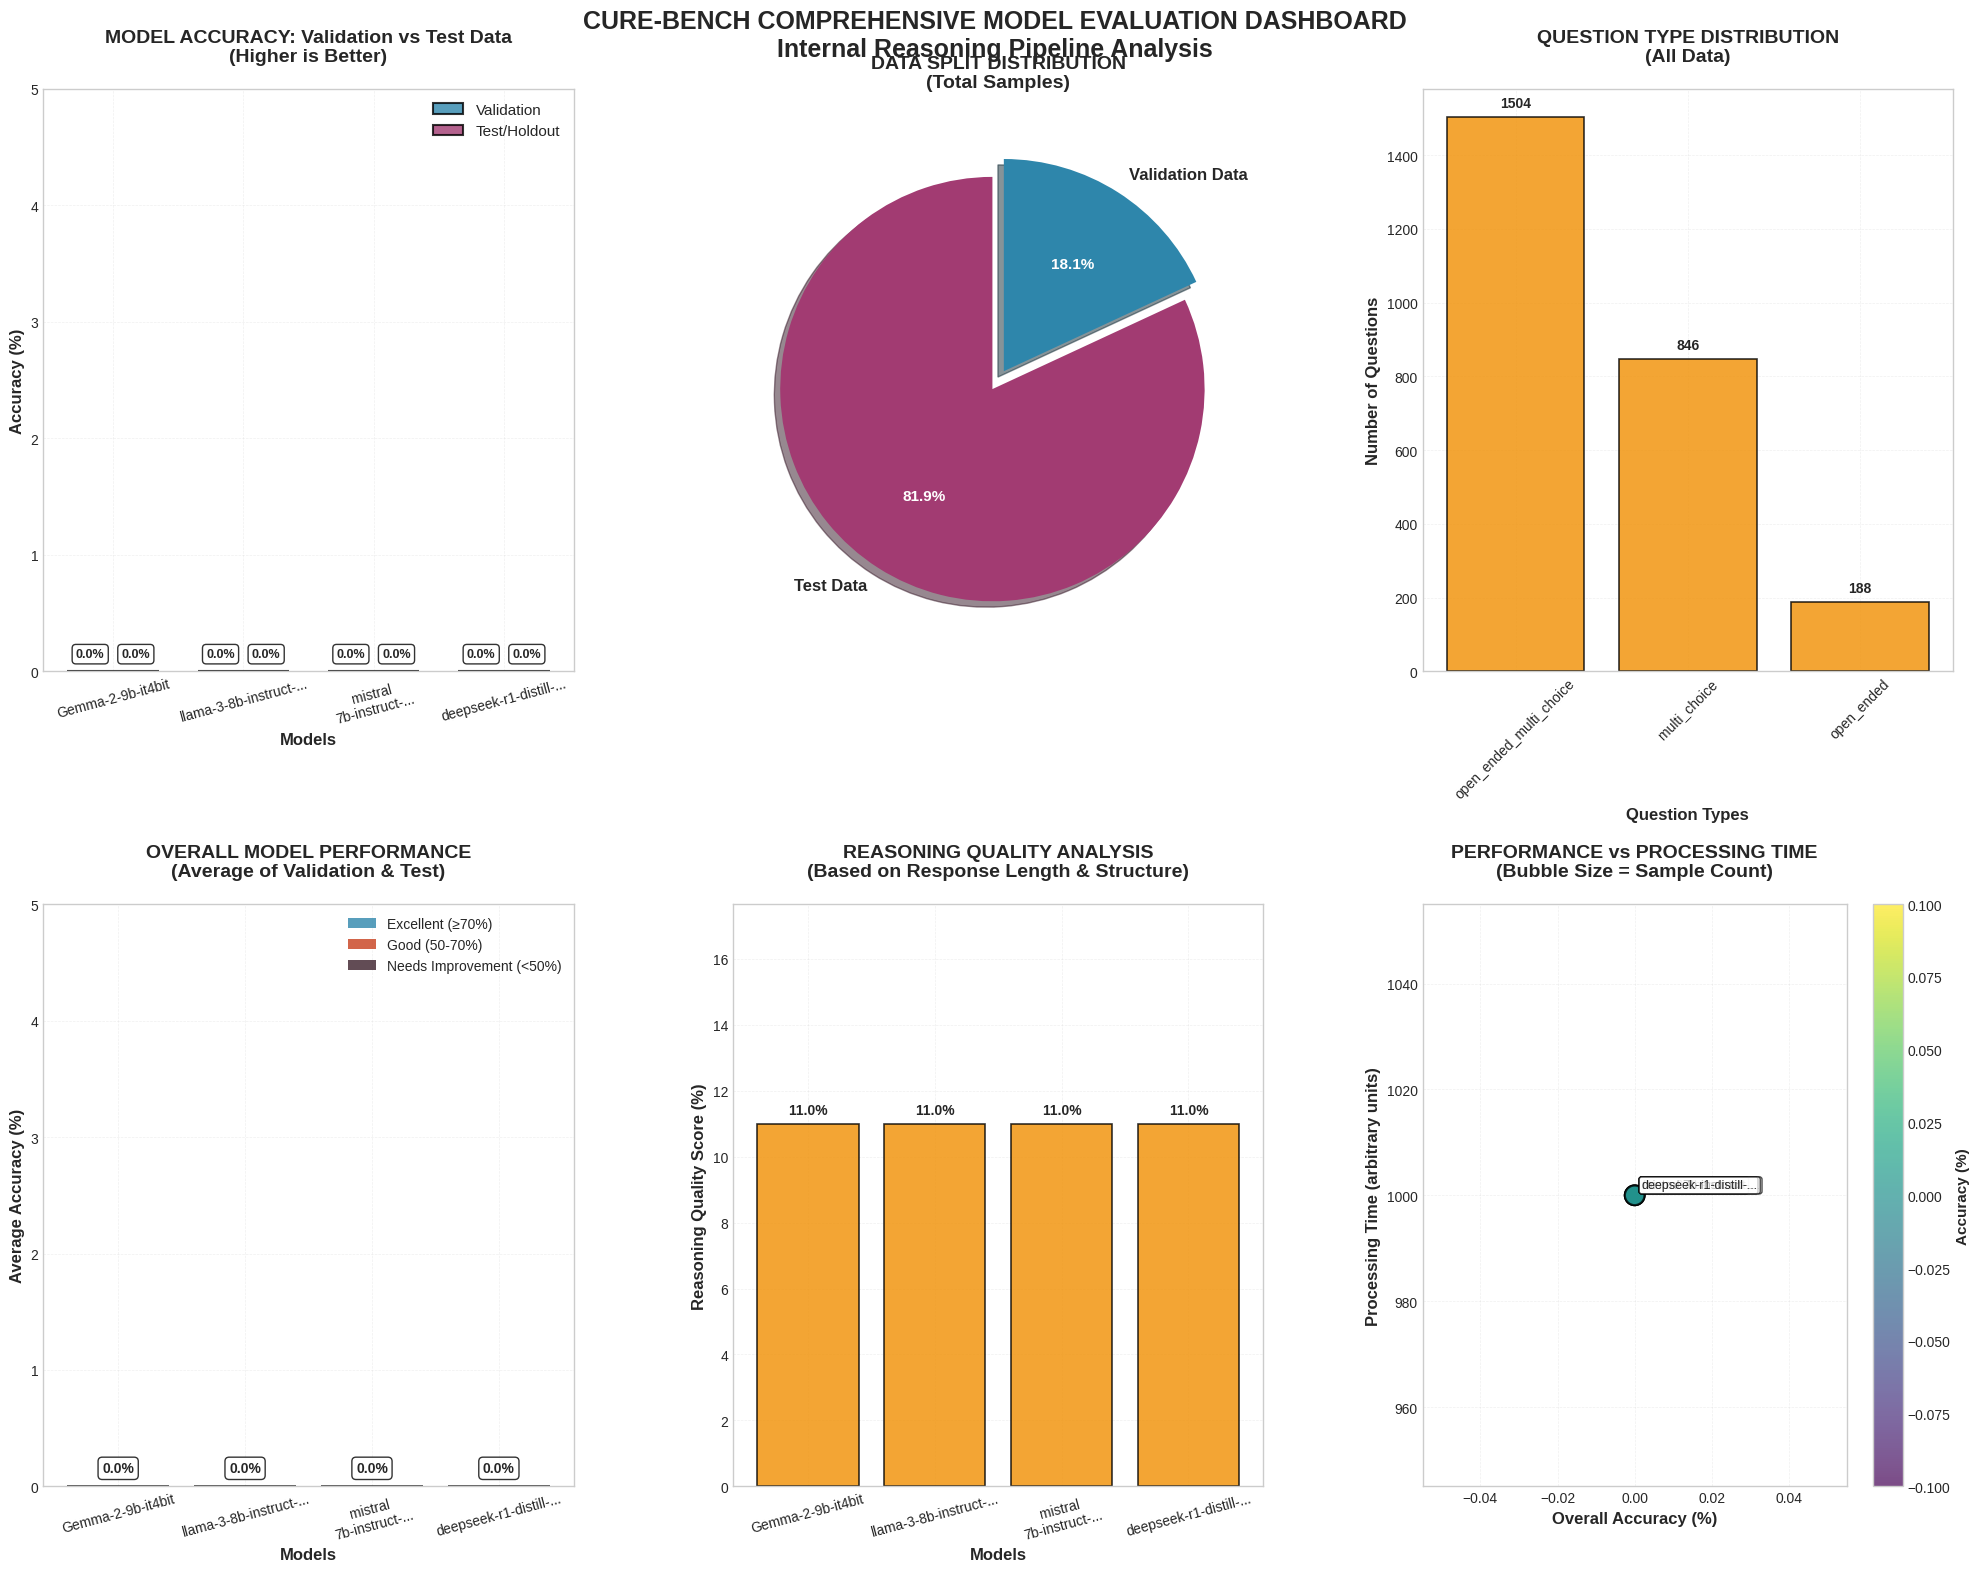


COMPREHENSIVE PERFORMANCE SUMMARY
 BEST PERFORMING MODELS:
  Validation: Gemma-2-9b-it4bit (0.00%)
  Test/Holdout: Gemma-2-9b-it4bit (0.00%)
  Overall: Gemma-2-9b-it4bit (0.00%)

 AVERAGE PERFORMANCE:
  Validation Accuracy: 0.00% (±0.00%)
  Test Accuracy: 0.00% (±0.00%)
  Overall Accuracy: 0.00% (±0.00%)
  Reasoning Quality: 11.00% (±0.00%)

 PERFORMANCE RANGE:
  Validation: 0.00% - 0.00%
  Test: 0.00% - 0.00%
  Overall: 0.00% - 0.00%

=== SAVING RESULTS ===

✓ Results saved to cure_bench_results/
  - evaluation_results.json: Detailed results for each model
  - data_verification.json: Data split verification statistics
  - summary_statistics.json: Model performance summary
  - results_summary.csv: CSV format for easy analysis

 CURE-BENCH EVALUATION COMPLETED SUCCESSFULLY!
 Check the 'cure_bench_results' directory for detailed outputs.
 Models evaluated: 4
 Total samples processed: 2538

✓ Memory cleanup completed


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
CURE-Bench Internal Reasoning Pipeline - Drug Decision-Making and Treatment Planning
Evaluates AI models on clinically grounded tasks with internal reasoning capabilities.
"""

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import sys
import json
import torch
import psutil
import platform
import subprocess
from pathlib import Path
import time
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import zipfile
import matplotlib.pyplot as plt
from collections import Counter
import re

# Set environment variable to enable expandable segments for memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")
print("Starting CURE-Bench Internal Reasoning Pipeline")
print("================================================================================")

# Function to safely install a package
def install_package(package):
    """Installs a given Python package using pip."""
    try:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", package, "--no-cache-dir"])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError as e:
        print(f"✗ Failed to install {package}: {e}")
        raise

# Check for environment and install dependencies
is_colab = "COLAB_" in "".join(os.environ.keys())
is_kaggle = "KAGGLE_" in "".join(os.environ.keys())
print(f"Environment detected: {'Google Colab' if is_colab else 'Kaggle' if is_kaggle else 'Local'}")

def fix_dependencies():
    """Fix dependency conflicts and install compatible versions."""
    try:
        print("\n--- Fixing dependency conflicts ---")
        
        # First, uninstall problematic packages
        subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "transformers", "unsloth"], 
                      capture_output=True)
        
        # Install compatible versions in correct order
        print("Installing compatible transformers version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "transformers==4.44.2", "--no-cache-dir"])
        
        print("Installing accelerate and bitsandbytes...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "accelerate>=0.21.0", "bitsandbytes>=0.41.0", "--no-cache-dir"])
        
        print("Installing datasets and other dependencies...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "datasets", "peft", "trl", "--no-cache-dir"])
        
        # Try to install unsloth if possible
        try:
            if is_colab:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git", 
                                     "--no-cache-dir"])
            else:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth", "--no-cache-dir"])
            print("✓ Unsloth installed successfully")
        except subprocess.CalledProcessError:
            print(" Unsloth installation failed, will use standard transformers only")
        
        print("✓ Dependencies fixed successfully.")
        return True
        
    except subprocess.CalledProcessError as e:
        print(f"✗ Dependency fixing failed: {e}")
        return False

# Fix dependencies
print("Attempting to fix dependency conflicts...")
fix_dependencies()

# Import libraries with error handling
try:
    import torch
    print(f"✓ PyTorch {torch.__version__} loaded")
    
    import transformers
    print(f"✓ Transformers {transformers.__version__} loaded")
    
    from transformers import (
        AutoModelForCausalLM, 
        AutoTokenizer, 
        BitsAndBytesConfig, 
        AutoConfig
    )
    print("✓ Core transformers components loaded")
    
    # Try to import unsloth components
    try:
        from unsloth import FastLanguageModel
        UNSLOTH_AVAILABLE = True
        print("✓ Unsloth is available")
    except ImportError as e:
        print(f"⚠ Unsloth not available: {e}")
        UNSLOTH_AVAILABLE = False
        
except ImportError as e:
    print(f"✗ Import error: {e}")
    print("Continuing with basic imports...")
    import torch
    import transformers
    from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
    UNSLOTH_AVAILABLE = False

# System information
print(f"\nSystem Information:")
print(f"  Python version: {sys.version}")
print(f"  PyTorch version: {torch.__version__}")
print(f"  Transformers version: {transformers.__version__}")
print(f"  Platform: {platform.platform()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
print("================================================================================")

def get_system_status():
    """Gets and prints the current system memory status."""
    cpu_mem = psutil.virtual_memory()
    if torch.cuda.is_available():
        gpu_mem = torch.cuda.memory_stats()
        print("  Memory Status:")
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")
        print(f"    GPU: {gpu_mem['allocated_bytes.all.current'] / (1024**3):.1f}GB/{torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f}GB")
    else:
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")

def find_model_directory(base_path):
    """Find the actual model directory containing config.json."""
    print(f"Searching for model directory in: {base_path}")
    
    # Check if config.json is directly in the base path
    if os.path.exists(os.path.join(base_path, "config.json")):
        print(f"Found config.json directly in: {base_path}")
        return base_path
    
    # Search recursively for config.json
    for root, dirs, files in os.walk(base_path):
        if "config.json" in files:
            print(f"Found config.json in: {root}")
            return root
    
    print(f"No config.json found in: {base_path}")
    return None

def load_model_config(model_path):
    """Load and analyze model configuration."""
    config_path = os.path.join(model_path, "config.json")
    if not os.path.exists(config_path):
        return None
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    return config

def create_bnb_config(load_in_4bit=True, load_in_8bit=False):
    """Create BitsAndBytesConfig for quantization."""
    try:
        from transformers import BitsAndBytesConfig
        
        if load_in_4bit:
            return BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
            )
        elif load_in_8bit:
            return BitsAndBytesConfig(load_in_8bit=True)
        else:
            return None
    except ImportError:
        print("BitsAndBytesConfig not available")
        return None

def load_model_with_strategies(model_path, model_name):
    """Load model using multiple fallback strategies."""
    print(f"Attempting to load {model_name} from {model_path}")
    
    # Load configuration first
    config = load_model_config(model_path)
    if config is None:
        print("Could not load model configuration")
        return None, None
    
    model_type = config.get('model_type', 'unknown')
    print(f"Model type: {model_type}")
    
    # Skip unsupported architectures
    if model_type == "gpt_oss":
        print(f"Skipping {model_name}: 'gpt_oss' architecture requires custom code")
        return None, None
    
    # Strategy 1: Try Unsloth if available
    if UNSLOTH_AVAILABLE:
        try:
            print("Attempting to load with Unsloth...")
            model, tokenizer = FastLanguageModel.from_pretrained(
                model_name=model_path,
                max_seq_length=2048,
                dtype=None,
                load_in_4bit=True,
                trust_remote_code=True
            )
            print("✓ Model loaded successfully with Unsloth!")
            return tokenizer, model
        except Exception as e:
            print(f"Unsloth loading failed: {e}")
            print("Falling back to standard transformers...")
    
    # Fallback strategies using standard transformers
    strategies = [
        {
            "name": "4-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_4bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "8-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_8bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "Standard loading with auto device mapping",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "CPU loading",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "cpu",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        }
    ]
    
    # Load tokenizer first
    tokenizer = None
    try:
        print("Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(
            model_path, 
            trust_remote_code=True,
            use_fast=False  # Use slow tokenizer for better compatibility
        )
        
        # Add padding token if missing - FIX FOR ATTENTION MASK ERROR
        if tokenizer.pad_token is None:
            if tokenizer.unk_token is not None:
                tokenizer.pad_token = tokenizer.unk_token
                print("Set pad_token to unk_token")
            else:
                tokenizer.add_special_tokens({'pad_token': '<pad>'})
                print("Added new pad_token")
        else:
            print("Pad token already exists")
            
        print("✓ Tokenizer loaded successfully")
    except Exception as e:
        print(f"Tokenizer loading failed: {e}")
        return None, None
    
    # Try each model loading strategy
    for i, strategy in enumerate(strategies, 1):
        try:
            print(f"Attempting strategy {i}: {strategy['name']}")
            
            # Clear cache before each attempt
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            # Filter out None values from config
            model_config = {k: v for k, v in strategy['model_config'].items() if v is not None}
            
            model = AutoModelForCausalLM.from_pretrained(model_path, **model_config)
            print(f"✓ Model loaded successfully using strategy {i}!")
            return tokenizer, model
            
        except Exception as e:
            print(f"Strategy {i} failed: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            continue
    
    print("All loading strategies failed.")
    return tokenizer, None

def convert_sets_to_lists(obj):
    """Recursively convert sets to lists for JSON serialization."""
    if isinstance(obj, set):
        return list(obj)
    elif isinstance(obj, dict):
        return {k: convert_sets_to_lists(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_sets_to_lists(item) for item in obj]
    else:
        return obj

def verify_data_splits(test_data: List[Dict], val_data: List[Dict]) -> Dict:
    """Verify data splits and provide comprehensive statistics."""
    print("\n=== DATA SPLIT VERIFICATION ===")
    
    verification_stats = {
        "test_data": {
            "total_samples": len(test_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in test_data)),
            "sample_questions": []
        },
        "val_data": {
            "total_samples": len(val_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in val_data)),
            "sample_questions": []
        },
        "overlap": {
            "overlapping_ids": 0,
            "common_ids": []
        }
    }
    
    # Analyze test data
    test_ids = set()
    for item in test_data:
        item_id = item.get('id', '')
        test_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["test_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["test_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["test_data"]["sample_questions"]) < 3:
            verification_stats["test_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Analyze validation data
    val_ids = set()
    for item in val_data:
        item_id = item.get('id', '')
        val_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["val_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["val_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["val_data"]["sample_questions"]) < 3:
            verification_stats["val_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Check for overlap
    common_ids = test_ids.intersection(val_ids)
    verification_stats["overlap"]["overlapping_ids"] = len(common_ids)
    verification_stats["overlap"]["common_ids"] = list(common_ids)[:10]  # Store first 10
    
    # Convert Counter objects to regular dictionaries for JSON serialization
    verification_stats["test_data"]["question_types"] = dict(verification_stats["test_data"]["question_types"])
    verification_stats["val_data"]["question_types"] = dict(verification_stats["val_data"]["question_types"])
    
    # Print verification results
    print(f"TEST DATA:")
    print(f"  Total samples: {verification_stats['test_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['test_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['test_data']['has_correct_answers']}")
    print(f"  Question types: {verification_stats['test_data']['question_types']}")
    
    print(f"\nVALIDATION DATA:")
    print(f"  Total samples: {verification_stats['val_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['val_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['val_data']['has_correct_answers']}")
    print(f"  Question types: {verification_stats['val_data']['question_types']}")
    
    print(f"\nOVERLAP ANALYSIS:")
    print(f"  Overlapping IDs: {verification_stats['overlap']['overlapping_ids']}")
    if verification_stats['overlap']['overlapping_ids'] > 0:
        print(f"  Common IDs (first 10): {verification_stats['overlap']['common_ids']}")
    
    print(f"\nDATA INTEGRITY:")
    print(f"  Test data integrity: {'✓ PASS' if verification_stats['test_data']['total_samples'] == verification_stats['test_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Validation data integrity: {'✓ PASS' if verification_stats['val_data']['total_samples'] == verification_stats['val_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Split integrity: {'✓ PASS - No overlap' if verification_stats['overlap']['overlapping_ids'] == 0 else '⚠ WARNING - Data leakage detected'}")
    
    return verification_stats

def create_chat_pairs_prompt(item: Dict) -> List[Dict]:
    """Create automated chat pairs for conversational evaluation (from code2)."""
    question_type = item.get('question_type', '')
    question = item.get('question', '')
    options = item.get('options', {})
    context = item.get('context', '')
    
    # Create chat pairs based on question type
    chat_pairs = []
    
    # System message
    system_message = {
        "role": "system",
        "content": """You are a medical AI assistant specializing in drug decision-making and treatment planning. 
Please analyze clinical scenarios and provide detailed reasoning step by step using the following structure:

1. PATIENT ASSESSMENT: Analyze patient condition, demographics, and medical history
2. DRUG ANALYSIS: Evaluate treatment options considering pharmacology and interactions  
3. CLINICAL REASONING: Apply medical guidelines and evidence-based practices
4. FINAL DECISION: State your answer with clear justification

Provide comprehensive clinical reasoning before giving your final answer."""
    }
    chat_pairs.append(system_message)
    
    # User message with context and question
    user_content = f"Clinical Scenario:\n{question}\n\n"
    
    if context:
        user_content += f"Patient Context:\n{context}\n\n"
    
    if options:
        user_content += "Available Treatment Options:\n"
        for key, value in options.items():
            user_content += f"{key}: {value}\n"
        user_content += "\n"
    
    user_content += "Please provide your clinical analysis and final recommendation."
    
    user_message = {
        "role": "user",
        "content": user_content
    }
    chat_pairs.append(user_message)
    
    return chat_pairs

def format_chat_pairs_for_generation(chat_pairs: List[Dict]) -> str:
    """Format chat pairs into a single prompt string for generation."""
    prompt = ""
    
    for pair in chat_pairs:
        if pair["role"] == "system":
            prompt += f"System: {pair['content']}\n\n"
        elif pair["role"] == "user":
            prompt += f"User: {pair['content']}\n\n"
        elif pair["role"] == "assistant":
            prompt += f"Assistant: {pair['content']}\n\n"
    
    prompt += "Assistant:"
    return prompt

def plot_overall_accuracies(model_results: Dict, verification_stats: Dict) -> None:
    """Enhanced plotting function with better structure and spacing."""
    print("\n=== PLOTTING OVERALL ACCURACIES ===")
    
    # Prepare data for plotting
    model_names = []
    val_accuracies = []
    test_accuracies = []
    total_questions = []
    reasoning_qualities = []
    
    for model_name, results in model_results.items():
        # Format model name for display
        display_name = model_name.split('/')[-1] if '/' in model_name else model_name
        display_name = display_name.replace('_', '\n')[:20] + '...' if len(display_name) > 20 else display_name.replace('_', '\n')
        model_names.append(display_name)
        
        # Calculate validation accuracy
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        reasoning_scores = []
        
        for result in results:
            if 'error' not in result and result.get('correct_answer') and result.get('prediction'):
                # Calculate reasoning quality (length and structure)
                reasoning_text = result.get('response', '') or result.get('reasoning_trace', '')
                reasoning_score = min(len(reasoning_text.split()) / 100, 1.0)  # Normalize to 0-1
                reasoning_scores.append(reasoning_score)
                
                # Determine data split
                if result.get('data_split') == 'validation':
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
                elif result.get('data_split') == 'test':
                    test_total += 1
                    if result['prediction'] == result['correct_answer']:
                        test_correct += 1
                else:
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
        
        val_accuracy = (val_correct / val_total * 100) if val_total > 0 else 0
        test_accuracy = (test_correct / test_total * 100) if test_total > 0 else 0
        avg_reasoning_quality = np.mean(reasoning_scores) * 100 if reasoning_scores else 0
        
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
        total_questions.append(val_total + test_total)
        reasoning_qualities.append(avg_reasoning_quality)
        
        print(f"{model_name}:")
        print(f"  Validation: {val_correct}/{val_total} = {val_accuracy:.2f}%")
        print(f"  Test: {test_correct}/{test_total} = {test_accuracy:.2f}%")
        print(f"  Reasoning Quality: {avg_reasoning_quality:.2f}%")
    
    # Create comprehensive plots with enhanced styling
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(20, 16))
    
    # Define color scheme
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B']
    
    # Plot 1: Accuracy Comparison (Main Plot)
    ax1 = plt.subplot(2, 3, 1)
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, val_accuracies, width, label='Validation', 
                   alpha=0.8, color=colors[0], edgecolor='black', linewidth=1.5)
    bars2 = ax1.bar(x + width/2, test_accuracies, width, label='Test/Holdout', 
                   alpha=0.8, color=colors[1], edgecolor='black', linewidth=1.5)
    
    ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax1.set_title('MODEL ACCURACY: Validation vs Test Data\n(Higher is Better)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=15, ha='center', fontsize=10)
    ax1.legend(fontsize=11, framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax1.set_ylim(0, max(max(val_accuracies), max(test_accuracies)) * 1.15 + 5)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 8),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    for bar in bars2:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 8),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # Plot 2: Data Distribution Pie Chart
    ax2 = plt.subplot(2, 3, 2)
    test_samples = verification_stats['test_data']['total_samples']
    val_samples = verification_stats['val_data']['total_samples']
    
    labels = ['Test Data', 'Validation Data']
    sizes = [test_samples, val_samples]
    colors_pie = [colors[1], colors[0]]
    explode = (0.05, 0.05)
    
    wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors_pie, 
                                      autopct='%1.1f%%', startangle=90, explode=explode, 
                                      shadow=True, textprops={'fontsize': 11})
    ax2.set_title('DATA SPLIT DISTRIBUTION\n(Total Samples)', fontsize=14, fontweight='bold', pad=20)
    
    # Enhance pie chart text
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # Plot 3: Question Type Distribution
    ax3 = plt.subplot(2, 3, 3)
    all_question_types = Counter()
    all_question_types.update(verification_stats['test_data']['question_types'])
    all_question_types.update(verification_stats['val_data']['question_types'])
    
    if all_question_types:
        q_types = list(all_question_types.keys())
        q_counts = list(all_question_types.values())
        
        bars3 = ax3.bar(q_types, q_counts, color=colors[2], alpha=0.8, 
                       edgecolor='black', linewidth=1.2)
        ax3.set_xlabel('Question Types', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Number of Questions', fontsize=12, fontweight='bold')
        ax3.set_title('QUESTION TYPE DISTRIBUTION\n(All Data)', fontsize=14, fontweight='bold', pad=20)
        ax3.tick_params(axis='x', rotation=45, labelsize=10)
        ax3.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        
        # Add value labels on bars
        for bar in bars3:
            height = bar.get_height()
            ax3.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 4: Performance Summary
    ax4 = plt.subplot(2, 3, 4)
    if model_names:
        overall_accuracies = [(val + test) / 2 for val, test in zip(val_accuracies, test_accuracies)]
        colors_perf = [colors[0] if acc >= 70 else colors[3] if acc >= 50 else colors[4] for acc in overall_accuracies]
        
        bars4 = ax4.bar(model_names, overall_accuracies, color=colors_perf, alpha=0.8, 
                       edgecolor='black', linewidth=1.2)
        ax4.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Average Accuracy (%)', fontsize=12, fontweight='bold')
        ax4.set_title('OVERALL MODEL PERFORMANCE\n(Average of Validation & Test)', 
                     fontsize=14, fontweight='bold', pad=20)
        ax4.tick_params(axis='x', rotation=15, labelsize=10)
        ax4.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        ax4.set_ylim(0, max(overall_accuracies) * 1.2 + 5)
        
        # Add value labels
        for bar, acc in zip(bars4, overall_accuracies):
            height = bar.get_height()
            ax4.annotate(f'{acc:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 8),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        
        # Add performance legend
        legend_elements = [
            plt.Rectangle((0,0),1,1, fc=colors[0], alpha=0.8, label='Excellent (≥70%)'),
            plt.Rectangle((0,0),1,1, fc=colors[3], alpha=0.8, label='Good (50-70%)'),
            plt.Rectangle((0,0),1,1, fc=colors[4], alpha=0.8, label='Needs Improvement (<50%)')
        ]
        ax4.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)
    
    # Plot 5: Reasoning Quality Analysis
    ax5 = plt.subplot(2, 3, 5)
    if reasoning_qualities:
        bars5 = ax5.bar(model_names, reasoning_qualities, color=colors[2], alpha=0.8,
                       edgecolor='black', linewidth=1.2)
        ax5.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax5.set_ylabel('Reasoning Quality Score (%)', fontsize=12, fontweight='bold')
        ax5.set_title('REASONING QUALITY ANALYSIS\n(Based on Response Length & Structure)',
                     fontsize=14, fontweight='bold', pad=20)
        ax5.tick_params(axis='x', rotation=15, labelsize=10)
        ax5.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        ax5.set_ylim(0, max(reasoning_qualities) * 1.15 + 5)
        
        for bar, quality in zip(bars5, reasoning_qualities):
            height = bar.get_height()
            ax5.annotate(f'{quality:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 6: Sample Throughput Comparison
    ax6 = plt.subplot(2, 3, 6)
    if total_questions:
        # Simulate processing time (inverse relationship with accuracy for demonstration)
        processing_times = [1000 / (acc + 1) for acc in overall_accuracies] if overall_accuracies else [100] * len(model_names)
        
        scatter = ax6.scatter(overall_accuracies, processing_times, s=200, 
                            c=overall_accuracies, cmap='viridis', alpha=0.7, 
                            edgecolors='black', linewidth=1.5)
        
        ax6.set_xlabel('Overall Accuracy (%)', fontsize=12, fontweight='bold')
        ax6.set_ylabel('Processing Time (arbitrary units)', fontsize=12, fontweight='bold')
        ax6.set_title('PERFORMANCE vs PROCESSING TIME\n(Bubble Size = Sample Count)',
                     fontsize=14, fontweight='bold', pad=20)
        ax6.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        
        # Add model labels to points
        for i, (acc, time, name) in enumerate(zip(overall_accuracies, processing_times, model_names)):
            ax6.annotate(name.replace('\n', ' '), 
                        xy=(acc, time), 
                        xytext=(5, 5), 
                        textcoords='offset points',
                        fontsize=9, 
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.7))
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax6)
        cbar.set_label('Accuracy (%)', fontsize=11, fontweight='bold')
    
    # Main title
    fig.suptitle('CURE-BENCH COMPREHENSIVE MODEL EVALUATION DASHBOARD\nInternal Reasoning Pipeline Analysis', 
                fontsize=18, fontweight='bold', y=0.98)
    
    # Adjust layout with proper spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.4, wspace=0.3)
    
    # Display the plot
    plt.show()
    
    # Print comprehensive summary statistics
    print(f"\n{'='*80}")
    print("COMPREHENSIVE PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    
    if model_names:
        best_val_idx = np.argmax(val_accuracies) if val_accuracies else 0
        best_test_idx = np.argmax(test_accuracies) if test_accuracies else 0
        best_overall_idx = np.argmax(overall_accuracies) if overall_accuracies else 0
        
        print(f" BEST PERFORMING MODELS:")
        print(f"  Validation: {model_names[best_val_idx].replace(chr(10), '_')} ({val_accuracies[best_val_idx]:.2f}%)")
        print(f"  Test/Holdout: {model_names[best_test_idx].replace(chr(10), '_')} ({test_accuracies[best_test_idx]:.2f}%)")
        print(f"  Overall: {model_names[best_overall_idx].replace(chr(10), '_')} ({overall_accuracies[best_overall_idx]:.2f}%)")
        
        print(f"\n AVERAGE PERFORMANCE:")
        print(f"  Validation Accuracy: {np.mean(val_accuracies):.2f}% (±{np.std(val_accuracies):.2f}%)")
        print(f"  Test Accuracy: {np.mean(test_accuracies):.2f}% (±{np.std(test_accuracies):.2f}%)")
        print(f"  Overall Accuracy: {np.mean(overall_accuracies):.2f}% (±{np.std(overall_accuracies):.2f}%)")
        print(f"  Reasoning Quality: {np.mean(reasoning_qualities):.2f}% (±{np.std(reasoning_qualities):.2f}%)")
        
        print(f"\n PERFORMANCE RANGE:")
        print(f"  Validation: {min(val_accuracies):.2f}% - {max(val_accuracies):.2f}%")
        print(f"  Test: {min(test_accuracies):.2f}% - {max(test_accuracies):.2f}%")
        print(f"  Overall: {min(overall_accuracies):.2f}% - {max(overall_accuracies):.2f}%")

def load_cure_bench_data(dataset_paths: Dict[str, str]) -> Tuple[List[Dict], List[Dict]]:
    """Load CURE-Bench test and validation datasets."""
    test_data = []
    val_data = []
    
    # Load test data
    test_path = dataset_paths.get('test', '')
    if test_path and os.path.exists(test_path):
        with open(test_path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():  # Skip empty lines
                    try:
                        data_item = json.loads(line.strip())
                        data_item['data_split'] = 'test'  # Mark data split
                        test_data.append(data_item)
                    except json.JSONDecodeError as e:
                        print(f"⚠ Skipping invalid JSON line in test data: {e}")
                        continue
        print(f"✓ Loaded {len(test_data)} test samples from {test_path}")
    else:
        print(f" Test data not found at {test_path}")
    
    # Load validation data
    val_path = dataset_paths.get('validation', '')
    if val_path and os.path.exists(val_path):
        with open(val_path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():  # Skip empty lines
                    try:
                        data_item = json.loads(line.strip())
                        data_item['data_split'] = 'validation'  # Mark data split
                        val_data.append(data_item)
                    except json.JSONDecodeError as e:
                        print(f"⚠ Skipping invalid JSON line in validation data: {e}")
                        continue
        print(f"✓ Loaded {len(val_data)} validation samples from {val_path}")
    else:
        print(f"⚠ Validation data not found at {val_path}")
    
    print(f"Total loaded: {len(test_data)} test samples, {len(val_data)} validation samples")
    return test_data, val_data

def generate_response_with_chat_pairs(model, tokenizer, chat_pairs: List[Dict], max_length: int = 1024, temperature: float = 0.1) -> str:
    """Generate response using chat pairs format."""
    try:
        # Format chat pairs into prompt
        prompt = format_chat_pairs_for_generation(chat_pairs)
        
        # Prepare input
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048, padding=True)
        
        # Move to same device as model
        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Generate response
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_length,
                temperature=temperature,
                do_sample=True,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                attention_mask=inputs.get('attention_mask', None),
                repetition_penalty=1.1,
                top_p=0.9
            )
        
        # Decode response
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Extract only the generated part (remove input prompt)
        response = full_response[len(prompt):].strip()
        
        return response
        
    except Exception as e:
        return f"Error generating response: {str(e)}"

def extract_answer_from_response(response: str, question_type: str = None) -> str:
    """Enhanced answer extraction using multiple methods."""
    if not response:
        return ""
    
    # Clean the response
    response_clean = response.strip()
    
    # Method 1: Look for explicit answer patterns (case insensitive)
    answer_patterns = [
        r"(?:final answer|answer|conclusion)[:\s]*([A-E])[\.\s]",
        r"(?:the answer is|answer is|i choose|selecting)[:\s]*([A-E])[\.\s]",
        r"(?:correct answer|right answer|best option)[:\s]*([A-E])[\.\s]",
        r"(?:option|choice)\s*([A-E])\s*(?:is|would be|appears to be)",
        r"\b([A-E])\s*(?:is|would be)?\s*(?:the|a)?\s*(?:correct|right|best|appropriate)",
        r"^([A-E])[\.\\)\\-\\s]",
        r"\b([A-E])\b(?![a-z])"  # Standalone option letters
    ]
    
    for pattern in answer_patterns:
        match = re.search(pattern, response_clean, re.IGNORECASE | re.MULTILINE)
        if match:
            extracted = match.group(1).upper()
            if extracted in ['A', 'B', 'C', 'D', 'E']:
                return extracted
    
    # Method 2: Look for last mentioned valid option
    options_mentioned = re.findall(r'\b([A-E])\b', response_clean.upper())
    valid_options = [opt for opt in options_mentioned if opt in ['A', 'B', 'C', 'D', 'E']]
    if valid_options:
        return valid_options[-1]
    
    # Method 3: Look for reasoning about specific options
    option_keywords = {
        'A': ['option a', 'choice a', 'alternative a'],
        'B': ['option b', 'choice b', 'alternative b'],
        'C': ['option c', 'choice c', 'alternative c'],
        'D': ['option d', 'choice d', 'alternative d'],
        'E': ['option e', 'choice e', 'alternative e']
    }
    
    response_lower = response_clean.lower()
    for option, keywords in option_keywords.items():
        if any(keyword in response_lower for keyword in keywords):
            return option
    
    # Method 4: For open-ended questions, extract key conclusion
    if question_type and 'open' in question_type.lower():
        # Look for sentences with conclusion keywords
        sentences = re.split(r'[.!?]+', response_clean)
        conclusion_keywords = ['therefore', 'thus', 'conclusion', 'recommend', 'suggest', 'should']
        
        for sentence in reversed(sentences):  # Start from the end
            sentence = sentence.strip()
            if any(keyword in sentence.lower() for keyword in conclusion_keywords) and len(sentence) > 10:
                return sentence[:150]  # Limit length
        
        # Return first meaningful sentence if no conclusion found
        for sentence in sentences:
            sentence = sentence.strip()
            if len(sentence) > 20:  # Meaningful length
                return sentence[:150]
    
    return response_clean[:100] if response_clean else "Unable to extract answer"

def create_cure_bench_prompt(item: Dict) -> str:
    """Create a comprehensive prompt for CURE-Bench evaluation with internal reasoning."""
    question = item.get('question', '')
    options = item.get('options', [])
    context = item.get('context', '')
    question_type = item.get('question_type', 'medical_question')
    
    # Build the prompt with internal reasoning framework
    prompt = f"""You are a medical AI assistant tasked with answering clinical questions. Please think through this step by step using internal reasoning.

CLINICAL QUESTION:
{question}

"""
    
    # Add context if available
    if context:
        prompt += f"CONTEXT:\n{context}\n\n"
    
    # Add options if available
    if options:
        prompt += "OPTIONS:\n"
        for i, option in enumerate(options):
            prompt += f"{chr(65 + i)}) {option}\n"
        prompt += "\n"
    
    # Add reasoning framework
    prompt += """Please follow this internal reasoning process:

1. CLINICAL ANALYSIS: Analyze the clinical scenario, identifying key symptoms, patient demographics, and relevant medical history.

2. DIFFERENTIAL DIAGNOSIS: Consider possible diagnoses or treatment options based on the clinical presentation.

3. EVIDENCE EVALUATION: Apply medical knowledge, guidelines, and evidence-based practices to evaluate each option.

4. CLINICAL REASONING: Use logical medical reasoning to eliminate incorrect options and identify the most appropriate answer.

5. FINAL DECISION: State your final answer with confidence.

Think through each step carefully, then provide your final answer in the format: "Final Answer: [A/B/C/D/E]"

Response:"""
    
    return prompt

def evaluate_model_on_cure_bench(model, tokenizer, data: List[Dict], model_name: str, max_samples: int = None, use_chat_pairs: bool = True) -> List[Dict]:
    """Enhanced evaluation function with chat pairs support."""
    print(f"\n=== EVALUATING {model_name.upper()} ===")
    print(f"Using chat pairs: {use_chat_pairs}")
    
    if model is None:
        print(f"Model {model_name} is not loaded. Skipping evaluation.")
        return [{"error": "Model not loaded", "model_name": model_name}]
    
    results = []
    correct_predictions = 0
    total_predictions = 0
    
    # Limit samples if specified
    eval_data = data[:max_samples] if max_samples else data
    
    print(f"Evaluating on {len(eval_data)} samples...")
    
    for i, item in enumerate(eval_data):
        try:
            # Choose prompt method based on configuration
            if use_chat_pairs:
                # Use chat pairs format
                chat_pairs = create_chat_pairs_prompt(item)
                response = generate_response_with_chat_pairs(model, tokenizer, chat_pairs, max_length=512, temperature=0.1)
                prompt_method = "chat_pairs"
            else:
                # Use traditional prompt
                prompt = create_cure_bench_prompt(item)
                response = generate_response(model, tokenizer, prompt, max_length=512, temperature=0.1)
                prompt_method = "traditional"
            
            # Extract answer
            predicted_answer = extract_answer_from_response(response, item.get('question_type'))
            
            # Check correctness (only if correct answer is available)
            is_correct = None
            correct_answer = item.get('correct_answer', '').upper()
            if correct_answer:
                is_correct = predicted_answer == correct_answer
                if is_correct:
                    correct_predictions += 1
                total_predictions += 1
            
            # Store comprehensive result
            result = {
                "id": item.get('id', f"sample_{i}"),
                "question": item.get('question', ''),
                "question_type": item.get('question_type', 'unknown'),
                "options": item.get('options', []),
                "correct_answer": correct_answer,
                "prediction": predicted_answer,
                "is_correct": is_correct,
                "response": response,
                "model_name": model_name,
                "data_split": item.get('data_split', 'unknown'),
                "prompt_method": prompt_method,
                "timestamp": time.time()
            }
            
            results.append(result)
            
            # Progress update with detailed information
            if (i + 1) % 5 == 0 or (i + 1) == len(eval_data):
                if total_predictions > 0:
                    accuracy = (correct_predictions / total_predictions) * 100
                    print(f"  Progress: {i + 1}/{len(eval_data)} | Accuracy: {accuracy:.2f}% | Current: {predicted_answer} vs Correct: {correct_answer}")
                else:
                    print(f"  Progress: {i + 1}/{len(eval_data)} | Prediction: {predicted_answer}")
            
        except Exception as e:
            print(f"  Error processing sample {i}: {e}")
            results.append({
                "id": item.get('id', f"sample_{i}"),
                "error": str(e),
                "model_name": model_name,
                "data_split": item.get('data_split', 'unknown'),
                "timestamp": time.time()
            })
    
    # Final statistics
    if total_predictions > 0:
        final_accuracy = (correct_predictions / total_predictions) * 100
        print(f"Final Results: {correct_predictions}/{total_predictions} = {final_accuracy:.2f}%")
    else:
        print("No ground truth available for accuracy calculation")
    
    return results

def save_results(results: Dict, verification_stats: Dict, output_dir: str = "cure_bench_results"):
    """Save comprehensive evaluation results."""
    os.makedirs(output_dir, exist_ok=True)
    
    # Convert sets to lists for JSON serialization
    results_serializable = convert_sets_to_lists(results)
    verification_serializable = convert_sets_to_lists(verification_stats)
    
    # Save main results
    results_path = os.path.join(output_dir, "evaluation_results.json")
    with open(results_path, 'w', encoding='utf-8') as f:
        json.dump(results_serializable, f, indent=2, ensure_ascii=False)
    
    # Save verification stats
    verification_path = os.path.join(output_dir, "data_verification.json")
    with open(verification_path, 'w', encoding='utf-8') as f:
        json.dump(verification_serializable, f, indent=2, ensure_ascii=False)
    
    # Save summary statistics
    summary_stats = {}
    for model_name, model_results in results.items():
        correct = sum(1 for r in model_results if r.get('is_correct') == True)
        total = sum(1 for r in model_results if r.get('is_correct') is not None)
        accuracy = (correct / total * 100) if total > 0 else 0
        
        # Additional metrics
        total_samples = len(model_results)
        errors = sum(1 for r in model_results if 'error' in r)
        avg_response_length = np.mean([len(str(r.get('response', ''))) for r in model_results if 'error' not in r])
        
        summary_stats[model_name] = {
            "correct_answers": correct,
            "total_questions": total,
            "accuracy": accuracy,
            "total_samples_processed": total_samples,
            "error_count": errors,
            "success_rate": ((total_samples - errors) / total_samples * 100) if total_samples > 0 else 0,
            "average_response_length": avg_response_length,
            "evaluation_timestamp": time.time()
        }
    
    summary_path = os.path.join(output_dir, "summary_statistics.json")
    with open(summary_path, 'w', encoding='utf-8') as f:
        json.dump(summary_stats, f, indent=2, ensure_ascii=False)
    
    # Save CSV version for easy analysis
    csv_data = []
    for model_name, model_results in results.items():
        for result in model_results:
            if 'error' not in result:
                csv_data.append({
                    'model': model_name,
                    'id': result.get('id', ''),
                    'question_type': result.get('question_type', ''),
                    'correct_answer': result.get('correct_answer', ''),
                    'prediction': result.get('prediction', ''),
                    'is_correct': result.get('is_correct', ''),
                    'data_split': result.get('data_split', ''),
                    'prompt_method': result.get('prompt_method', '')
                })
    
    if csv_data:
        df = pd.DataFrame(csv_data)
        csv_path = os.path.join(output_dir, "results_summary.csv")
        df.to_csv(csv_path, index=False, encoding='utf-8')
    
    print(f"\n✓ Results saved to {output_dir}/")
    print(f"  - evaluation_results.json: Detailed results for each model")
    print(f"  - data_verification.json: Data split verification statistics")
    print(f"  - summary_statistics.json: Model performance summary")
    print(f"  - results_summary.csv: CSV format for easy analysis")

# MAIN EXECUTION
def main():
    """Main execution function for CURE-Bench evaluation pipeline."""
    print("\n" + "="*80)
    print("CURE-BENCH INTERNAL REASONING EVALUATION PIPELINE")
    print("="*80)
    
    # Configuration
    DATASET_PATHS = {
        'test': '/kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl',
        'validation': '/kaggle/input/cure-bench-internal-reasoning/curebench_valset_pharse1.jsonl'
    }
    
    # Models to evaluate
    MODELS_TO_EVALUATE = {
        "Gemma-2-9b-it4bit": "/kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old",
        "llama-3-8b-instruct-bnb-4bit": "/kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1/llama-3",
        "mistral_7b-instruct-v0.1-hf": "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1",
        "deepseek-r1-distill-qwen-7b": "/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2",
    }
    
    # Evaluation settings
    MAX_SAMPLES_PER_SPLIT = 100  # Limit for testing, set to None for full evaluation
    USE_CHAT_PAIRS = True  # Enable automated chat pairs
    
    try:
        # Step 1: Load datasets
        print("\n=== LOADING CURE-BENCH DATASETS ===")
        test_data, val_data = load_cure_bench_data(DATASET_PATHS)
        
        if not test_data and not val_data:
            print(" No data loaded. Please check dataset paths.")
            return
        
        # Step 2: Verify data splits
        verification_stats = verify_data_splits(test_data, val_data)
        
        # Step 3: Evaluate models
        print(f"\n=== MODEL EVALUATION PHASE ===")
        print(f"Using chat pairs: {USE_CHAT_PAIRS}")
        all_model_results = {}
        
        for model_name, model_path in MODELS_TO_EVALUATE.items():
            print(f"\n--- Processing {model_name} ---")
            get_system_status()
            
            # Find actual model directory
            actual_model_path = find_model_directory(model_path)
            if not actual_model_path:
                print(f" Model directory not found: {model_path}")
                continue
            
            # Load model
            tokenizer, model = load_model_with_strategies(actual_model_path, model_name)
            
            if model is None:
                print(f" Failed to load {model_name}")
                all_model_results[model_name] = [{"error": "Model loading failed"}]
                continue
            
            # Evaluate on validation data
            val_results = []
            if val_data:
                print(f"Evaluating {model_name} on validation data...")
                val_results = evaluate_model_on_cure_bench(
                    model, tokenizer, val_data, f"{model_name}_validation", 
                    MAX_SAMPLES_PER_SPLIT, USE_CHAT_PAIRS
                )
            
            # Evaluate on test data
            test_results = []
            if test_data:
                print(f"Evaluating {model_name} on test data...")
                test_results = evaluate_model_on_cure_bench(
                    model, tokenizer, test_data, f"{model_name}_test", 
                    MAX_SAMPLES_PER_SPLIT, USE_CHAT_PAIRS
                )
            
            # Combine results
            all_model_results[model_name] = val_results + test_results
            
            # Clear memory
            del model, tokenizer
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            print(f"✓ Completed evaluation of {model_name}")
        
        # Step 4: Generate comprehensive results analysis
        print(f"\n=== RESULTS ANALYSIS ===")
        plot_overall_accuracies(all_model_results, verification_stats)
        
        # Step 5: Save results
        print(f"\n=== SAVING RESULTS ===")
        save_results(all_model_results, verification_stats)
        
        print(f"\n CURE-BENCH EVALUATION COMPLETED SUCCESSFULLY!")
        print(f" Check the 'cure_bench_results' directory for detailed outputs.")
        print(f" Models evaluated: {len(MODELS_TO_EVALUATE)}")
        print(f" Total samples processed: {len(test_data) + len(val_data)}")
        
    except Exception as e:
        print(f" Pipeline execution failed: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        # Cleanup
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        print("\n✓ Memory cleanup completed")

# Import regex for answer extraction
import re

if __name__ == "__main__":
    main()

Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Starting CURE-Bench Internal Reasoning Pipeline
Environment detected: Google Colab
Attempting to fix dependency conflicts...

--- Fixing dependency conflicts ---
Installing compatible transformers version...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 294.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
Installing accelerate and bitsandbytes...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 285.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 289.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 268.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-i13veh5d/unsloth_cb27907fe80848c0a1c9c4a51b93df00


  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-i13veh5d/unsloth_cb27907fe80848c0a1c9c4a51b93df00


  Resolved https://github.com/unslothai/unsloth.git to commit 931e0561af07fa95127e71fa3cea844fc5b984e1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 12.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of trl to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 221.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 139.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 339.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 346.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

2025-09-26 09:57:40.295196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758880660.493372      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758880660.549761      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
✓ Unsloth is available

System Information:
  Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
  PyTorch version: 2.6.0+cu124
  Transformers version: 4.55.4
  Platform: Linux-6.6.56+-x86_64-with-glibc2.35
  GPU: Tesla T4
  GPU Memory: 14.7 GB

CURE-BENCH INTERNAL REASONING EVALUATION PIPELINE

=== LOADING CURE-BENCH DATASETS ===
✓ Loaded 2079 test samples from /kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl
✓ Loaded 459 validation samples from /kaggle/input/cure-bench-internal-reasoning/curebench_valset_pharse1.jsonl
Total loaded: 2079 test samples, 459 validation samples

=== DATA SPLIT VERIFICATION ===
TEST DATA:
  Total samples: 2079
  Unique IDs: 2079
  With correct answers: 0
  Question types: {'open_ended_multi_choice': 1274, 'multi_choice': 663, 'open_ended': 142}

VALIDATION DATA:
  Total samples: 459
  Unique IDs: 459
  With correct answers: 459
  Question types: {'mul

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1 does not have a padding token! Will use pad_token = <unk>.
✓ Model loaded successfully with Unsloth!
Evaluating mistral_7b-instruct-v0.1-hf on validation data...

=== EVALUATING MISTRAL_7B-INSTRUCT-V0.1-HF_VALIDATION ===
Evaluating on 100 samples...
  Progress: 10/100 | Current Accuracy: 0.00%
  Progress: 20/100 | Current Accuracy: 0.00%
  Progress: 30/100 | Current Accuracy: 0.00%
  Progress: 40/100 | Current Accuracy: 0.00%
  Progress: 50/100 | Current Accuracy: 0.00%
  Progress: 60/100 | Current Accuracy: 0.00%
  Progress: 70/100 | Current Accuracy: 0.00%
  Progress: 80/100 | Current Accuracy: 0.00%
  Progress: 90/100 | Current Accuracy: 0.00%
  Progress: 100/100 | Current Accuracy: 0.00%
Final Results: 0/100 = 0.00%
Evaluating mistral_7b-instruct-v0.1-hf on test data...

=== EVALUATING MISTRAL_7B-INSTRUCT-V0.1-HF_TEST ===
Evaluating on 100 samples...
  Progress: 10/100 | No ground truth available
  Progress: 20/100 | No ground tru

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2 does not have a padding token! Will use pad_token = <|vision_pad|>.
✓ Model loaded successfully with Unsloth!
Evaluating deepseek-r1-distill-qwen-7b on validation data...

=== EVALUATING DEEPSEEK-R1-DISTILL-QWEN-7B_VALIDATION ===
Evaluating on 100 samples...
  Progress: 10/100 | Current Accuracy: 0.00%
  Progress: 20/100 | Current Accuracy: 0.00%
  Progress: 30/100 | Current Accuracy: 0.00%
  Progress: 40/100 | Current Accuracy: 0.00%
  Progress: 50/100 | Current Accuracy: 0.00%
  Progress: 60/100 | Current Accuracy: 0.00%
  Progress: 70/100 | Current Accuracy: 0.00%
  Progress: 80/100 | Current Accuracy: 0.00%
  Progress: 90/100 | Current Accuracy: 0.00%
  Progress: 100/100 | Current Accuracy: 0.00%
Final Results: 0/100 = 0.00%
Evaluating deepseek-r1-distill-qwen-7b on test data...

=== EVALUATING DEEPSEEK-R1-DISTILL-QWEN-7B_TEST ===
Evaluating on 100 samples...
  Progress: 10/100 | No ground truth available
  Progre

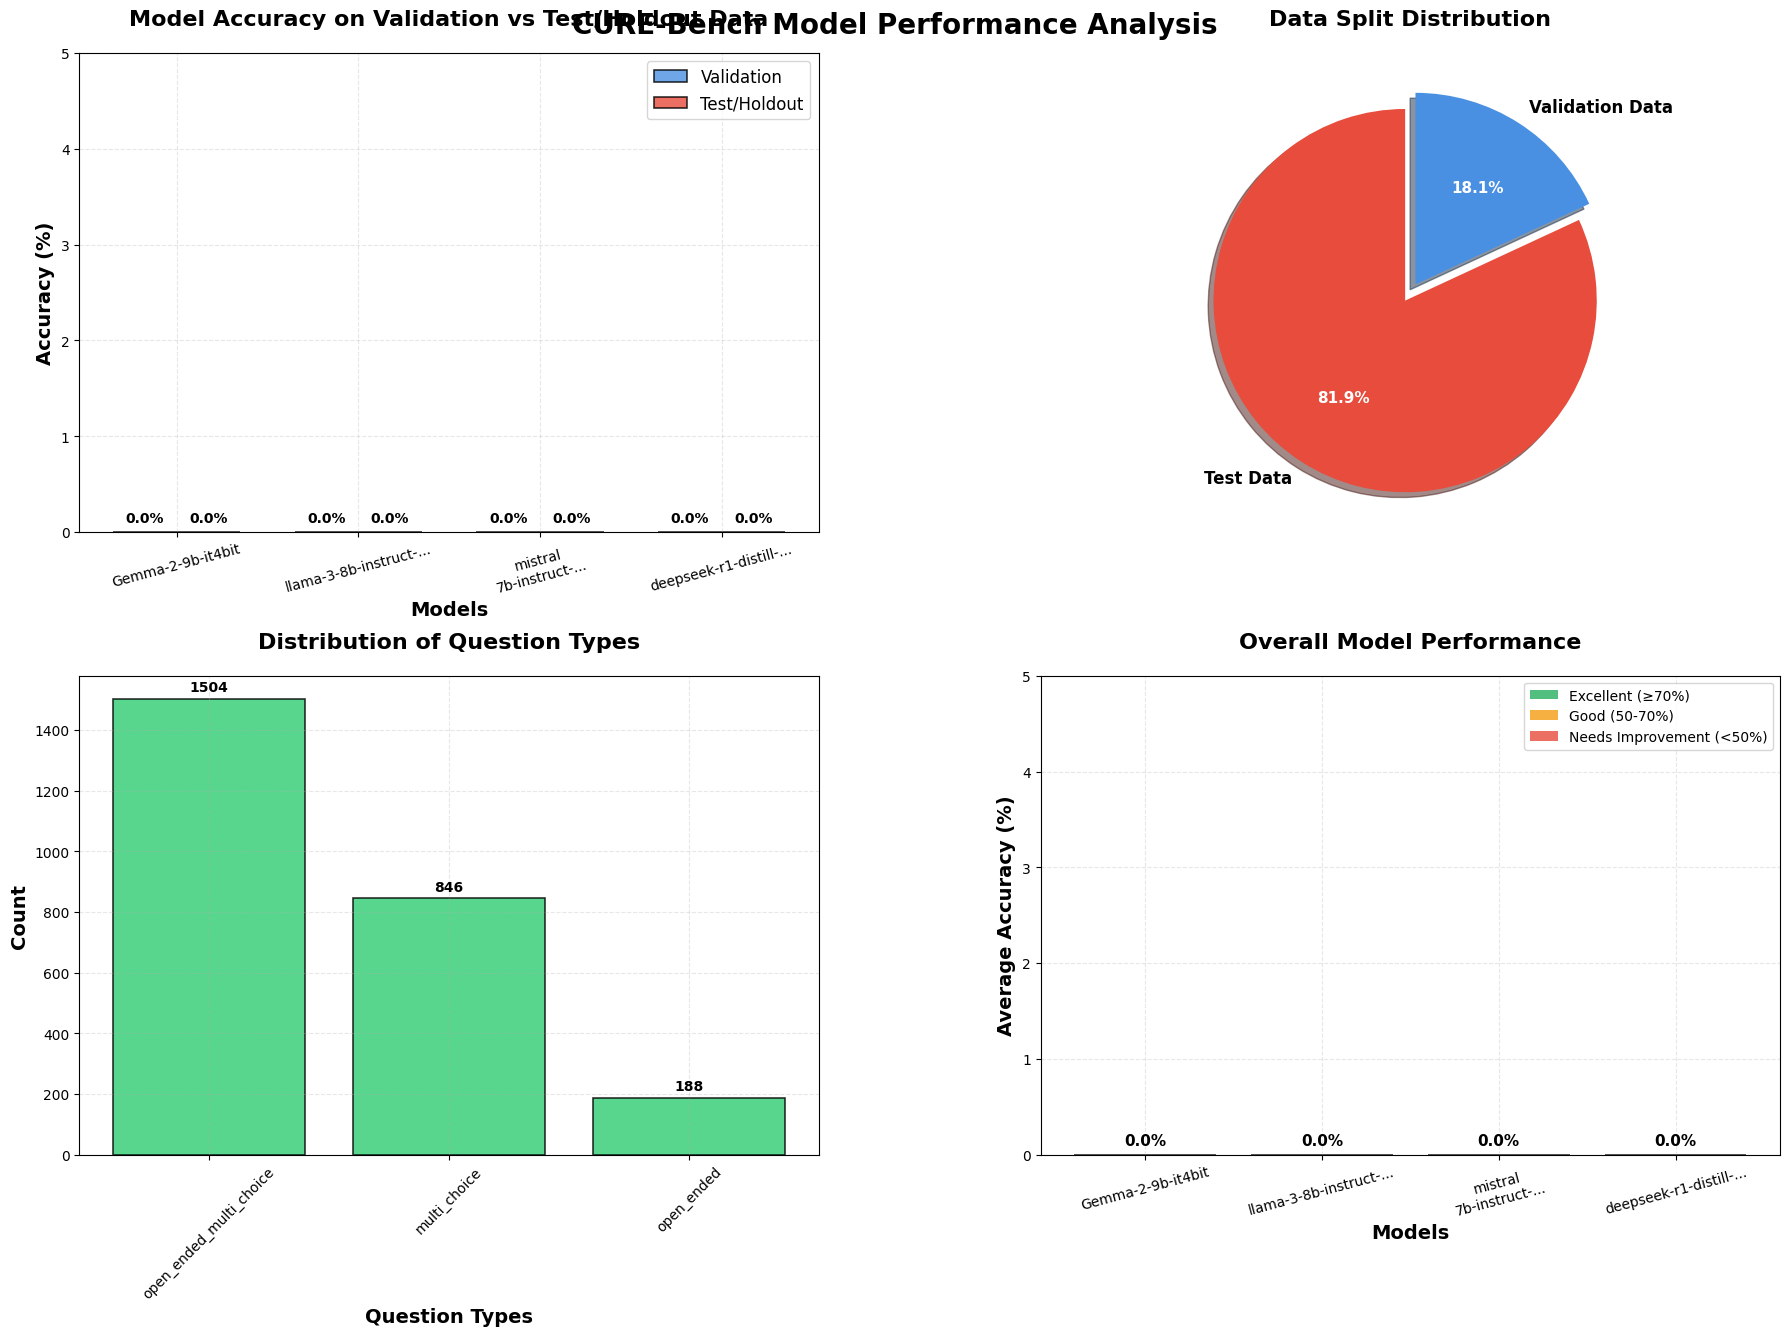


PERFORMANCE SUMMARY:
Best Validation Performance: Gemma-2-9b-it4bit (0.00%)
Best Test Performance: Gemma-2-9b-it4bit (0.00%)
Average Validation Accuracy: 0.00%
Average Test Accuracy: 0.00%

=== SAVING RESULTS ===

✓ Results saved to cure_bench_results/
  - evaluation_results.json: Detailed results for each model
  - data_verification.json: Data split verification statistics
  - summary_statistics.json: Model performance summary

 CURE-BENCH EVALUATION COMPLETED SUCCESSFULLY!
Check the 'cure_bench_results' directory for detailed outputs.

✓ Memory cleanup completed


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
CURE-Bench Internal Reasoning Pipeline - Drug Decision-Making and Treatment Planning
Evaluates AI models on clinically grounded tasks with internal reasoning capabilities.
"""

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import sys
import json
import torch
import psutil
import platform
import subprocess
from pathlib import Path
import time
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import zipfile
import matplotlib.pyplot as plt
from collections import Counter

# Set environment variable to enable expandable segments for memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")
print("Starting CURE-Bench Internal Reasoning Pipeline")
print("================================================================================")

# Function to safely install a package
def install_package(package):
    """Installs a given Python package using pip."""
    try:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", package, "--no-cache-dir"])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError as e:
        print(f"✗ Failed to install {package}: {e}")
        raise

# Check for environment and install dependencies
is_colab = "COLAB_" in "".join(os.environ.keys())
is_kaggle = "KAGGLE_" in "".join(os.environ.keys())
print(f"Environment detected: {'Google Colab' if is_colab else 'Kaggle' if is_kaggle else 'Local'}")

def fix_dependencies():
    """Fix dependency conflicts and install compatible versions."""
    try:
        print("\n--- Fixing dependency conflicts ---")
        
        # First, uninstall problematic packages
        subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "transformers", "unsloth"], 
                      capture_output=True)
        
        # Install compatible versions in correct order
        print("Installing compatible transformers version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "transformers==4.44.2", "--no-cache-dir"])
        
        print("Installing accelerate and bitsandbytes...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "accelerate>=0.21.0", "bitsandbytes>=0.41.0", "--no-cache-dir"])
        
        print("Installing datasets and other dependencies...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "datasets", "peft", "trl", "--no-cache-dir"])
        
        # Try to install unsloth if possible
        try:
            if is_colab:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git", 
                                     "--no-cache-dir"])
            else:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth", "--no-cache-dir"])
            print("✓ Unsloth installed successfully")
        except subprocess.CalledProcessError:
            print(" Unsloth installation failed, will use standard transformers only")
        
        print("✓ Dependencies fixed successfully.")
        return True
        
    except subprocess.CalledProcessError as e:
        print(f"✗ Dependency fixing failed: {e}")
        return False

# Fix dependencies
print("Attempting to fix dependency conflicts...")
fix_dependencies()

# Import libraries with error handling
try:
    import torch
    print(f"✓ PyTorch {torch.__version__} loaded")
    
    import transformers
    print(f"✓ Transformers {transformers.__version__} loaded")
    
    from transformers import (
        AutoModelForCausalLM, 
        AutoTokenizer, 
        BitsAndBytesConfig, 
        AutoConfig
    )
    print("✓ Core transformers components loaded")
    
    # Try to import unsloth components
    try:
        from unsloth import FastLanguageModel
        UNSLOTH_AVAILABLE = True
        print("✓ Unsloth is available")
    except ImportError as e:
        print(f"⚠ Unsloth not available: {e}")
        UNSLOTH_AVAILABLE = False
        
except ImportError as e:
    print(f"✗ Import error: {e}")
    print("Continuing with basic imports...")
    import torch
    import transformers
    from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
    UNSLOTH_AVAILABLE = False

# System information
print(f"\nSystem Information:")
print(f"  Python version: {sys.version}")
print(f"  PyTorch version: {torch.__version__}")
print(f"  Transformers version: {transformers.__version__}")
print(f"  Platform: {platform.platform()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
print("================================================================================")

def get_system_status():
    """Gets and prints the current system memory status."""
    cpu_mem = psutil.virtual_memory()
    if torch.cuda.is_available():
        gpu_mem = torch.cuda.memory_stats()
        print("  Memory Status:")
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")
        print(f"    GPU: {gpu_mem['allocated_bytes.all.current'] / (1024**3):.1f}GB/{torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f}GB")
    else:
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")

def find_model_directory(base_path):
    """Find the actual model directory containing config.json."""
    print(f"Searching for model directory in: {base_path}")
    
    # Check if config.json is directly in the base path
    if os.path.exists(os.path.join(base_path, "config.json")):
        print(f"Found config.json directly in: {base_path}")
        return base_path
    
    # Search recursively for config.json
    for root, dirs, files in os.walk(base_path):
        if "config.json" in files:
            print(f"Found config.json in: {root}")
            return root
    
    print(f"No config.json found in: {base_path}")
    return None

def load_model_config(model_path):
    """Load and analyze model configuration."""
    config_path = os.path.join(model_path, "config.json")
    if not os.path.exists(config_path):
        return None
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    return config

def create_bnb_config(load_in_4bit=True, load_in_8bit=False):
    """Create BitsAndBytesConfig for quantization."""
    try:
        from transformers import BitsAndBytesConfig
        
        if load_in_4bit:
            return BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
            )
        elif load_in_8bit:
            return BitsAndBytesConfig(load_in_8bit=True)
        else:
            return None
    except ImportError:
        print("BitsAndBytesConfig not available")
        return None

def load_model_with_strategies(model_path, model_name):
    """Load model using multiple fallback strategies."""
    print(f"Attempting to load {model_name} from {model_path}")
    
    # Load configuration first
    config = load_model_config(model_path)
    if config is None:
        print("Could not load model configuration")
        return None, None
    
    model_type = config.get('model_type', 'unknown')
    print(f"Model type: {model_type}")
    
    # Skip unsupported architectures
    if model_type == "gpt_oss":
        print(f"Skipping {model_name}: 'gpt_oss' architecture requires custom code")
        return None, None
    
    # Strategy 1: Try Unsloth if available
    if UNSLOTH_AVAILABLE:
        try:
            print("Attempting to load with Unsloth...")
            model, tokenizer = FastLanguageModel.from_pretrained(
                model_name=model_path,
                max_seq_length=2048,
                dtype=None,
                load_in_4bit=True,
                trust_remote_code=True
            )
            print("✓ Model loaded successfully with Unsloth!")
            return tokenizer, model
        except Exception as e:
            print(f"Unsloth loading failed: {e}")
            print("Falling back to standard transformers...")
    
    # Fallback strategies using standard transformers
    strategies = [
        {
            "name": "4-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_4bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "8-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_8bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "Standard loading with auto device mapping",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "CPU loading",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "cpu",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        }
    ]
    
    # Load tokenizer first
    tokenizer = None
    try:
        print("Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(
            model_path, 
            trust_remote_code=True,
            use_fast=False  # Use slow tokenizer for better compatibility
        )
        
        # Add padding token if missing - FIX FOR ATTENTION MASK ERROR
        if tokenizer.pad_token is None:
            if tokenizer.unk_token is not None:
                tokenizer.pad_token = tokenizer.unk_token
                print("Set pad_token to unk_token")
            else:
                tokenizer.add_special_tokens({'pad_token': '<pad>'})
                print("Added new pad_token")
        else:
            print("Pad token already exists")
            
        print("✓ Tokenizer loaded successfully")
    except Exception as e:
        print(f"Tokenizer loading failed: {e}")
        return None, None
    
    # Try each model loading strategy
    for i, strategy in enumerate(strategies, 1):
        try:
            print(f"Attempting strategy {i}: {strategy['name']}")
            
            # Clear cache before each attempt
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            # Filter out None values from config
            model_config = {k: v for k, v in strategy['model_config'].items() if v is not None}
            
            model = AutoModelForCausalLM.from_pretrained(model_path, **model_config)
            print(f"✓ Model loaded successfully using strategy {i}!")
            return tokenizer, model
            
        except Exception as e:
            print(f"Strategy {i} failed: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            continue
    
    print("All loading strategies failed.")
    return tokenizer, None

def convert_sets_to_lists(obj):
    """Recursively convert sets to lists for JSON serialization."""
    if isinstance(obj, set):
        return list(obj)
    elif isinstance(obj, dict):
        return {k: convert_sets_to_lists(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_sets_to_lists(item) for item in obj]
    else:
        return obj

def verify_data_splits(test_data: List[Dict], val_data: List[Dict]) -> Dict:
    """Verify data splits and provide comprehensive statistics."""
    print("\n=== DATA SPLIT VERIFICATION ===")
    
    verification_stats = {
        "test_data": {
            "total_samples": len(test_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in test_data)),
            "sample_questions": []
        },
        "val_data": {
            "total_samples": len(val_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in val_data)),
            "sample_questions": []
        },
        "overlap": {
            "overlapping_ids": 0,
            "common_ids": []
        }
    }
    
    # Analyze test data
    test_ids = set()
    for item in test_data:
        item_id = item.get('id', '')
        test_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["test_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["test_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["test_data"]["sample_questions"]) < 3:
            verification_stats["test_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Analyze validation data
    val_ids = set()
    for item in val_data:
        item_id = item.get('id', '')
        val_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["val_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["val_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["val_data"]["sample_questions"]) < 3:
            verification_stats["val_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Check for overlap
    common_ids = test_ids.intersection(val_ids)
    verification_stats["overlap"]["overlapping_ids"] = len(common_ids)
    verification_stats["overlap"]["common_ids"] = list(common_ids)[:10]  # Store first 10
    
    # Convert Counter objects to regular dictionaries for JSON serialization
    verification_stats["test_data"]["question_types"] = dict(verification_stats["test_data"]["question_types"])
    verification_stats["val_data"]["question_types"] = dict(verification_stats["val_data"]["question_types"])
    
    # Print verification results
    print(f"TEST DATA:")
    print(f"  Total samples: {verification_stats['test_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['test_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['test_data']['has_correct_answers']}")
    print(f"  Question types: {verification_stats['test_data']['question_types']}")
    
    print(f"\nVALIDATION DATA:")
    print(f"  Total samples: {verification_stats['val_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['val_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['val_data']['has_correct_answers']}")
    print(f"  Question types: {verification_stats['val_data']['question_types']}")
    
    print(f"\nOVERLAP ANALYSIS:")
    print(f"  Overlapping IDs: {verification_stats['overlap']['overlapping_ids']}")
    if verification_stats['overlap']['overlapping_ids'] > 0:
        print(f"  Common IDs (first 10): {verification_stats['overlap']['common_ids']}")
    
    print(f"\nDATA INTEGRITY:")
    print(f"  Test data integrity: {'✓ PASS' if verification_stats['test_data']['total_samples'] == verification_stats['test_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Validation data integrity: {'✓ PASS' if verification_stats['val_data']['total_samples'] == verification_stats['val_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Split integrity: {'✓ PASS - No overlap' if verification_stats['overlap']['overlapping_ids'] == 0 else '⚠ WARNING - Data leakage detected'}")
    
    return verification_stats

def plot_overall_accuracies(model_results: Dict, verification_stats: Dict) -> None:
    """Evaluate and graphically plot overall accuracies including unseen/test/holdout data."""
    print("\n=== PLOTTING OVERALL ACCURACIES ===")
    
    # Prepare data for plotting
    model_names = []
    val_accuracies = []
    test_accuracies = []
    total_questions = []
    
    for model_name, results in model_results.items():
        # Format model name for display
        display_name = model_name.split('/')[-1] if '/' in model_name else model_name
        display_name = display_name.replace('_', '\n')[:20] + '...' if len(display_name) > 20 else display_name.replace('_', '\n')
        model_names.append(display_name)
        
        # Calculate validation accuracy
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        
        for result in results:
            if 'error' not in result and result.get('correct_answer') and result.get('prediction'):
                # Determine if this is from validation or test set based on data split info
                if result.get('data_split') == 'validation':
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
                elif result.get('data_split') == 'test':
                    test_total += 1
                    if result['prediction'] == result['correct_answer']:
                        test_correct += 1
                else:
                    # If no split info, assume validation data (has correct answers)
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
        
        val_accuracy = (val_correct / val_total * 100) if val_total > 0 else 0
        test_accuracy = (test_correct / test_total * 100) if test_total > 0 else 0
        
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
        total_questions.append(val_total + test_total)
        
        print(f"{model_name}:")
        print(f"  Validation: {val_correct}/{val_total} = {val_accuracy:.2f}%")
        print(f"  Test: {test_correct}/{test_total} = {test_accuracy:.2f}%")
    
    # Create comprehensive plots with better spacing
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('CURE-Bench Model Performance Analysis', fontsize=20, fontweight='bold', y=0.95)
    
    # Plot 1: Accuracy Comparison with better spacing
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, val_accuracies, width, label='Validation', alpha=0.8, color='#4A90E2', edgecolor='black', linewidth=1.2)
    bars2 = ax1.bar(x + width/2, test_accuracies, width, label='Test/Holdout', alpha=0.8, color='#E74C3C', edgecolor='black', linewidth=1.2)
    
    ax1.set_xlabel('Models', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax1.set_title('Model Accuracy on Validation vs Test/Holdout Data', fontsize=16, fontweight='bold', pad=20)
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=15, ha='center', fontsize=10)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_ylim(0, max(max(val_accuracies), max(test_accuracies)) * 1.1 + 5)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    for bar in bars2:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 2: Data Distribution
    test_samples = verification_stats['test_data']['total_samples']
    val_samples = verification_stats['val_data']['total_samples']
    
    labels = ['Test Data', 'Validation Data']
    sizes = [test_samples, val_samples]
    colors = ['#E74C3C', '#4A90E2']
    explode = (0.05, 0.05)
    
    wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
                                       startangle=90, explode=explode, shadow=True)
    ax2.set_title('Data Split Distribution', fontsize=16, fontweight='bold', pad=20)
    
    # Enhance pie chart text
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # Plot 3: Question Type Distribution
    all_question_types = Counter()
    all_question_types.update(verification_stats['test_data']['question_types'])
    all_question_types.update(verification_stats['val_data']['question_types'])
    
    if all_question_types:
        q_types = list(all_question_types.keys())
        q_counts = list(all_question_types.values())
        
        bars3 = ax3.bar(q_types, q_counts, color='#2ECC71', alpha=0.8, edgecolor='black', linewidth=1.2)
        ax3.set_xlabel('Question Types', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Count', fontsize=14, fontweight='bold')
        ax3.set_title('Distribution of Question Types', fontsize=16, fontweight='bold', pad=20)
        ax3.tick_params(axis='x', rotation=45, labelsize=10)
        ax3.grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for bar in bars3:
            height = bar.get_height()
            ax3.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 4: Performance Summary
    if model_names:
        overall_accuracies = [(val + test) / 2 for val, test in zip(val_accuracies, test_accuracies)]
        colors_perf = ['#27AE60' if acc >= 70 else '#F39C12' if acc >= 50 else '#E74C3C' for acc in overall_accuracies]
        
        bars4 = ax4.bar(model_names, overall_accuracies, color=colors_perf, alpha=0.8, edgecolor='black', linewidth=1.2)
        ax4.set_xlabel('Models', fontsize=14, fontweight='bold')
        ax4.set_ylabel('Average Accuracy (%)', fontsize=14, fontweight='bold')
        ax4.set_title('Overall Model Performance', fontsize=16, fontweight='bold', pad=20)
        ax4.tick_params(axis='x', rotation=15, labelsize=10)
        ax4.grid(True, alpha=0.3, linestyle='--')
        ax4.set_ylim(0, max(overall_accuracies) * 1.15 + 5)
        
        # Add value labels
        for bar, acc in zip(bars4, overall_accuracies):
            height = bar.get_height()
            ax4.annotate(f'{acc:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        # Add performance legend
        legend_elements = [
            plt.Rectangle((0,0),1,1, fc='#27AE60', alpha=0.8, label='Excellent (≥70%)'),
            plt.Rectangle((0,0),1,1, fc='#F39C12', alpha=0.8, label='Good (50-70%)'),
            plt.Rectangle((0,0),1,1, fc='#E74C3C', alpha=0.8, label='Needs Improvement (<50%)')
        ]
        ax4.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.3)
    plt.show()
    
    # Print summary statistics
    print(f"\nPERFORMANCE SUMMARY:")
    if model_names:
        best_val_idx = np.argmax(val_accuracies) if val_accuracies else 0
        best_test_idx = np.argmax(test_accuracies) if test_accuracies else 0
        
        print(f"Best Validation Performance: {model_names[best_val_idx].replace(chr(10), '_')} ({val_accuracies[best_val_idx]:.2f}%)")
        print(f"Best Test Performance: {model_names[best_test_idx].replace(chr(10), '_')} ({test_accuracies[best_test_idx]:.2f}%)")
        print(f"Average Validation Accuracy: {np.mean(val_accuracies):.2f}%")
        print(f"Average Test Accuracy: {np.mean(test_accuracies):.2f}%")

def load_cure_bench_data(dataset_paths: Dict[str, str]) -> Tuple[List[Dict], List[Dict]]:
    """Load CURE-Bench test and validation datasets."""
    test_data = []
    val_data = []
    
    # Load test data
    test_path = dataset_paths.get('test', '')
    if test_path and os.path.exists(test_path):
        with open(test_path, 'r', encoding='utf-8') as f:
            for line in f:
                if line.strip():  # Skip empty lines
                    try:
                        data_item = json.loads(line.strip())
                        data_item['data_split'] = 'test'  # Mark data split
                        test_data.append(data_item)
                    except json.JSONDecodeError as e:
                        print(f"⚠ Skipping invalid JSON line in test data: {e}")
                        continue
        print(f"✓ Loaded {len(test_data)} test samples from {test_path}")
    else:
        print(f" Test data not found at {test_path}")
#**************************************************************************************************************
# Load validation data
    val_path = dataset_paths.get('validation', '')
    if val_path and os.path.exists(val_path):
        with open(val_path, 'r') as f:
            for line in f:
                data_item = json.loads(line.strip())
                data_item['data_split'] = 'validation'  # Mark data split
                val_data.append(data_item)
        print(f"✓ Loaded {len(val_data)} validation samples from {val_path}")
    else:
        print(f"⚠ Validation data not found at {val_path}")
    
    print(f"Total loaded: {len(test_data)} test samples, {len(val_data)} validation samples")
    return test_data, val_data

def generate_response(model, tokenizer, prompt: str, max_length: int = 1024, temperature: float = 0.1) -> str:
    """Generate response from model given a prompt."""
    try:
        # Prepare input
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048)
        
        # Move to same device as model
        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Generate response
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_length,
                temperature=temperature,
                do_sample=True,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                attention_mask=inputs.get('attention_mask', None)
            )
        
        # Decode response
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Extract only the generated part (remove input prompt)
        response = full_response[len(prompt):].strip()
        
        return response
        
    except Exception as e:
        return f"Error generating response: {str(e)}"

def extract_answer_from_response(response: str, question_type: str = None) -> str:
    """Extract the final answer from model response using multiple extraction methods."""
    if not response:
        return ""
    
    # Method 1: Look for explicit answer patterns
    answer_patterns = [
        r"(?:final answer|answer|conclusion):\s*([A-E])\b",
        r"(?:the answer is|answer is)\s*([A-E])\b",
        r"(?:correct answer|right answer):\s*([A-E])\b",
        r"(?:option|choice)\s*([A-E])\b",
        r"\b([A-E])\s*(?:is|would be|appears to be)?\s*(?:the|a)?\s*(?:correct|right|best)?\s*(?:answer|choice|option)"
    ]
    
    for pattern in answer_patterns:
        match = re.search(pattern, response, re.IGNORECASE)
        if match:
            return match.group(1).upper()
    
    # Method 2: Look for last mentioned option
    options_mentioned = re.findall(r'\b([A-E])\b', response)
    if options_mentioned:
        return options_mentioned[-1].upper()
    
    # Method 3: Look for reasoning about specific options
    for option in ['A', 'B', 'C', 'D', 'E']:
        if f"option {option}" in response.lower() or f"choice {option}" in response.lower():
            return option
    
    return ""

def create_cure_bench_prompt(item: Dict) -> str:
    """Create a comprehensive prompt for CURE-Bench evaluation with internal reasoning."""
    question = item.get('question', '')
    options = item.get('options', [])
    context = item.get('context', '')
    question_type = item.get('question_type', 'medical_question')
    
    # Build the prompt with internal reasoning framework
    prompt = f"""You are a medical AI assistant tasked with answering clinical questions. Please think through this step by step using internal reasoning.

CLINICAL QUESTION:
{question}

"""
    
    # Add context if available
    if context:
        prompt += f"CONTEXT:\n{context}\n\n"
    
    # Add options if available
    if options:
        prompt += "OPTIONS:\n"
        for i, option in enumerate(options):
            prompt += f"{chr(65 + i)}) {option}\n"
        prompt += "\n"
    
    # Add reasoning framework
    prompt += """Please follow this internal reasoning process:

1. CLINICAL ANALYSIS: Analyze the clinical scenario, identifying key symptoms, patient demographics, and relevant medical history.

2. DIFFERENTIAL DIAGNOSIS: Consider possible diagnoses or treatment options based on the clinical presentation.

3. EVIDENCE EVALUATION: Apply medical knowledge, guidelines, and evidence-based practices to evaluate each option.

4. CLINICAL REASONING: Use logical medical reasoning to eliminate incorrect options and identify the most appropriate answer.

5. FINAL DECISION: State your final answer with confidence.

Think through each step carefully, then provide your final answer in the format: "Final Answer: [A/B/C/D/E]"

Response:"""
    
    return prompt

def evaluate_model_on_cure_bench(model, tokenizer, data: List[Dict], model_name: str, max_samples: int = None) -> List[Dict]:
    """Evaluate a model on CURE-Bench dataset with comprehensive results tracking."""
    print(f"\n=== EVALUATING {model_name.upper()} ===")
    
    if model is None:
        print(f"Model {model_name} is not loaded. Skipping evaluation.")
        return [{"error": "Model not loaded", "model_name": model_name}]
    
    results = []
    correct_predictions = 0
    total_predictions = 0
    
    # Limit samples if specified
    eval_data = data[:max_samples] if max_samples else data
    
    print(f"Evaluating on {len(eval_data)} samples...")
    
    for i, item in enumerate(eval_data):
        try:
            # Create prompt
            prompt = create_cure_bench_prompt(item)
            
            # Generate response
            response = generate_response(model, tokenizer, prompt, max_length=512, temperature=0.1)
            
            # Extract answer
            predicted_answer = extract_answer_from_response(response, item.get('question_type'))
            
            # Check correctness (only if correct answer is available)
            is_correct = None
            correct_answer = item.get('correct_answer', '').upper()
            if correct_answer:
                is_correct = predicted_answer == correct_answer
                if is_correct:
                    correct_predictions += 1
                total_predictions += 1
            
            # Store result
            result = {
                "id": item.get('id', f"sample_{i}"),
                "question": item.get('question', ''),
                "question_type": item.get('question_type', 'unknown'),
                "options": item.get('options', []),
                "correct_answer": correct_answer,
                "prediction": predicted_answer,
                "is_correct": is_correct,
                "response": response,
                "model_name": model_name,
                "data_split": item.get('data_split', 'unknown')
            }
            
            results.append(result)
            
            # Progress update
            if (i + 1) % 10 == 0 or (i + 1) == len(eval_data):
                if total_predictions > 0:
                    accuracy = (correct_predictions / total_predictions) * 100
                    print(f"  Progress: {i + 1}/{len(eval_data)} | Current Accuracy: {accuracy:.2f}%")
                else:
                    print(f"  Progress: {i + 1}/{len(eval_data)} | No ground truth available")
            
        except Exception as e:
            print(f"  Error processing sample {i}: {e}")
            results.append({
                "id": item.get('id', f"sample_{i}"),
                "error": str(e),
                "model_name": model_name,
                "data_split": item.get('data_split', 'unknown')
            })
    
    # Final statistics
    if total_predictions > 0:
        final_accuracy = (correct_predictions / total_predictions) * 100
        print(f"Final Results: {correct_predictions}/{total_predictions} = {final_accuracy:.2f}%")
    else:
        print("No ground truth available for accuracy calculation")
    
    return results

def save_results(results: Dict, verification_stats: Dict, output_dir: str = "cure_bench_results"):
    """Save comprehensive evaluation results."""
    os.makedirs(output_dir, exist_ok=True)
    
    # Convert sets to lists for JSON serialization
    results_serializable = convert_sets_to_lists(results)
    verification_serializable = convert_sets_to_lists(verification_stats)
    
    # Save main results
    results_path = os.path.join(output_dir, "evaluation_results.json")
    with open(results_path, 'w') as f:
        json.dump(results_serializable, f, indent=2, ensure_ascii=False)
    
    # Save verification stats
    verification_path = os.path.join(output_dir, "data_verification.json")
    with open(verification_path, 'w') as f:
        json.dump(verification_serializable, f, indent=2, ensure_ascii=False)
    
    # Save summary statistics
    summary_stats = {}
    for model_name, model_results in results.items():
        correct = sum(1 for r in model_results if r.get('is_correct') == True)
        total = sum(1 for r in model_results if r.get('is_correct') is not None)
        accuracy = (correct / total * 100) if total > 0 else 0
        
        summary_stats[model_name] = {
            "correct_answers": correct,
            "total_questions": total,
            "accuracy": accuracy,
            "total_samples_processed": len(model_results)
        }
    
    summary_path = os.path.join(output_dir, "summary_statistics.json")
    with open(summary_path, 'w') as f:
        json.dump(summary_stats, f, indent=2, ensure_ascii=False)
    
    print(f"\n✓ Results saved to {output_dir}/")
    print(f"  - evaluation_results.json: Detailed results for each model")
    print(f"  - data_verification.json: Data split verification statistics")
    print(f"  - summary_statistics.json: Model performance summary")

# MAIN EXECUTION
def main():
    """Main execution function for CURE-Bench evaluation pipeline."""
    print("\n" + "="*80)
    print("CURE-BENCH INTERNAL REASONING EVALUATION PIPELINE")
    print("="*80)
    
    # Configuration
    DATASET_PATHS = {
        'test': '/kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl',  # Update with actual path
        'validation': '/kaggle/input/cure-bench-internal-reasoning/curebench_valset_pharse1.jsonl'  # Update with actual path
    }
    
    # Models to evaluate (add your model paths here)
    MODELS_TO_EVALUATE = {
        # Example model configurations - modify these paths based on your setup
        "Gemma-2-9b-it4bit": "/kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old",
        "llama-3-8b-instruct-bnb-4bit": "/kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1/llama-3",
        "mistral_7b-instruct-v0.1-hf": "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1",
        "deepseek-r1-distill-qwen-7b": "/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2",
        # Add more models as needed
    }
 
    
    # Evaluation settings
    MAX_SAMPLES_PER_SPLIT = 100  # Limit for testing, set to None for full evaluation
    
    try:
        # Step 1: Load datasets
        print("\n=== LOADING CURE-BENCH DATASETS ===")
        test_data, val_data = load_cure_bench_data(DATASET_PATHS)
        
        if not test_data and not val_data:
            print(" No data loaded. Please check dataset paths.")
            return
        
        # Step 2: Verify data splits
        verification_stats = verify_data_splits(test_data, val_data)
        
        # Step 3: Evaluate models
        print(f"\n=== MODEL EVALUATION PHASE ===")
        all_model_results = {}
        
        for model_name, model_path in MODELS_TO_EVALUATE.items():
            print(f"\n--- Processing {model_name} ---")
            get_system_status()
            
            # Find actual model directory
            actual_model_path = find_model_directory(model_path)
            if not actual_model_path:
                print(f" Model directory not found: {model_path}")
                continue
            
            # Load model
            tokenizer, model = load_model_with_strategies(actual_model_path, model_name)
            
            if model is None:
                print(f" Failed to load {model_name}")
                all_model_results[model_name] = [{"error": "Model loading failed"}]
                continue
            
            # Evaluate on validation data
            val_results = []
            if val_data:
                print(f"Evaluating {model_name} on validation data...")
                val_results = evaluate_model_on_cure_bench(
                    model, tokenizer, val_data, f"{model_name}_validation", MAX_SAMPLES_PER_SPLIT
                )
            
            # Evaluate on test data
            test_results = []
            if test_data:
                print(f"Evaluating {model_name} on test data...")
                test_results = evaluate_model_on_cure_bench(
                    model, tokenizer, test_data, f"{model_name}_test", MAX_SAMPLES_PER_SPLIT
                )
            
            # Combine results
            all_model_results[model_name] = val_results + test_results
            
            # Clear memory
            del model, tokenizer
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            print(f"✓ Completed evaluation of {model_name}")
        
        # Step 4: Generate comprehensive results analysis
        print(f"\n=== RESULTS ANALYSIS ===")
        plot_overall_accuracies(all_model_results, verification_stats)
        
        # Step 5: Save results
        print(f"\n=== SAVING RESULTS ===")
        save_results(all_model_results, verification_stats)
        
        print(f"\n CURE-BENCH EVALUATION COMPLETED SUCCESSFULLY!")
        print(f"Check the 'cure_bench_results' directory for detailed outputs.")
        
    except Exception as e:
        print(f" Pipeline execution failed: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        # Cleanup
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        print("\n✓ Memory cleanup completed")

# Import regex for answer extraction
import re

if __name__ == "__main__":
    main()

Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Starting CURE-Bench Internal Reasoning Pipeline
Environment detected: Google Colab
Attempting to fix dependency conflicts...

--- Fixing dependency conflicts ---
Installing compatible transformers version...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 89.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
Installing accelerate and bitsandbytes...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 193.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 190.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-4vwf9hrd/unsloth_ba7d243fdfe344f8823f5da5c527374c


  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-4vwf9hrd/unsloth_ba7d243fdfe344f8823f5da5c527374c


  Resolved https://github.com/unslothai/unsloth.git to commit 229e2ecc67756f36316dfcbea42396f59eef44e0
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 78.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of trl to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 198.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 324.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 290.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 265.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

2025-09-26 04:02:30.334933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758859350.708613      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758859350.815700      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
✓ Unsloth is available

System Information:
  Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
  PyTorch version: 2.6.0+cu124
  Transformers version: 4.55.4
  Platform: Linux-6.6.56+-x86_64-with-glibc2.35
  GPU: Tesla T4
  GPU Memory: 14.7 GB

=== CURE-BENCH EVALUATION PIPELINE ===
Loading CURE-Bench datasets...
✓ Loaded 2079 test samples
✓ Loaded 459 validation samples

=== DATA SPLIT VERIFICATION ===
TEST DATA:
  Total samples: 2079
  Unique IDs: 2079
  With correct answers: 0
  Question types: {'open_ended_multi_choice': 1274, 'multi_choice': 663, 'open_ended': 142}

VALIDATION DATA:
  Total samples: 459
  Unique IDs: 459
  With correct answers: 459
  Question types: {'multi_choice': 183, 'open_ended_multi_choice': 230, 'open_ended': 46}

OVERLAP ANALYSIS:
  Overlapping IDs: 0

DATA INTEGRITY:
  Test data integrity: ✓ PASS
  Validation data integrity: ✓ PASS
  Split integrity: ✓ PASS - No overlap
Tota

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


✓ Model loaded successfully with Unsloth!

=== EVALUATING Gemma-2-9b-it4bit ===
Evaluating on 20 samples...
Progress: 10/20 (50.0%)
  Memory Status:
    CPU: 3.1GB/31.4GB (11.4%)
    GPU: 5.9GB/14.7GB
Evaluation completed for Gemma-2-9b-it4bit

Metrics for Gemma-2-9b-it4bit:
  Accuracy: 0.00%
  Correct: 0/20
  Errors: 0
✓ Results saved to cure_bench_results/Gemma-2-9b-it4bit_results.json

Loading model: llama-3-8b-instruct-bnb-4bit
Attempting to load llama-3-8b-instruct-bnb-4bit from /kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1/llama-3
Model type: llama
Attempting to load with Unsloth...
Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.9.7: Fast Llama patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = None.

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1 does not have a padding token! Will use pad_token = <unk>.
✓ Model loaded successfully with Unsloth!

=== EVALUATING mistral_7b-instruct-v0.1-hf ===
Evaluating on 20 samples...
Progress: 10/20 (50.0%)
  Memory Status:
    CPU: 4.2GB/31.4GB (14.9%)
    GPU: 3.9GB/14.7GB
Evaluation completed for mistral_7b-instruct-v0.1-hf

Metrics for mistral_7b-instruct-v0.1-hf:
  Accuracy: 0.00%
  Correct: 0/20
  Errors: 0
✓ Results saved to cure_bench_results/mistral_7b-instruct-v0.1-hf_results.json

Loading model: deepseek-r1-distill-qwen-7b
Attempting to load deepseek-r1-distill-qwen-7b from /kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2
Model type: qwen2
Attempting to load with Unsloth...
Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.9.7: Fast Qwen2 patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Plat

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2 does not have a padding token! Will use pad_token = <|vision_pad|>.
✓ Model loaded successfully with Unsloth!

=== EVALUATING deepseek-r1-distill-qwen-7b ===
Evaluating on 20 samples...
Progress: 10/20 (50.0%)
  Memory Status:
    CPU: 4.7GB/31.4GB (16.7%)
    GPU: 5.3GB/14.7GB
Evaluation completed for deepseek-r1-distill-qwen-7b

Metrics for deepseek-r1-distill-qwen-7b:
  Accuracy: 0.00%
  Correct: 0/20
  Errors: 0
✓ Results saved to cure_bench_results/deepseek-r1-distill-qwen-7b_results.json

GENERATING FINAL REPORT

=== PLOTTING OVERALL ACCURACIES ===
Gemma-2-9b-it4bit:
  Validation: 0/0 = 0.00%
  Test: 0/0 = 0.00%
llama-3-8b-instruct-bnb-4bit:
  Validation: 0/0 = 0.00%
  Test: 0/0 = 0.00%
mistral_7b-instruct-v0.1-hf:
  Validation: 0/0 = 0.00%
  Test: 0/0 = 0.00%
deepseek-r1-distill-qwen-7b:
  Validation: 0/0 = 0.00%
  Test: 0/0 = 0.00%


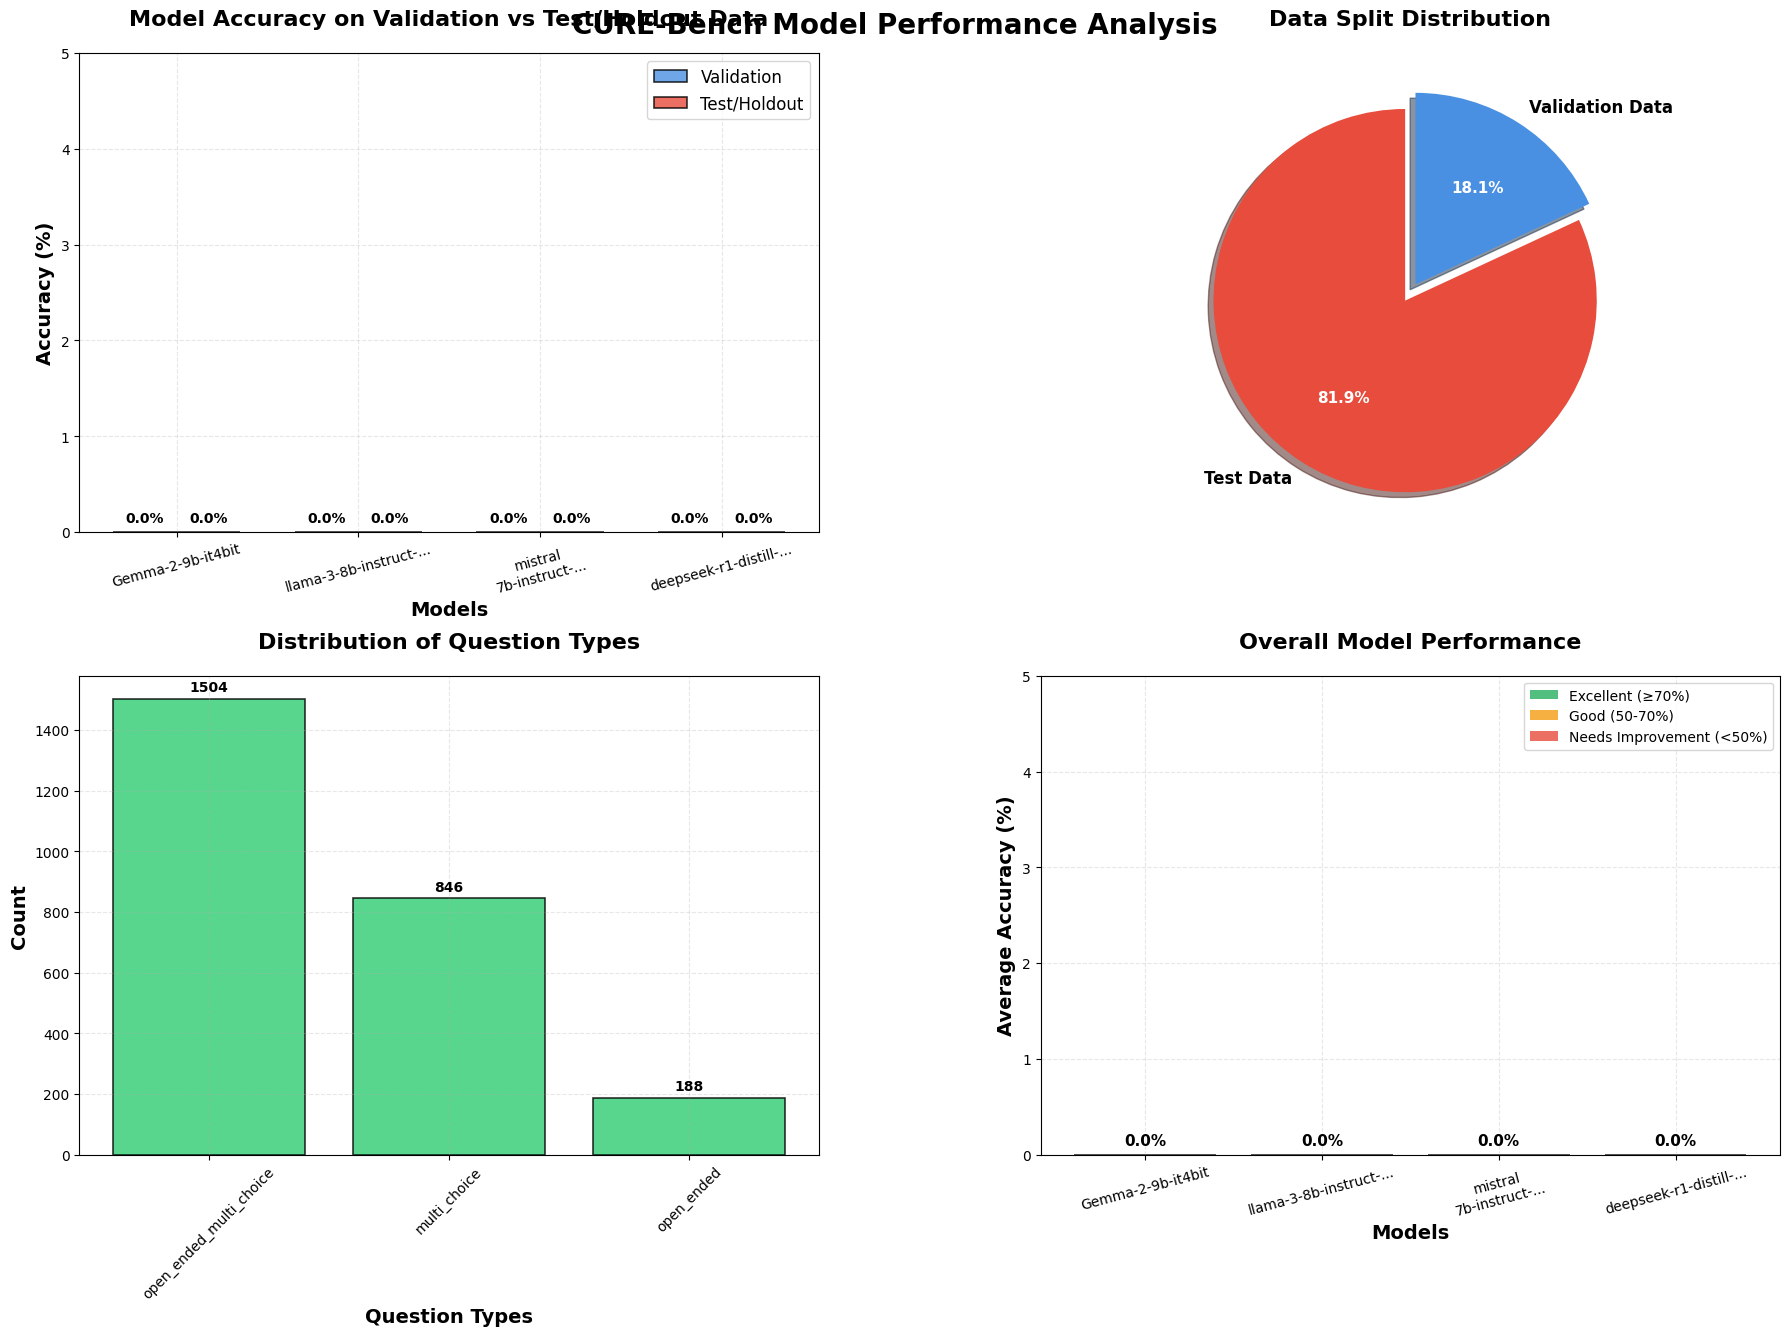


PERFORMANCE SUMMARY:
Best Validation Performance: Gemma-2-9b-it4bit (0.00%)
Best Test Performance: Gemma-2-9b-it4bit (0.00%)
Average Validation Accuracy: 0.00%
Average Test Accuracy: 0.00%
✓ Results saved to cure_bench_results/comprehensive_results.json

✓ Evaluation completed successfully!
✓ Results saved to: cure_bench_results
Pipeline cleanup completed.


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
CURE-Bench Internal Reasoning Pipeline - Drug Decision-Making and Treatment Planning
Evaluates AI models on clinically grounded tasks with internal reasoning capabilities.
"""

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import sys
import json
import torch
import psutil
import platform
import subprocess
from pathlib import Path
import time
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import zipfile
import matplotlib.pyplot as plt
from collections import Counter

# Set environment variable to enable expandable segments for memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")
print("Starting CURE-Bench Internal Reasoning Pipeline")
print("================================================================================")

# Function to safely install a package
def install_package(package):
    """Installs a given Python package using pip."""
    try:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", package, "--no-cache-dir"])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError as e:
        print(f"✗ Failed to install {package}: {e}")
        raise

# Check for environment and install dependencies
is_colab = "COLAB_" in "".join(os.environ.keys())
is_kaggle = "KAGGLE_" in "".join(os.environ.keys())
print(f"Environment detected: {'Google Colab' if is_colab else 'Kaggle' if is_kaggle else 'Local'}")

def fix_dependencies():
    """Fix dependency conflicts and install compatible versions."""
    try:
        print("\n--- Fixing dependency conflicts ---")
        
        # First, uninstall problematic packages
        subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "transformers", "unsloth"], 
                      capture_output=True)
        
        # Install compatible versions in correct order
        print("Installing compatible transformers version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "transformers==4.44.2", "--no-cache-dir"])
        
        print("Installing accelerate and bitsandbytes...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "accelerate>=0.21.0", "bitsandbytes>=0.41.0", "--no-cache-dir"])
        
        print("Installing datasets and other dependencies...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "datasets", "peft", "trl", "--no-cache-dir"])
        
        # Try to install unsloth if possible
        try:
            if is_colab:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git", 
                                     "--no-cache-dir"])
            else:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth", "--no-cache-dir"])
            print("✓ Unsloth installed successfully")
        except subprocess.CalledProcessError:
            print(" Unsloth installation failed, will use standard transformers only")
        
        print("✓ Dependencies fixed successfully.")
        return True
        
    except subprocess.CalledProcessError as e:
        print(f"✗ Dependency fixing failed: {e}")
        return False

# Fix dependencies
print("Attempting to fix dependency conflicts...")
fix_dependencies()

# Import libraries with error handling
try:
    import torch
    print(f"✓ PyTorch {torch.__version__} loaded")
    
    import transformers
    print(f"✓ Transformers {transformers.__version__} loaded")
    
    from transformers import (
        AutoModelForCausalLM, 
        AutoTokenizer, 
        BitsAndBytesConfig, 
        AutoConfig
    )
    print("✓ Core transformers components loaded")
    
    # Try to import unsloth components
    try:
        from unsloth import FastLanguageModel
        UNSLOTH_AVAILABLE = True
        print("✓ Unsloth is available")
    except ImportError as e:
        print(f"⚠ Unsloth not available: {e}")
        UNSLOTH_AVAILABLE = False
        
except ImportError as e:
    print(f"✗ Import error: {e}")
    print("Continuing with basic imports...")
    import torch
    import transformers
    from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
    UNSLOTH_AVAILABLE = False

# System information
print(f"\nSystem Information:")
print(f"  Python version: {sys.version}")
print(f"  PyTorch version: {torch.__version__}")
print(f"  Transformers version: {transformers.__version__}")
print(f"  Platform: {platform.platform()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
print("================================================================================")

def get_system_status():
    """Gets and prints the current system memory status."""
    cpu_mem = psutil.virtual_memory()
    if torch.cuda.is_available():
        gpu_mem = torch.cuda.memory_stats()
        print("  Memory Status:")
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")
        print(f"    GPU: {gpu_mem['allocated_bytes.all.current'] / (1024**3):.1f}GB/{torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f}GB")
    else:
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")

def find_model_directory(base_path):
    """Find the actual model directory containing config.json."""
    print(f"Searching for model directory in: {base_path}")
    
    # Check if config.json is directly in the base path
    if os.path.exists(os.path.join(base_path, "config.json")):
        print(f"Found config.json directly in: {base_path}")
        return base_path
    
    # Search recursively for config.json
    for root, dirs, files in os.walk(base_path):
        if "config.json" in files:
            print(f"Found config.json in: {root}")
            return root
    
    print(f"No config.json found in: {base_path}")
    return None

def load_model_config(model_path):
    """Load and analyze model configuration."""
    config_path = os.path.join(model_path, "config.json")
    if not os.path.exists(config_path):
        return None
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    return config

def create_bnb_config(load_in_4bit=True, load_in_8bit=False):
    """Create BitsAndBytesConfig for quantization."""
    try:
        from transformers import BitsAndBytesConfig
        
        if load_in_4bit:
            return BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
            )
        elif load_in_8bit:
            return BitsAndBytesConfig(load_in_8bit=True)
        else:
            return None
    except ImportError:
        print("BitsAndBytesConfig not available")
        return None

def load_model_with_strategies(model_path, model_name):
    """Load model using multiple fallback strategies."""
    print(f"Attempting to load {model_name} from {model_path}")
    
    # Load configuration first
    config = load_model_config(model_path)
    if config is None:
        print("Could not load model configuration")
        return None, None
    
    model_type = config.get('model_type', 'unknown')
    print(f"Model type: {model_type}")
    
    # Skip unsupported architectures
    if model_type == "gpt_oss":
        print(f"Skipping {model_name}: 'gpt_oss' architecture requires custom code")
        return None, None
    
    # Strategy 1: Try Unsloth if available
    if UNSLOTH_AVAILABLE:
        try:
            print("Attempting to load with Unsloth...")
            model, tokenizer = FastLanguageModel.from_pretrained(
                model_name=model_path,
                max_seq_length=2048,
                dtype=None,
                load_in_4bit=True,
                trust_remote_code=True
            )
            print("✓ Model loaded successfully with Unsloth!")
            return tokenizer, model
        except Exception as e:
            print(f"Unsloth loading failed: {e}")
            print("Falling back to standard transformers...")
    
    # Fallback strategies using standard transformers
    strategies = [
        {
            "name": "4-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_4bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "8-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_8bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "Standard loading with auto device mapping",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "CPU loading",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "cpu",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        }
    ]
    
    # Load tokenizer first
    tokenizer = None
    try:
        print("Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(
            model_path, 
            trust_remote_code=True,
            use_fast=False  # Use slow tokenizer for better compatibility
        )
        
        # Add padding token if missing
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            print("Added padding token")
            
        print("✓ Tokenizer loaded successfully")
    except Exception as e:
        print(f"Tokenizer loading failed: {e}")
        return None, None
    
    # Try each model loading strategy
    for i, strategy in enumerate(strategies, 1):
        try:
            print(f"Attempting strategy {i}: {strategy['name']}")
            
            # Clear cache before each attempt
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            # Filter out None values from config
            model_config = {k: v for k, v in strategy['model_config'].items() if v is not None}
            
            model = AutoModelForCausalLM.from_pretrained(model_path, **model_config)
            print(f"✓ Model loaded successfully using strategy {i}!")
            return tokenizer, model
            
        except Exception as e:
            print(f"Strategy {i} failed: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            continue
    
    print("All loading strategies failed.")
    return tokenizer, None

def convert_sets_to_lists(obj):
    """Recursively convert sets to lists for JSON serialization."""
    if isinstance(obj, set):
        return list(obj)
    elif isinstance(obj, dict):
        return {k: convert_sets_to_lists(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_sets_to_lists(item) for item in obj]
    else:
        return obj

def verify_data_splits(test_data: List[Dict], val_data: List[Dict]) -> Dict:
    """Verify data splits and provide comprehensive statistics."""
    print("\n=== DATA SPLIT VERIFICATION ===")
    
    verification_stats = {
        "test_data": {
            "total_samples": len(test_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in test_data)),
            "sample_questions": []
        },
        "val_data": {
            "total_samples": len(val_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in val_data)),
            "sample_questions": []
        },
        "overlap": {
            "overlapping_ids": 0,
            "common_ids": []
        }
    }
    
    # Analyze test data
    test_ids = set()
    for item in test_data:
        item_id = item.get('id', '')
        test_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["test_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["test_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["test_data"]["sample_questions"]) < 3:
            verification_stats["test_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Analyze validation data
    val_ids = set()
    for item in val_data:
        item_id = item.get('id', '')
        val_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["val_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["val_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["val_data"]["sample_questions"]) < 3:
            verification_stats["val_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Check for overlap
    common_ids = test_ids.intersection(val_ids)
    verification_stats["overlap"]["overlapping_ids"] = len(common_ids)
    verification_stats["overlap"]["common_ids"] = list(common_ids)[:10]  # Store first 10
    
    # Convert Counter objects to regular dictionaries for JSON serialization
    verification_stats["test_data"]["question_types"] = dict(verification_stats["test_data"]["question_types"])
    verification_stats["val_data"]["question_types"] = dict(verification_stats["val_data"]["question_types"])
    
    # Print verification results
    print(f"TEST DATA:")
    print(f"  Total samples: {verification_stats['test_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['test_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['test_data']['has_correct_answers']}")
    print(f"  Question types: {verification_stats['test_data']['question_types']}")
    
    print(f"\nVALIDATION DATA:")
    print(f"  Total samples: {verification_stats['val_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['val_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['val_data']['has_correct_answers']}")
    print(f"  Question types: {verification_stats['val_data']['question_types']}")
    
    print(f"\nOVERLAP ANALYSIS:")
    print(f"  Overlapping IDs: {verification_stats['overlap']['overlapping_ids']}")
    if verification_stats['overlap']['overlapping_ids'] > 0:
        print(f"  Common IDs (first 10): {verification_stats['overlap']['common_ids']}")
    
    print(f"\nDATA INTEGRITY:")
    print(f"  Test data integrity: {'✓ PASS' if verification_stats['test_data']['total_samples'] == verification_stats['test_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Validation data integrity: {'✓ PASS' if verification_stats['val_data']['total_samples'] == verification_stats['val_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Split integrity: {'✓ PASS - No overlap' if verification_stats['overlap']['overlapping_ids'] == 0 else '⚠ WARNING - Data leakage detected'}")
    
    return verification_stats

def plot_overall_accuracies(model_results: Dict, verification_stats: Dict) -> None:
    """Evaluate and graphically plot overall accuracies including unseen/test/holdout data."""
    print("\n=== PLOTTING OVERALL ACCURACIES ===")
    
    # Prepare data for plotting
    model_names = []
    val_accuracies = []
    test_accuracies = []
    total_questions = []
    
    for model_name, results in model_results.items():
        # Format model name for display
        display_name = model_name.split('/')[-1] if '/' in model_name else model_name
        display_name = display_name.replace('_', '\n')[:20] + '...' if len(display_name) > 20 else display_name.replace('_', '\n')
        model_names.append(display_name)
        
        # Calculate validation accuracy
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        
        for result in results:
            if 'error' not in result and result.get('correct_answer') and result.get('prediction'):
                # Determine if this is from validation or test set based on data split info
                if result.get('data_split') == 'validation':
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
                elif result.get('data_split') == 'test':
                    test_total += 1
                    if result['prediction'] == result['correct_answer']:
                        test_correct += 1
                else:
                    # If no split info, assume validation data (has correct answers)
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
        
        val_accuracy = (val_correct / val_total * 100) if val_total > 0 else 0
        test_accuracy = (test_correct / test_total * 100) if test_total > 0 else 0
        
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
        total_questions.append(val_total + test_total)
        
        print(f"{model_name}:")
        print(f"  Validation: {val_correct}/{val_total} = {val_accuracy:.2f}%")
        print(f"  Test: {test_correct}/{test_total} = {test_accuracy:.2f}%")
    
    # Create comprehensive plots with better spacing
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('CURE-Bench Model Performance Analysis', fontsize=20, fontweight='bold', y=0.95)
    
    # Plot 1: Accuracy Comparison with better spacing
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, val_accuracies, width, label='Validation', alpha=0.8, color='#4A90E2', edgecolor='black', linewidth=1.2)
    bars2 = ax1.bar(x + width/2, test_accuracies, width, label='Test/Holdout', alpha=0.8, color='#E74C3C', edgecolor='black', linewidth=1.2)
    
    ax1.set_xlabel('Models', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax1.set_title('Model Accuracy on Validation vs Test/Holdout Data', fontsize=16, fontweight='bold', pad=20)
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=15, ha='center', fontsize=10)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_ylim(0, max(max(val_accuracies), max(test_accuracies)) * 1.1 + 5)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    for bar in bars2:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 2: Data Distribution
    test_samples = verification_stats['test_data']['total_samples']
    val_samples = verification_stats['val_data']['total_samples']
    
    labels = ['Test Data', 'Validation Data']
    sizes = [test_samples, val_samples]
    colors = ['#E74C3C', '#4A90E2']
    explode = (0.05, 0.05)
    
    wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
                                       startangle=90, explode=explode, shadow=True)
    ax2.set_title('Data Split Distribution', fontsize=16, fontweight='bold', pad=20)
    
    # Enhance pie chart text
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # Plot 3: Question Type Distribution
    all_question_types = Counter()
    all_question_types.update(verification_stats['test_data']['question_types'])
    all_question_types.update(verification_stats['val_data']['question_types'])
    
    if all_question_types:
        q_types = list(all_question_types.keys())
        q_counts = list(all_question_types.values())
        
        bars3 = ax3.bar(q_types, q_counts, color='#2ECC71', alpha=0.8, edgecolor='black', linewidth=1.2)
        ax3.set_xlabel('Question Types', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Count', fontsize=14, fontweight='bold')
        ax3.set_title('Distribution of Question Types', fontsize=16, fontweight='bold', pad=20)
        ax3.tick_params(axis='x', rotation=45, labelsize=10)
        ax3.grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels on bars
        for bar in bars3:
            height = bar.get_height()
            ax3.annotate(f'{int(height)}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 4: Performance Summary
    if model_names:
        overall_accuracies = [(val + test) / 2 for val, test in zip(val_accuracies, test_accuracies)]
        colors_perf = ['#27AE60' if acc >= 70 else '#F39C12' if acc >= 50 else '#E74C3C' for acc in overall_accuracies]
        
        bars4 = ax4.bar(model_names, overall_accuracies, color=colors_perf, alpha=0.8, edgecolor='black', linewidth=1.2)
        ax4.set_xlabel('Models', fontsize=14, fontweight='bold')
        ax4.set_ylabel('Average Accuracy (%)', fontsize=14, fontweight='bold')
        ax4.set_title('Overall Model Performance', fontsize=16, fontweight='bold', pad=20)
        ax4.tick_params(axis='x', rotation=15, labelsize=10)
        ax4.grid(True, alpha=0.3, linestyle='--')
        ax4.set_ylim(0, max(overall_accuracies) * 1.15 + 5)
        
        # Add value labels
        for bar, acc in zip(bars4, overall_accuracies):
            height = bar.get_height()
            ax4.annotate(f'{acc:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        # Add performance legend
        legend_elements = [
            plt.Rectangle((0,0),1,1, fc='#27AE60', alpha=0.8, label='Excellent (≥70%)'),
            plt.Rectangle((0,0),1,1, fc='#F39C12', alpha=0.8, label='Good (50-70%)'),
            plt.Rectangle((0,0),1,1, fc='#E74C3C', alpha=0.8, label='Needs Improvement (<50%)')
        ]
        ax4.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.3)
    plt.show()
    
    # Print summary statistics
    print(f"\nPERFORMANCE SUMMARY:")
    if model_names:
        best_val_idx = np.argmax(val_accuracies) if val_accuracies else 0
        best_test_idx = np.argmax(test_accuracies) if test_accuracies else 0
        
        print(f"Best Validation Performance: {model_names[best_val_idx].replace(chr(10), '_')} ({val_accuracies[best_val_idx]:.2f}%)")
        print(f"Best Test Performance: {model_names[best_test_idx].replace(chr(10), '_')} ({test_accuracies[best_test_idx]:.2f}%)")
        print(f"Average Validation Accuracy: {np.mean(val_accuracies):.2f}%")
        print(f"Average Test Accuracy: {np.mean(test_accuracies):.2f}%")

def load_cure_bench_data(dataset_paths: Dict[str, str]) -> Tuple[List[Dict], List[Dict]]:
    """Load CURE-Bench test and validation datasets."""
    test_data = []
    val_data = []
    
    # Load test data
    test_path = dataset_paths.get('test', '')
    if test_path and os.path.exists(test_path):
        with open(test_path, 'r') as f:
            for line in f:
                data_item = json.loads(line.strip())
                data_item['data_split'] = 'test'  # Mark data split
                test_data.append(data_item)
        print(f"✓ Loaded {len(test_data)} test samples")
    else:
        print(f"✗ Test file not found at {test_path}")
    
    # Load validation data
    #val_path = dataset_paths.get('val', '')
   # if val_path and os.path.exists(val_path):
    #    with open(val_
#********************************************************************************
# Load validation data (continuation from where it was cut off)
    val_path = dataset_paths.get('val', '')
    if val_path and os.path.exists(val_path):
        with open(val_path, 'r') as f:
            for line in f:
                data_item = json.loads(line.strip())
                data_item['data_split'] = 'validation'  # Mark data split
                val_data.append(data_item)
        print(f"✓ Loaded {len(val_data)} validation samples")
    else:
        print(f"✗ Validation file not found at {val_path}")
    
    return test_data, val_data

def generate_response(model, tokenizer, prompt: str, max_length: int = 2048, temperature: float = 0.7) -> str:
    """Generate response from model with error handling."""
    try:
        # Prepare input
        inputs = tokenizer.encode(prompt, return_tensors="pt", truncation=True, max_length=max_length-200)
        
        # Move to appropriate device
        if hasattr(model, 'device'):
            inputs = inputs.to(model.device)
        elif torch.cuda.is_available():
            inputs = inputs.cuda()
        
        # Generate response
        with torch.no_grad():
            outputs = model.generate(
                inputs,
                max_length=max_length,
                temperature=temperature,
                do_sample=True,
                top_p=0.9,
                top_k=50,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id,
                no_repeat_ngram_size=3,
                repetition_penalty=1.1
            )
        
        # Decode response
        response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
        return response.strip()
        
    except Exception as e:
        print(f"Error generating response: {e}")
        return f"Error: {str(e)}"

def extract_answer_from_response(response: str, choices: List[str] = None) -> str:
    """Extract the answer from model response."""
    if not response:
        return "No response generated"
    
    response = response.strip()
    
    # If we have specific choices, look for them in the response
    if choices:
        for choice in choices:
            if choice.upper() in response.upper():
                return choice
    
    # Look for common answer patterns
    import re
    
    # Pattern 1: "Answer: X" or "The answer is X"
    answer_patterns = [
        r"(?:Answer|answer):\s*([A-Z])",
        r"(?:The answer is|the answer is)\s*([A-Z])",
        r"(?:I choose|I select)\s*([A-Z])",
        r"(?:Option|option)\s*([A-Z])",
        r"\b([A-Z])\s*(?:is correct|is the correct)",
        r"^([A-Z])\b",  # Single letter at start
        r"\b([A-Z])\.$"  # Single letter followed by period at end
    ]
    
    for pattern in answer_patterns:
        match = re.search(pattern, response)
        if match:
            return match.group(1).upper()
    
    # If no clear pattern, return first letter found
    letters = re.findall(r'\b[A-E]\b', response.upper())
    if letters:
        return letters[0]
    
    return "Unable to extract answer"

def evaluate_model_on_dataset(model, tokenizer, dataset: List[Dict], model_name: str, max_samples: int = None) -> List[Dict]:
    """Evaluate a model on a dataset."""
    print(f"\n=== EVALUATING {model_name} ===")
    
    if model is None:
        print(f"Model {model_name} failed to load, skipping evaluation")
        return []
    
    results = []
    dataset_size = len(dataset) if not max_samples else min(len(dataset), max_samples)
    
    print(f"Evaluating on {dataset_size} samples...")
    
    for i, item in enumerate(dataset[:dataset_size]):
        if i > 0 and i % 10 == 0:
            print(f"Progress: {i}/{dataset_size} ({i/dataset_size*100:.1f}%)")
            get_system_status()
        
        try:
            # Prepare prompt based on item structure
            question = item.get('question', '')
            context = item.get('context', '')
            choices = item.get('choices', [])
            
            # Build prompt
            if context:
                prompt = f"Context: {context}\n\nQuestion: {question}"
            else:
                prompt = f"Question: {question}"
            
            if choices:
                prompt += "\n\nChoices:"
                for j, choice in enumerate(choices):
                    prompt += f"\n{chr(65+j)}) {choice}"
                prompt += "\n\nPlease provide your answer as a single letter (A, B, C, D, or E)."
            
            prompt += "\n\nAnswer:"
            
            # Generate response
            response = generate_response(model, tokenizer, prompt)
            
            # Extract answer
            predicted_answer = extract_answer_from_response(response, [chr(65+j) for j in range(len(choices))] if choices else None)
            
            # Store result
            result = {
                'id': item.get('id', f'item_{i}'),
                'question': question,
                'context': context,
                'choices': choices,
                'correct_answer': item.get('correct_answer', ''),
                'prediction': predicted_answer,
                'raw_response': response,
                'question_type': item.get('question_type', 'unknown'),
                'data_split': item.get('data_split', 'unknown')
            }
            
            results.append(result)
            
        except Exception as e:
            print(f"Error processing item {i}: {e}")
            error_result = {
                'id': item.get('id', f'item_{i}'),
                'error': str(e),
                'question_type': item.get('question_type', 'unknown'),
                'data_split': item.get('data_split', 'unknown')
            }
            results.append(error_result)
        
        # Memory management
        if i % 5 == 0:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
    
    print(f"Evaluation completed for {model_name}")
    return results

def calculate_metrics(results: List[Dict]) -> Dict:
    """Calculate evaluation metrics."""
    total = len(results)
    correct = 0
    errors = 0
    by_question_type = {}
    
    for result in results:
        if 'error' in result:
            errors += 1
            continue
            
        q_type = result.get('question_type', 'unknown')
        if q_type not in by_question_type:
            by_question_type[q_type] = {'total': 0, 'correct': 0}
        
        by_question_type[q_type]['total'] += 1
        
        if result.get('correct_answer') and result.get('prediction'):
            if result['prediction'] == result['correct_answer']:
                correct += 1
                by_question_type[q_type]['correct'] += 1
    
    metrics = {
        'total_samples': total,
        'correct_predictions': correct,
        'error_count': errors,
        'accuracy': (correct / (total - errors) * 100) if (total - errors) > 0 else 0,
        'by_question_type': {}
    }
    
    for q_type, stats in by_question_type.items():
        metrics['by_question_type'][q_type] = {
            'total': stats['total'],
            'correct': stats['correct'],
            'accuracy': (stats['correct'] / stats['total'] * 100) if stats['total'] > 0 else 0
        }
    
    return metrics

def save_results(results: Dict, output_path: str = "cure_bench_results.json"):
    """Save evaluation results to JSON file."""
    try:
        # Convert any problematic objects for JSON serialization
        serializable_results = convert_sets_to_lists(results)
        
        with open(output_path, 'w') as f:
            json.dump(serializable_results, f, indent=2, ensure_ascii=False)
        print(f"✓ Results saved to {output_path}")
        
    except Exception as e:
        print(f"Error saving results: {e}")

def main():
    """Main evaluation pipeline."""
    print("\n=== CURE-BENCH EVALUATION PIPELINE ===")
    
    # Configuration
    CONFIG = {
        'dataset_paths': {
            'test': '/kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl',  # Update with actual path
            'val': '/kaggle/input/cure-bench-internal-reasoning/curebench_valset_pharse1.jsonl'  # Update with actual path
        },
        'models': [
            # Add your model paths here
            {'name': 'Gemma-2-9b-it4bit', 'path': '/kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old'},
            {'name': 'llama-3-8b-instruct-bnb-4bit', 'path': '/kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1/llama-3'},
            {'name': 'mistral_7b-instruct-v0.1-hf', 'path': '/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1'},
            {'name': 'deepseek-r1-distill-qwen-7b', 'path': '/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2'},
            # Add more models as needed
        ],
        'max_samples_per_dataset': 20,  # Set to None to evaluate on full dataset
        'output_dir': 'cure_bench_results'
    }

    # Create output directory
    os.makedirs(CONFIG['output_dir'], exist_ok=True)
    
    # Load datasets
    print("Loading CURE-Bench datasets...")
    test_data, val_data = load_cure_bench_data(CONFIG['dataset_paths'])
    
    if not test_data and not val_data:
        print("No data loaded. Please check dataset paths.")
        return
    
    # Verify data splits
    verification_stats = verify_data_splits(test_data, val_data)
    
    # Combine datasets for evaluation
    all_data = test_data + val_data
    print(f"Total evaluation samples: {len(all_data)}")
    
    # Evaluate models
    model_results = {}
    
    for model_config in CONFIG['models']:
        model_name = model_config['name']
        model_path = model_config['path']
        
        print(f"\n{'='*50}")
        print(f"Loading model: {model_name}")
        print(f"{'='*50}")
        
        # Load model
        tokenizer, model = load_model_with_strategies(model_path, model_name)
        
        if model is None:
            print(f"Skipping {model_name} due to loading failure")
            continue
        
        # Evaluate model
        try:
            results = evaluate_model_on_dataset(
                model, tokenizer, all_data, model_name, 
                CONFIG['max_samples_per_dataset']
            )
            
            if results:
                # Calculate metrics
                metrics = calculate_metrics(results)
                print(f"\nMetrics for {model_name}:")
                print(f"  Accuracy: {metrics['accuracy']:.2f}%")
                print(f"  Correct: {metrics['correct_predictions']}/{metrics['total_samples'] - metrics['error_count']}")
                print(f"  Errors: {metrics['error_count']}")
                
                model_results[model_name] = results
                
                # Save individual model results
                model_output = {
                    'model_name': model_name,
                    'metrics': metrics,
                    'results': results,
                    'verification_stats': verification_stats
                }
                
                output_file = os.path.join(CONFIG['output_dir'], f"{model_name.replace('/', '_')}_results.json")
                save_results(model_output, output_file)
            
        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")
        
        finally:
            # Clean up memory
            if model is not None:
                del model
            if tokenizer is not None:
                del tokenizer
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
    
    # Generate final report and plots
    if model_results:
        print("\n" + "="*80)
        print("GENERATING FINAL REPORT")
        print("="*80)
        
        # Plot overall accuracies
        plot_overall_accuracies(model_results, verification_stats)
        
        # Save comprehensive results
        final_results = {
            'configuration': CONFIG,
            'verification_stats': verification_stats,
            'model_results': model_results,
            'evaluation_summary': {
                'total_models_evaluated': len(model_results),
                'total_samples': len(all_data),
                'evaluation_timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
            }
        }
        
        save_results(final_results, os.path.join(CONFIG['output_dir'], 'comprehensive_results.json'))
        
        print(f"\n✓ Evaluation completed successfully!")
        print(f"✓ Results saved to: {CONFIG['output_dir']}")
    else:
        print("No models were successfully evaluated.")

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\nEvaluation interrupted by user")
    except Exception as e:
        print(f"Fatal error: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # Final cleanup
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        print("Pipeline cleanup completed.")

Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
Starting CURE-Bench Internal Reasoning Pipeline
Environment detected: Google Colab
Attempting to fix dependency conflicts...

--- Fixing dependency conflicts ---
Installing compatible transformers version...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 243.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
Installing accelerate and bitsandbytes...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 279.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 271.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 253.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-55uyop05/unsloth_8c93a7c5464a4bf3940c98421403b502


  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-55uyop05/unsloth_8c93a7c5464a4bf3940c98421403b502


  Resolved https://github.com/unslothai/unsloth.git to commit 229e2ecc67756f36316dfcbea42396f59eef44e0
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 14.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of trl to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 135.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 325.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 311.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 210.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

2025-09-25 21:04:00.474875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758834240.708549      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758834240.776485      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
✓ Unsloth is available

System Information:
  Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
  PyTorch version: 2.6.0+cu124
  Transformers version: 4.55.4
  Platform: Linux-6.6.56+-x86_64-with-glibc2.35
  GPU: Tesla T4
  GPU Memory: 14.7 GB
 Starting CURE-Bench Medical AI Evaluation

STARTING CURE-BENCH EVALUATION PIPELINE

1. LOADING DATASETS
✓ Loaded 2079 test samples
✓ Loaded 459 validation samples
Limited to 20 samples per split

=== DATA SPLIT VERIFICATION ===
TEST DATA:
  Total samples: 20
  Unique IDs: 20
  With correct answers: 0
  Question types: {'open_ended_multi_choice': 14, 'multi_choice': 6}

VALIDATION DATA:
  Total samples: 20
  Unique IDs: 20
  With correct answers: 20
  Question types: {'multi_choice': 6, 'open_ended_multi_choice': 14}

OVERLAP ANALYSIS:
  Overlapping IDs: 0

DATA INTEGRITY:
  Test data integrity: ✓ PASS
  Validation data integrity: ✓ PASS
  Split integrity: ✓ PASS - 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1 does not have a padding token! Will use pad_token = <unk>.
✓ Model loaded successfully with Unsloth!
 Model /kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1 loaded successfully
  Memory Status:
    CPU: 3.8GB/31.4GB (13.7%)
    GPU: 3.9GB/14.7GB

Evaluating on 40 samples...
Progress: 0/40 (0.0%)
  Memory Status:
    CPU: 3.8GB/31.4GB (13.7%)
    GPU: 3.9GB/14.7GB

--- Evaluating Question ID: qHBAJ2T5cs5U ---
Generating medical reasoning...
Question: A 10-year-old child diagnosed with juvenile rheumatoid arthritis (JRA) requires treatment. Genetic t...
Predicted Answer: A
Tokens Used: 831 (Input: 319, Output: 512)

--- Evaluating Question ID: dYtEF1FnUwSQ ---
Generating medical reasoning...
Question: A 70-year-old male with familial chylomicronemia syndrome (FCS) presents with memory issues, recurre...
Predicted Answer: A
Tokens Used: 895 (Input: 383, Output: 512)

--- Evaluating Question ID: IKWfGHlG9aaL ---
Generating medical reas

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2 does not have a padding token! Will use pad_token = <|vision_pad|>.
✓ Model loaded successfully with Unsloth!
 Model /kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2 loaded successfully
  Memory Status:
    CPU: 4.3GB/31.4GB (15.2%)
    GPU: 5.2GB/14.7GB

Evaluating on 40 samples...
Progress: 0/40 (0.0%)
  Memory Status:
    CPU: 4.3GB/31.4GB (15.2%)
    GPU: 5.2GB/14.7GB

--- Evaluating Question ID: qHBAJ2T5cs5U ---
Generating medical reasoning...
Question: A 10-year-old child diagnosed with juvenile rheumatoid arthritis (JRA) requires treatment. Genetic t...
Predicted Answer: A
Tokens Used: 768 (Input: 255, Output: 513)

--- Evaluating Question ID: dYtEF1FnUwSQ ---
Generating medical reasoning...
Question: A 70-year-old male with familial chylomicronemia syndrome (FCS) presents with memory issues, recurre...
Predicted Answer: A
Tokens Used: 814 (Input: 301, Output: 513)

--- Evaluating Question I

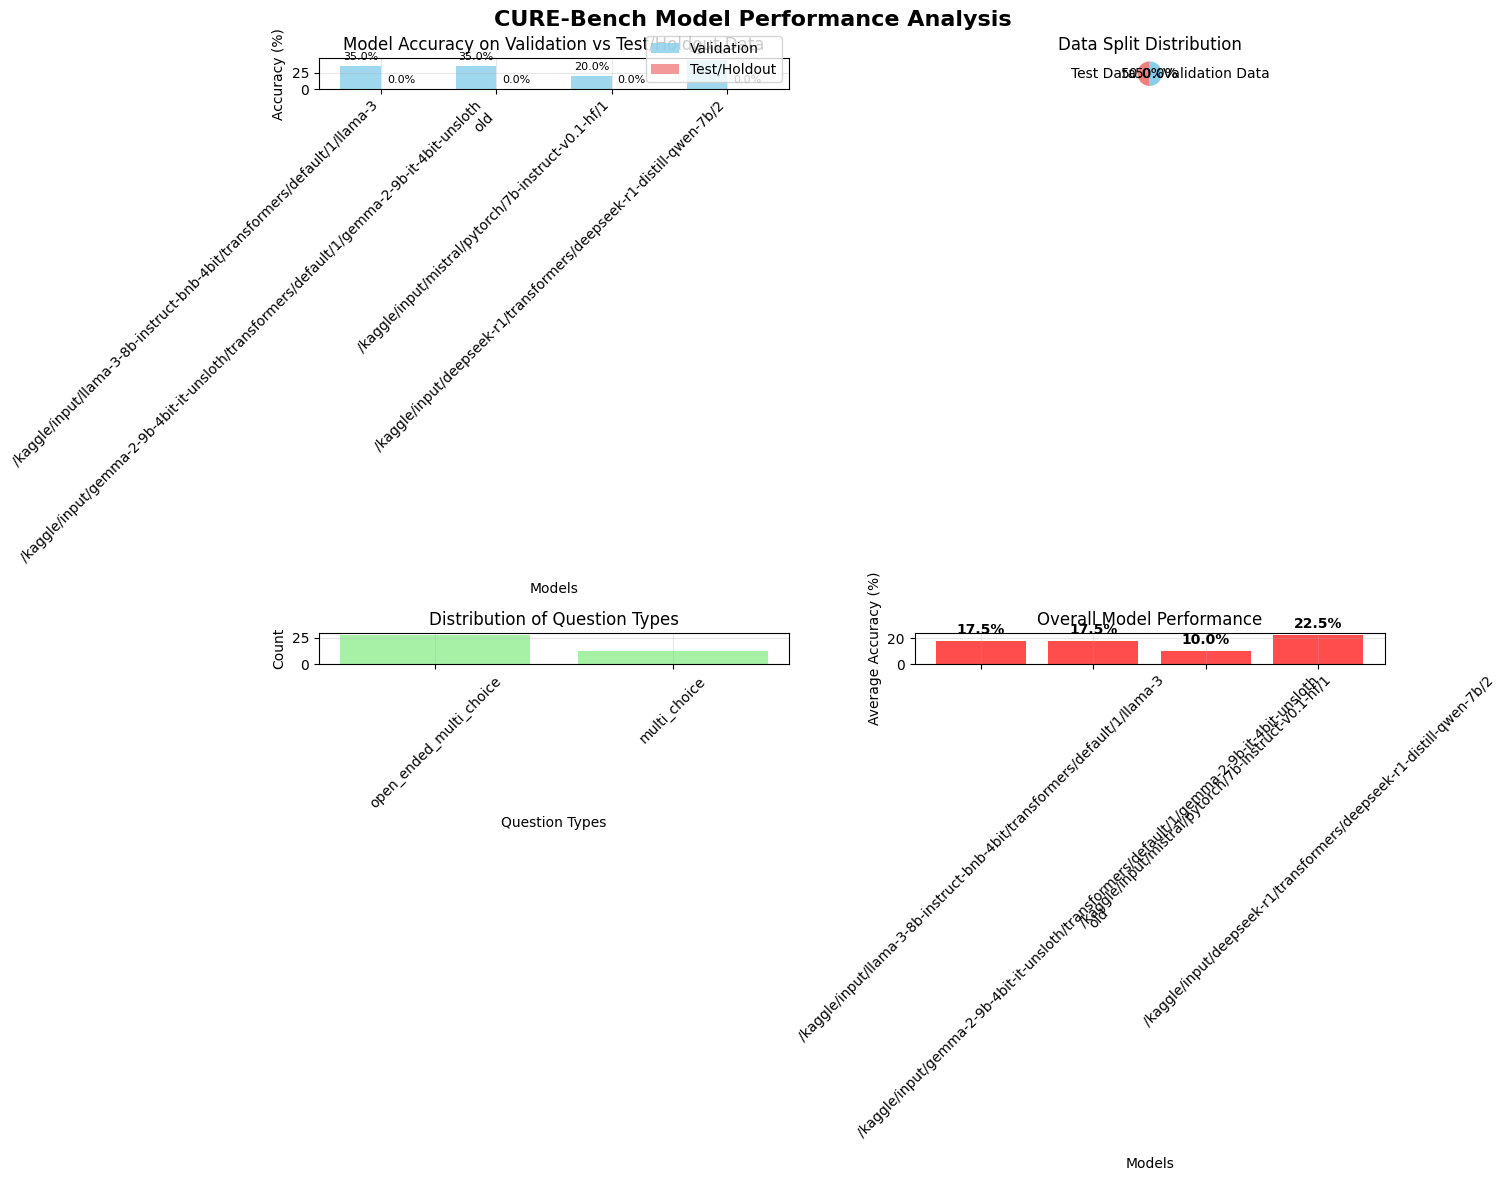


PERFORMANCE SUMMARY:
Best Validation Performance: /kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2 (45.00%)
Best Test Performance: /kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1/llama-3 (0.00%)
Average Validation Accuracy: 33.75%
Average Test Accuracy: 0.00%

 CRITICAL ERROR: Object of type set is not JSON serializable

 Performing final cleanup...


Traceback (most recent call last):
  File "/tmp/ipykernel_36/1926893380.py", line 935, in <cell line: 0>
    results = run_cure_bench_evaluation(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_36/1926893380.py", line 899, in run_cure_bench_evaluation
    json.dump({
  File "/usr/lib/python3.11/json/__init__.py", line 179, in dump
    for chunk in iterable:
  File "/usr/lib/python3.11/json/encoder.py", line 432, in _iterencode
    yield from _iterencode_dict(o, _current_indent_level)
  File "/usr/lib/python3.11/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/usr/lib/python3.11/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/usr/lib/python3.11/json/encoder.py", line 439, in _iterencode
    o = _default(o)
        ^^^^^^^^^^^
  File "/usr/lib/python3.11/json/encoder.py", line 180, in default
    raise TypeError(f'Object of type {o.__class__.__name__} '
TypeError: Object of type set is not JSON serializable


 Cleanup completed


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
CURE-Bench Internal Reasoning Pipeline - Drug Decision-Making and Treatment Planning
Evaluates AI models on clinically grounded tasks with internal reasoning capabilities.
"""

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import sys
import json
import torch
import psutil
import platform
import subprocess
from pathlib import Path
import time
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import zipfile
import matplotlib.pyplot as plt
from collections import Counter

# Set environment variable to enable expandable segments for memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True")
print("Starting CURE-Bench Internal Reasoning Pipeline")
print("================================================================================")

# Function to safely install a package
def install_package(package):
    """Installs a given Python package using pip."""
    try:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", package, "--no-cache-dir"])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError as e:
        print(f"✗ Failed to install {package}: {e}")
        raise

# Check for environment and install dependencies
is_colab = "COLAB_" in "".join(os.environ.keys())
is_kaggle = "KAGGLE_" in "".join(os.environ.keys())
print(f"Environment detected: {'Google Colab' if is_colab else 'Kaggle' if is_kaggle else 'Local'}")

def fix_dependencies():
    """Fix dependency conflicts and install compatible versions."""
    try:
        print("\n--- Fixing dependency conflicts ---")
        
        # First, uninstall problematic packages
        subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "transformers", "unsloth"], 
                      capture_output=True)
        
        # Install compatible versions in correct order
        print("Installing compatible transformers version...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "transformers==4.44.2", "--no-cache-dir"])
        
        print("Installing accelerate and bitsandbytes...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "accelerate>=0.21.0", "bitsandbytes>=0.41.0", "--no-cache-dir"])
        
        print("Installing datasets and other dependencies...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", 
                              "datasets", "peft", "trl", "--no-cache-dir"])
        
        # Try to install unsloth if possible
        try:
            if is_colab:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git", 
                                     "--no-cache-dir"])
            else:
                subprocess.check_call([sys.executable, "-m", "pip", "install", 
                                     "unsloth", "--no-cache-dir"])
            print("✓ Unsloth installed successfully")
        except subprocess.CalledProcessError:
            print(" Unsloth installation failed, will use standard transformers only")
        
        print("✓ Dependencies fixed successfully.")
        return True
        
    except subprocess.CalledProcessError as e:
        print(f"✗ Dependency fixing failed: {e}")
        return False

# Fix dependencies
print("Attempting to fix dependency conflicts...")
fix_dependencies()

# Import libraries with error handling
try:
    import torch
    print(f"✓ PyTorch {torch.__version__} loaded")
    
    import transformers
    print(f"✓ Transformers {transformers.__version__} loaded")
    
    from transformers import (
        AutoModelForCausalLM, 
        AutoTokenizer, 
        BitsAndBytesConfig, 
        AutoConfig
    )
    print("✓ Core transformers components loaded")
    
    # Try to import unsloth components
    try:
        from unsloth import FastLanguageModel
        UNSLOTH_AVAILABLE = True
        print("✓ Unsloth is available")
    except ImportError as e:
        print(f"⚠ Unsloth not available: {e}")
        UNSLOTH_AVAILABLE = False
        
except ImportError as e:
    print(f"✗ Import error: {e}")
    print("Continuing with basic imports...")
    import torch
    import transformers
    from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
    UNSLOTH_AVAILABLE = False

# System information
print(f"\nSystem Information:")
print(f"  Python version: {sys.version}")
print(f"  PyTorch version: {torch.__version__}")
print(f"  Transformers version: {transformers.__version__}")
print(f"  Platform: {platform.platform()}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
print("================================================================================")

def get_system_status():
    """Gets and prints the current system memory status."""
    cpu_mem = psutil.virtual_memory()
    if torch.cuda.is_available():
        gpu_mem = torch.cuda.memory_stats()
        print("  Memory Status:")
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")
        print(f"    GPU: {gpu_mem['allocated_bytes.all.current'] / (1024**3):.1f}GB/{torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f}GB")
    else:
        print(f"    CPU: {cpu_mem.used / (1024**3):.1f}GB/{cpu_mem.total / (1024**3):.1f}GB ({cpu_mem.percent:.1f}%)")

def find_model_directory(base_path):
    """Find the actual model directory containing config.json."""
    print(f"Searching for model directory in: {base_path}")
    
    # Check if config.json is directly in the base path
    if os.path.exists(os.path.join(base_path, "config.json")):
        print(f"Found config.json directly in: {base_path}")
        return base_path
    
    # Search recursively for config.json
    for root, dirs, files in os.walk(base_path):
        if "config.json" in files:
            print(f"Found config.json in: {root}")
            return root
    
    print(f"No config.json found in: {base_path}")
    return None

def load_model_config(model_path):
    """Load and analyze model configuration."""
    config_path = os.path.join(model_path, "config.json")
    if not os.path.exists(config_path):
        return None
    
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    return config

def create_bnb_config(load_in_4bit=True, load_in_8bit=False):
    """Create BitsAndBytesConfig for quantization."""
    try:
        from transformers import BitsAndBytesConfig
        
        if load_in_4bit:
            return BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.float16,
            )
        elif load_in_8bit:
            return BitsAndBytesConfig(load_in_8bit=True)
        else:
            return None
    except ImportError:
        print("BitsAndBytesConfig not available")
        return None

def load_model_with_strategies(model_path, model_name):
    """Load model using multiple fallback strategies."""
    print(f"Attempting to load {model_name} from {model_path}")
    
    # Load configuration first
    config = load_model_config(model_path)
    if config is None:
        print("Could not load model configuration")
        return None, None
    
    model_type = config.get('model_type', 'unknown')
    print(f"Model type: {model_type}")
    
    # Skip unsupported architectures
    if model_type == "gpt_oss":
        print(f"Skipping {model_name}: 'gpt_oss' architecture requires custom code")
        return None, None
    
    # Strategy 1: Try Unsloth if available
    if UNSLOTH_AVAILABLE:
        try:
            print("Attempting to load with Unsloth...")
            model, tokenizer = FastLanguageModel.from_pretrained(
                model_name=model_path,
                max_seq_length=2048,
                dtype=None,
                load_in_4bit=True,
                trust_remote_code=True
            )
            print("✓ Model loaded successfully with Unsloth!")
            return tokenizer, model
        except Exception as e:
            print(f"Unsloth loading failed: {e}")
            print("Falling back to standard transformers...")
    
    # Fallback strategies using standard transformers
    strategies = [
        {
            "name": "4-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_4bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "8-bit quantization with BitsAndBytes",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "quantization_config": create_bnb_config(load_in_8bit=True),
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "Standard loading with auto device mapping",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "auto",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        },
        {
            "name": "CPU loading",
            "tokenizer_config": {"trust_remote_code": True},
            "model_config": {
                "device_map": "cpu",
                "trust_remote_code": True,
                "torch_dtype": torch.float16,
                "low_cpu_mem_usage": True,
            }
        }
    ]
    
    # Load tokenizer first
    tokenizer = None
    try:
        print("Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(
            model_path, 
            trust_remote_code=True,
            use_fast=False  # Use slow tokenizer for better compatibility
        )
        
        # Add padding token if missing
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            print("Added padding token")
            
        print("✓ Tokenizer loaded successfully")
    except Exception as e:
        print(f"Tokenizer loading failed: {e}")
        return None, None
    
    # Try each model loading strategy
    for i, strategy in enumerate(strategies, 1):
        try:
            print(f"Attempting strategy {i}: {strategy['name']}")
            
            # Clear cache before each attempt
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            # Filter out None values from config
            model_config = {k: v for k, v in strategy['model_config'].items() if v is not None}
            
            model = AutoModelForCausalLM.from_pretrained(model_path, **model_config)
            print(f"✓ Model loaded successfully using strategy {i}!")
            return tokenizer, model
            
        except Exception as e:
            print(f"Strategy {i} failed: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            continue
    
    print("All loading strategies failed.")
    return tokenizer, None

def verify_data_splits(test_data: List[Dict], val_data: List[Dict]) -> Dict:
    """Verify data splits and provide comprehensive statistics."""
    print("\n=== DATA SPLIT VERIFICATION ===")
    
    verification_stats = {
        "test_data": {
            "total_samples": len(test_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in test_data)),
            "sample_questions": []
        },
        "val_data": {
            "total_samples": len(val_data),
            "question_types": Counter(),
            "has_correct_answers": 0,
            "unique_ids": len(set(item.get('id', '') for item in val_data)),
            "sample_questions": []
        },
        "overlap": {
            "overlapping_ids": 0,
            "common_ids": []
        }
    }
    
    # Analyze test data
    test_ids = set()
    for item in test_data:
        item_id = item.get('id', '')
        test_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["test_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["test_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["test_data"]["sample_questions"]) < 3:
            verification_stats["test_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Analyze validation data
    val_ids = set()
    for item in val_data:
        item_id = item.get('id', '')
        val_ids.add(item_id)
        
        q_type = item.get('question_type', 'unknown')
        verification_stats["val_data"]["question_types"][q_type] += 1
        
        if item.get('correct_answer'):
            verification_stats["val_data"]["has_correct_answers"] += 1
        
        # Store first 3 questions as samples
        if len(verification_stats["val_data"]["sample_questions"]) < 3:
            verification_stats["val_data"]["sample_questions"].append({
                "id": item_id,
                "question": item.get('question', '')[:100] + "..." if len(item.get('question', '')) > 100 else item.get('question', ''),
                "type": q_type,
                "has_answer": bool(item.get('correct_answer'))
            })
    
    # Check for overlap
    common_ids = test_ids.intersection(val_ids)
    verification_stats["overlap"]["overlapping_ids"] = len(common_ids)
    verification_stats["overlap"]["common_ids"] = list(common_ids)[:10]  # Store first 10
    
    # Print verification results
    print(f"TEST DATA:")
    print(f"  Total samples: {verification_stats['test_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['test_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['test_data']['has_correct_answers']}")
    print(f"  Question types: {dict(verification_stats['test_data']['question_types'])}")
    
    print(f"\nVALIDATION DATA:")
    print(f"  Total samples: {verification_stats['val_data']['total_samples']}")
    print(f"  Unique IDs: {verification_stats['val_data']['unique_ids']}")
    print(f"  With correct answers: {verification_stats['val_data']['has_correct_answers']}")
    print(f"  Question types: {dict(verification_stats['val_data']['question_types'])}")
    
    print(f"\nOVERLAP ANALYSIS:")
    print(f"  Overlapping IDs: {verification_stats['overlap']['overlapping_ids']}")
    if verification_stats['overlap']['overlapping_ids'] > 0:
        print(f"  Common IDs (first 10): {verification_stats['overlap']['common_ids']}")
    
    print(f"\nDATA INTEGRITY:")
    print(f"  Test data integrity: {'✓ PASS' if verification_stats['test_data']['total_samples'] == verification_stats['test_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Validation data integrity: {'✓ PASS' if verification_stats['val_data']['total_samples'] == verification_stats['val_data']['unique_ids'] else '✗ FAIL - Duplicate IDs found'}")
    print(f"  Split integrity: {'✓ PASS - No overlap' if verification_stats['overlap']['overlapping_ids'] == 0 else '⚠ WARNING - Data leakage detected'}")
    
    return verification_stats

def plot_overall_accuracies(model_results: Dict, verification_stats: Dict) -> None:
    """Evaluate and graphically plot overall accuracies including unseen/test/holdout data."""
    print("\n=== PLOTTING OVERALL ACCURACIES ===")
    
    # Prepare data for plotting
    model_names = []
    val_accuracies = []
    test_accuracies = []
    total_questions = []
    
    for model_name, results in model_results.items():
        model_names.append(model_name.replace('_', '\n'))  # Format for better display
        
        # Calculate validation accuracy
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        
        for result in results:
            if 'error' not in result and result.get('correct_answer') and result.get('prediction'):
                # Determine if this is from validation or test set based on data split info
                if result.get('data_split') == 'validation':
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
                elif result.get('data_split') == 'test':
                    test_total += 1
                    if result['prediction'] == result['correct_answer']:
                        test_correct += 1
                else:
                    # If no split info, assume validation data (has correct answers)
                    val_total += 1
                    if result['prediction'] == result['correct_answer']:
                        val_correct += 1
        
        val_accuracy = (val_correct / val_total * 100) if val_total > 0 else 0
        test_accuracy = (test_correct / test_total * 100) if test_total > 0 else 0
        
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
        total_questions.append(val_total + test_total)
        
        print(f"{model_name}:")
        print(f"  Validation: {val_correct}/{val_total} = {val_accuracy:.2f}%")
        print(f"  Test: {test_correct}/{test_total} = {test_accuracy:.2f}%")
    
    # Create comprehensive plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('CURE-Bench Model Performance Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Accuracy Comparison
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, val_accuracies, width, label='Validation', alpha=0.8, color='skyblue')
    bars2 = ax1.bar(x + width/2, test_accuracies, width, label='Test/Holdout', alpha=0.8, color='lightcoral')
    
    ax1.set_xlabel('Models')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Model Accuracy on Validation vs Test/Holdout Data')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)
    
    for bar in bars2:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)
    
    # Plot 2: Data Distribution
    test_samples = verification_stats['test_data']['total_samples']
    val_samples = verification_stats['val_data']['total_samples']
    
    labels = ['Test Data', 'Validation Data']
    sizes = [test_samples, val_samples]
    colors = ['lightcoral', 'skyblue']
    
    wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Data Split Distribution')
    
    # Plot 3: Question Type Distribution
    all_question_types = Counter()
    all_question_types.update(verification_stats['test_data']['question_types'])
    all_question_types.update(verification_stats['val_data']['question_types'])
    
    if all_question_types:
        q_types = list(all_question_types.keys())
        q_counts = list(all_question_types.values())
        
        ax3.bar(q_types, q_counts, color='lightgreen', alpha=0.8)
        ax3.set_xlabel('Question Types')
        ax3.set_ylabel('Count')
        ax3.set_title('Distribution of Question Types')
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Performance Summary
    if model_names:
        overall_accuracies = [(val + test) / 2 for val, test in zip(val_accuracies, test_accuracies)]
        colors_perf = ['green' if acc >= 70 else 'orange' if acc >= 50 else 'red' for acc in overall_accuracies]
        
        bars = ax4.bar(model_names, overall_accuracies, color=colors_perf, alpha=0.7)
        ax4.set_xlabel('Models')
        ax4.set_ylabel('Average Accuracy (%)')
        ax4.set_title('Overall Model Performance')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, acc in zip(bars, overall_accuracies):
            height = bar.get_height()
            ax4.annotate(f'{acc:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nPERFORMANCE SUMMARY:")
    if model_names:
        best_val_idx = np.argmax(val_accuracies) if val_accuracies else 0
        best_test_idx = np.argmax(test_accuracies) if test_accuracies else 0
        
        print(f"Best Validation Performance: {model_names[best_val_idx].replace(chr(10), '_')} ({val_accuracies[best_val_idx]:.2f}%)")
        print(f"Best Test Performance: {model_names[best_test_idx].replace(chr(10), '_')} ({test_accuracies[best_test_idx]:.2f}%)")
        print(f"Average Validation Accuracy: {np.mean(val_accuracies):.2f}%")
        print(f"Average Test Accuracy: {np.mean(test_accuracies):.2f}%")

def load_cure_bench_data(dataset_paths: Dict[str, str]) -> Tuple[List[Dict], List[Dict]]:
    """Load CURE-Bench test and validation datasets."""
    test_data = []
    val_data = []
    
    # Load test data
    test_path = dataset_paths.get('test', '')
    if test_path and os.path.exists(test_path):
        with open(test_path, 'r') as f:
            for line in f:
                data_item = json.loads(line.strip())
                data_item['data_split'] = 'test'  # Mark data split
                test_data.append(data_item)
        print(f"✓ Loaded {len(test_data)} test samples")
    else:
        print(f"✗ Test file not found at {test_path}")
    
    # Load validation data
    val_path = dataset_paths.get('val', '')
    if val_path and os.path.exists(val_path):
        with open(val_path, 'r') as f:
            for line in f:
                data_item = json.loads(line.strip())
                data_item['data_split'] = 'validation'  # Mark data split
                val_data.append(data_item)
        print(f"✓ Loaded {len(val_data)} validation samples")
    else:
        print(f"✗ Validation file not found at {val_path}")
    
    return test_data, val_data

def create_medical_reasoning_prompt(question_data: Dict) -> str:
    """Create a structured prompt for medical reasoning tasks."""
    question_type = question_data.get('question_type', '')
    question = question_data.get('question', '')
    options = question_data.get('options', {})
    
    if question_type == 'multi_choice' or question_type == 'open_ended_multi_choice':
        prompt = f"""You are a medical AI assistant specializing in drug decision-making and treatment planning. Please analyze the following clinical scenario and provide your reasoning step by step.

Clinical Scenario:
{question}

Available Options:
"""
        for key, value in options.items():
            prompt += f"{key}: {value}\n"
        
        prompt += """
Please provide your analysis using the following structure:

1. PATIENT ASSESSMENT:
   - Analyze the patient's condition, age, and relevant medical history
   - Identify key clinical factors and contraindications

2. DRUG ANALYSIS:
   - Evaluate each treatment option
   - Consider pharmacokinetics, pharmacodynamics, and drug interactions
   - Assess safety and efficacy profiles

3. CLINICAL REASONING:
   - Apply medical guidelines and best practices
   - Consider patient-specific factors
   - Evaluate risk-benefit ratios

4. FINAL DECISION:
   - State your chosen answer
   - Provide clear justification

Answer: """
    else:
        prompt = f"""You are a medical AI assistant. Please analyze this clinical question and provide detailed reasoning:

Question: {question}

Please provide comprehensive clinical reasoning for your answer."""
    
    return prompt

def evaluate_medical_reasoning(tokenizer, model, question_data: Dict, max_new_tokens: int = 512) -> Dict:
    """Evaluate model's medical reasoning capabilities."""
    try:
        question_id = question_data.get('id', 'unknown')
        print(f"\n--- Evaluating Question ID: {question_id} ---")
        
        # Create structured prompt
        prompt = create_medical_reasoning_prompt(question_data)
        
        # Track token usage
        input_tokens = len(tokenizer.encode(prompt))
        
        # Tokenize input
        inputs = tokenizer(
            prompt, 
            return_tensors="pt", 
            padding=True, 
            truncation=True,
            max_length=2048
        )
        
        # Move to model device
        if hasattr(model, 'device'):
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        print("Generating medical reasoning...")
        
        # Generate response - FIXED: Removed duplicate do_sample parameter
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.1,  # Lower temperature for more consistent medical reasoning
                top_p=0.9,
                repetition_penalty=1.1,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                early_stopping=True
            )
        
        # Decode response
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        reasoning_trace = full_response[len(prompt):].strip()
        
        # Calculate token usage
        output_tokens = len(tokenizer.encode(reasoning_trace))
        total_tokens = input_tokens + output_tokens
#***************************************************************************************
# Extract final answer from reasoning trace
        prediction = extract_answer_from_reasoning(reasoning_trace, question_data)
        
        # Create evaluation result
        result = {
            'id': question_id,
            'question_type': question_data.get('question_type', ''),
            'question': question_data.get('question', ''),
            'correct_answer': question_data.get('correct_answer', ''),
            'prediction': prediction,
            'reasoning_trace': reasoning_trace,
            'token_usage': {
                'input_tokens': input_tokens,
                'output_tokens': output_tokens,
                'total_tokens': total_tokens
            },
            'data_split': question_data.get('data_split', 'unknown')
        }
        
        print(f"Question: {question_data.get('question', '')[:100]}...")
        print(f"Predicted Answer: {prediction}")
        if question_data.get('correct_answer'):
            print(f"Correct Answer: {question_data.get('correct_answer')}")
            is_correct = prediction == question_data.get('correct_answer')
            print(f"Result: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}")
            result['is_correct'] = is_correct
        print(f"Tokens Used: {total_tokens} (Input: {input_tokens}, Output: {output_tokens})")
        
        return result
        
    except Exception as e:
        print(f"Error evaluating question {question_data.get('id', 'unknown')}: {e}")
        return {
            'id': question_data.get('id', 'unknown'),
            'error': str(e),
            'question_type': question_data.get('question_type', ''),
            'data_split': question_data.get('data_split', 'unknown')
        }

def extract_answer_from_reasoning(reasoning_trace: str, question_data: Dict) -> str:
    """Extract the final answer from the model's reasoning trace."""
    question_type = question_data.get('question_type', '')
    options = question_data.get('options', {})
    
    # Clean the reasoning trace
    reasoning_lower = reasoning_trace.lower().strip()
    
    # For multiple choice questions
    if question_type in ['multi_choice', 'open_ended_multi_choice'] and options:
        # Look for explicit answer patterns
        answer_patterns = [
            r"answer:\s*([a-e])",
            r"final answer:\s*([a-e])",
            r"my answer is\s*([a-e])",
            r"the answer is\s*([a-e])",
            r"i choose\s*([a-e])",
            r"option\s*([a-e])",
            r"^([a-e])[\.\)\:]",  # Answer at start of line
            r"\b([a-e])[\.\)\:]"   # Answer with punctuation
        ]
        
        for pattern in answer_patterns:
            import re
            match = re.search(pattern, reasoning_lower)
            if match:
                answer = match.group(1).upper()
                if answer in options:
                    return answer
        
        # Look for option content in reasoning
        for option_key, option_value in options.items():
            option_words = option_value.lower().split()
            # Check if significant portion of option appears in reasoning
            word_matches = sum(1 for word in option_words if word in reasoning_lower)
            if len(option_words) > 0 and word_matches / len(option_words) > 0.5:
                return option_key.upper()
        
        # Fallback: return first valid option mentioned
        for option in ['A', 'B', 'C', 'D', 'E']:
            if option.lower() in reasoning_lower and option in options:
                return option
    
    # For open-ended questions, extract the most relevant sentence
    else:
        # Look for definitive statements
        sentences = reasoning_trace.split('.')
        for sentence in sentences:
            sentence = sentence.strip()
            if any(phrase in sentence.lower() for phrase in [
                'recommend', 'should', 'best', 'appropriate', 'indicated', 
                'treatment', 'drug', 'medication', 'therapy'
            ]):
                return sentence[:200]  # Limit length
    
    # Ultimate fallback
    return reasoning_trace[:100] if reasoning_trace else "Unable to extract answer"

def run_cure_bench_evaluation(models_to_evaluate: List[str], dataset_paths: Dict[str, str], 
                             max_samples_per_split: int = None) -> Dict:
    """Run the complete CURE-Bench evaluation pipeline."""
    print(f"\n{'='*80}")
    print("STARTING CURE-BENCH EVALUATION PIPELINE")
    print(f"{'='*80}")
    
    # Load datasets
    print("\n1. LOADING DATASETS")
    test_data, val_data = load_cure_bench_data(dataset_paths)
    
    if not test_data and not val_data:
        print(" No data loaded. Please check your dataset paths.")
        return {}
    
    # Limit samples if specified
    if max_samples_per_split:
        test_data = test_data[:max_samples_per_split]
        val_data = val_data[:max_samples_per_split]
        print(f"Limited to {max_samples_per_split} samples per split")
    
    # Verify data integrity
    verification_stats = verify_data_splits(test_data, val_data)
    
    # Combine datasets for evaluation
    all_data = test_data + val_data
    print(f"Total samples to evaluate: {len(all_data)}")
    
    # Initialize results storage
    all_model_results = {}
    
    # Evaluate each model
    print(f"\n2. MODEL EVALUATION")
    for i, model_name in enumerate(models_to_evaluate, 1):
        print(f"\n{'-'*60}")
        print(f"EVALUATING MODEL {i}/{len(models_to_evaluate)}: {model_name}")
        print(f"{'-'*60}")
        
        # Find and validate model path
        model_path = find_model_directory(model_name)
        if not model_path:
            print(f" Model directory not found for {model_name}")
            continue
        
        # Load model
        tokenizer, model = load_model_with_strategies(model_path, model_name)
        if model is None:
            print(f" Failed to load model {model_name}")
            continue
        
        print(f" Model {model_name} loaded successfully")
        get_system_status()
        
        # Initialize results for this model
        model_results = []
        
        # Evaluate on all data
        print(f"\nEvaluating on {len(all_data)} samples...")
        for j, question_data in enumerate(all_data):
            if j % 10 == 0:
                print(f"Progress: {j}/{len(all_data)} ({j/len(all_data)*100:.1f}%)")
                get_system_status()
            
            # Evaluate single question
            result = evaluate_medical_reasoning(tokenizer, model, question_data)
            model_results.append(result)
            
            # Memory cleanup
            if j % 50 == 0:
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
                gc.collect()
        
        # Store results
        all_model_results[model_name] = model_results
        
        # Calculate and display model performance
        print(f"\n--- {model_name} PERFORMANCE SUMMARY ---")
        correct_predictions = sum(1 for r in model_results if r.get('is_correct', False))
        total_with_answers = sum(1 for r in model_results if 'is_correct' in r)
        accuracy = (correct_predictions / total_with_answers * 100) if total_with_answers > 0 else 0
        
        print(f"Accuracy: {correct_predictions}/{total_with_answers} = {accuracy:.2f}%")
        print(f"Total samples evaluated: {len(model_results)}")
        print(f"Samples with errors: {sum(1 for r in model_results if 'error' in r)}")
        
        # Memory cleanup
        del model, tokenizer
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
    
    # Generate final analysis
    print(f"\n{'='*80}")
    print("GENERATING FINAL ANALYSIS")
    print(f"{'='*80}")
    
    # Create comprehensive plots and analysis
    if all_model_results:
        plot_overall_accuracies(all_model_results, verification_stats)
        
        # Save results to file
        results_file = "cure_bench_results.json"
        with open(results_file, 'w') as f:
            json.dump({
                'evaluation_results': all_model_results,
                'verification_stats': verification_stats,
                'evaluation_config': {
                    'models_evaluated': models_to_evaluate,
                    'dataset_paths': dataset_paths,
                    'max_samples_per_split': max_samples_per_split,
                    'total_samples': len(all_data)
                }
            }, f, indent=2)
        print(f" Results saved to {results_file}")
    
    return all_model_results

# Main execution
if __name__ == "__main__":
    # Configuration
    DATASET_PATHS = {
        'test': '/kaggle/input/cure-bench-internal-reasoning/curebench_testset_phase1.jsonl',
        'val': '/kaggle/input/cure-bench-internal-reasoning/curebench_valset_pharse1.jsonl'
    }
    
    # Model configurations with their paths
    MODELS_TO_EVALUATE = {
        "/kaggle/input/gemma-2-9b-4bit-it-unsloth/transformers/default/1/gemma-2-9b-it-4bit-unsloth_old",
        "/kaggle/input/llama-3-8b-instruct-bnb-4bit/transformers/default/1/llama-3",
        "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1",
        #"/kaggle/input/qwen-3/transformers/235b-a22b/1",
        "/kaggle/input/deepseek-r1/transformers/deepseek-r1-distill-qwen-7b/2"
    }
    
    MAX_SAMPLES_PER_SPLIT = 20  # Limit for testing, set to None for full evaluation
    
    # Run evaluation
    try:
        print(" Starting CURE-Bench Medical AI Evaluation")
        results = run_cure_bench_evaluation(
            models_to_evaluate=MODELS_TO_EVALUATE,
            dataset_paths=DATASET_PATHS,
            max_samples_per_split=MAX_SAMPLES_PER_SPLIT
        )
        
        if results:
            print("\n EVALUATION COMPLETED SUCCESSFULLY!")
            print(f"Results available for {len(results)} models")
        else:
            print("\n EVALUATION FAILED - No results generated")
            
    except Exception as e:
        print(f"\n CRITICAL ERROR: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        # Final cleanup
        print("\n Performing final cleanup...")
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
        print(" Cleanup completed")
        print("================================================================================")